## Disaggregate Feeder level resstock cooling and heating prediction to building level resstock total 

### Import packages

In [1]:
import numpy as np
import pyarrow.parquet as pq
import joblib
import scipy
import pandas as pd
from pandas import DatetimeIndex
import time
import os
import re
import glob
import gc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
import seaborn as sns
import pytz

import yaml
import pprint

from src import input_ops
from src import file_ops

### Load config file with scenarios and parameters 

In [2]:
config_file_name = 'config1'; config_path = f"config/{config_file_name}.yaml"; config = input_ops.load_config(config_path)
# pprint.pprint(config, sort_dicts=False) # print config

# lists of parameters to use for TGW df creation
TGW_scenario = config['TGW_scenario']
TGW_weather_years = config['TGW_weather_years']
TGW_weather_year = TGW_weather_years[0]
if int(TGW_weather_year) < 2020 and TGW_scenario != 'historical':
    raise ValueError("Error: Check config file. Note that for TGW year < 2020 TGW scenario should be 'Historical'")

CITY_REGIONS_TO_RUN = config['CITY_REGIONS_TO_RUN']

demand_mode = config['demand_mode']
prediction_model_str_cooling = config['prediction_model_cooling']
prediction_model_str_heating = config['prediction_model_heating']
aggregation_level = config['aggregation_level']
X_columns = config[config['X_columns_set']]

input_data_dict_name = config['input_data_dict_name']
aggregation_level = config['aggregation_level']
building_types = config["building_types"]

input_data_training_path = config['input_data_training_path']
start_month = config['start_month']
end_month = config['end_month']

## Initialize parameters for saving paths
Y_column = config['Y_column']
input_data_prediction_path = config['input_data_prediction_path']
output_path_prediction_str = config['output_data_prediction_path']

smart_ds_year = config['smart_ds_years'][0]
smart_ds_load_path = config['smart_ds_load_path'] + f"/{smart_ds_year}"
   
print(f"TGW_scenario:{config['TGW_scenario']} \nTGW_years:{TGW_weather_years} \nsmart_ds_year: {smart_ds_year} \nlocations:{CITY_REGIONS_TO_RUN}")

TGW_scenario:rcp85hotter 
TGW_years:['2058'] 
smart_ds_year: 2018 
locations:{'GSO': ['urban-suburban']}


## Load data 

### Load measured and predicted feeder cooling and heating (all regions)

In [3]:
## Load input load & weather data of year-city-region-building_type combinations
measured_feeder_cool_n_heat_dict = joblib.load(os.path.join(config["input_data_training_path"], f"{input_data_dict_name}.joblib")) # Load dictionary with load & weather data 
# measured_feeder_cool_n_heat_dict[('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res')].head(1)

# Load dictionary with predictions 
Y_column = 'heating_kw'
output_path_prediction_str = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/{Y_column}/{config['X_columns_set']}/{config['aggregation_level']}/" 
predictions_dir = os.path.join(output_path_prediction_str, f"{TGW_scenario}/predictions")
heating_loaded_predictions_dict = joblib.load(os.path.join(predictions_dir, f"{prediction_model_str_heating}_TGW_{TGW_weather_year}_models_dict.joblib"))

Y_column = 'cooling_kw_sum'
cooling_output_path_prediction_str = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/{Y_column}/{config['X_columns_set']}/{config['aggregation_level']}/"
output_path_prediction_str = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/{Y_column}/{config['X_columns_set']}/{config['aggregation_level']}/" 
predictions_dir = os.path.join(output_path_prediction_str, f"{TGW_scenario}/predictions")
cooling_loaded_predictions_dict = joblib.load(os.path.join(predictions_dir, f"{prediction_model_str_cooling}_TGW_{TGW_weather_year}_models_dict.joblib"))

feeder_predict_cool_heat_dict = heating_loaded_predictions_dict

for feeder_name in feeder_predict_cool_heat_dict:
    feeder_predict_cool_heat_dict[feeder_name]['cooling_kw_sum_predicted'] = cooling_loaded_predictions_dict[feeder_name]['cooling_kw_sum_predicted']

# Free memory from unused data objects 
del cooling_loaded_predictions_dict
del heating_loaded_predictions_dict
gc.collect()

0

## Print dictionary structure

In [6]:
# print("Dictionary nested keys structure:")
# file_ops.print_nested_keys_structure(feeder_predict_cool_heat_dict)       

print("Dictionary sample keys and dataframe structure:")
file_ops.print_nested_dict_key_examples_and_dataframe_details(feeder_predict_cool_heat_dict)

# Show head(n) of the key_number leaf 
df = file_ops.return_leaf_dataframe(feeder_predict_cool_heat_dict, key_number=2, n=2)

Dictionary sample keys and dataframe structure:
Level 1 - sample keys (864 total): [('2058', 'AUS', 'P1R', 'p1rhs0_1247--p1rdt5663', 'com'), ('2058', 'AUS', 'P1R', 'p1rhs0_1247--p1rdt5663', 'res'), ('2058', 'AUS', 'P1R', 'p1rhs0_1247--p1rdt6854', 'com')]

Reached DataFrame at level 1
Shape: (8760, 25)
Index type: <class 'pandas.core.indexes.range.RangeIndex'>
Columns: ['date_time', 'year', 'month', 'day', 'hour', 'weekday', 'weekend', 'Dry Bulb Temperature [°C]', 'Relative Humidity [%]', 'Wind Speed [m/s]', 'Wind Direction [Deg]', 'Global Horizontal Radiation [W/m2]', 'last 24h avg Temp', 'last 12h avg Temp', 'Minus 1h Temp', 'Minus 3h Temp', 'Minus 6h Temp', 'Minus 12h Temp', 'Minus 24h Temp', 'sin hour', 'cos hour', 'temp times sin hour', 'temp times cos hour', 'heating_kw_predicted', 'cooling_kw_sum_predicted']
Dtypes:
date_time                             datetime64[ns, America/Chicago]
year                                                            int32
month                     

date_time  year  month  day  hour  weekday  weekend  \
0 2058-01-01 00:00:00-06:00  2058      1    1     0        1        0   
1 2058-01-01 01:00:00-06:00  2058      1    1     1        1        0   

   Dry Bulb Temperature [°C]  Relative Humidity [%]  Wind Speed [m/s]  ...  \
0                    -2.2910              34.683365          6.836499  ...   
1                    -2.8013              33.691510          6.855606  ...   

   Minus 3h Temp  Minus 6h Temp  Minus 12h Temp  Minus 24h Temp  sin hour  \
0         -2.291         -2.291          -2.291          -2.291  0.000000   
1         -2.291         -2.291          -2.291          -2.291  0.258819   

   cos hour  temp times sin hour  temp times cos hour  heating_kw_predicted  \
0  1.000000             -0.00000            -2.291000            286.941069   
1  0.965926             -0.72503            -2.705848            287.530048   

   cooling_kw_sum_predicted  
0                304.606900  
1                305.027124  

[2 rows x 25 columns]

#### Optional: find measured feeder cooling and heating peak timestep

In [25]:
# feeder_cooling_series = measured_feeder_cool_n_heat_dict[('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res')]['cooling_kw_sum']
# feeder_heating_series = measured_feeder_cool_n_heat_dict[('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res')]['heating_kw']

# feeder_cooling_max_time = feeder_cooling_series.idxmax()
# feeder_heating_max_time = feeder_heating_series.idxmax()

# feeder_cooling_max = feeder_cooling_series[feeder_cooling_max_time]
# feeder_heating_max = feeder_heating_series[feeder_heating_max_time]

# print(f"Peak cooling occurs at: {feeder_cooling_max_time} and the peak is {feeder_cooling_max}")
# print(f"Peak heating occurs at: {feeder_heating_max_time} and the peak is {feeder_heating_max}")

## Disaggregate feeder prediction to buildings

### Disaggregate feeder prediction to buildings (one region at a time)
note: update config file such that CITY_REGIONS_TO_RUN has a single region to reduce runtime and avoid memory issues

In [4]:
#### use historical scaling ratio at each timestep (2018 contribution of each building to feeder level cooling / heating) 

start_time = time.time()

# Initialize dictionaries to save cooling and building historical ratios between building and feeder load (used for validation)
# building_measured_cooling_ratio_dict = {}
# building_measured_heating_ratio_dict = {}

print(f"Starting disaggregating process for TGW_weather_year: {TGW_weather_year}  TGW_scenario: {TGW_scenario} \n CITY_REGIONS_TO_RUN:{CITY_REGIONS_TO_RUN}")

# Loop through all city, region, year, and building type combinations
for city, regions in CITY_REGIONS_TO_RUN.items():
    if aggregation_level != 'feeder':
        raise ValueError("This code supports feeder-level aggregation only - check aggregation_level value in config file")
    for region in regions:
        # Initialize dictionary to save predicted total building load profiles
        building_predicted_total_dict = {}
        building_predicted_cool_n_heat_dict = {}
        # Load measured cooling and heating building data for current region
        input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
        measured_buildings_cool_heat_dict = joblib.load(os.path.join(input_data_region_dir, "measured_buildings_cool_heat_dict.joblib")) 
        for outer_key, inner_dict in measured_buildings_cool_heat_dict.items():
            print(f"Disaggregating feeder for scenario: {outer_key}") # outer_key = (smart_ds_year, city, region, feeder, building_type)
            # --- For each feeder ---
            # Load measured feeder feeder
            feeder_cooling_series = measured_feeder_cool_n_heat_dict[outer_key]['cooling_kw_sum']
            feeder_heating_series = measured_feeder_cool_n_heat_dict[outer_key]['heating_kw']

            # load predicted feeder 
            feeder_pred_data = feeder_predict_cool_heat_dict[(TGW_weather_year, outer_key[1], outer_key[2], outer_key[3], outer_key[4])]

            # Reindex the predicted feeder data to match building measured data
            # Use the datetime index from measured data
            datetime_index = feeder_cooling_series.index
            assert len(feeder_pred_data) == len(datetime_index), "Mismatch in time series length"
            # Reindex the predicted feeder data to match
            feeder_pred_data_aligned = feeder_pred_data.copy()
            feeder_pred_data_aligned.index = datetime_index

            # Initialize inner dicts
            building_predicted_total_dict[outer_key] = {}
            building_predicted_cool_n_heat_dict[outer_key] = {}
            # building_measured_cooling_ratio_dict[outer_key] = {}
            # building_measured_heating_ratio_dict[outer_key] = {}

            for building_name, df in inner_dict.items():
                # --- For each building in feeder ---

                building_data = measured_buildings_cool_heat_dict[outer_key][building_name]

                building_cooling_series = building_data['cooling_sum_kw']
                building_heating_series = building_data['heating_kw']
                building_non_cooling_heating_series = building_data['non_cool_n_heat_kw']

                #  Using .div() and fillna(0) for safe division and to handle 0/0 or NaN cases
                cooling_ratio = building_cooling_series.div(feeder_cooling_series).fillna(0)
                heating_ratio = building_heating_series.div(feeder_heating_series).fillna(0)

                # Compute predicted total
                building_predicted_total = (
                    cooling_ratio * feeder_pred_data_aligned['cooling_kw_sum_predicted'] +
                    heating_ratio * feeder_pred_data_aligned['heating_kw_predicted'] +
                    building_non_cooling_heating_series
                )

                # Save to nested dicts
                building_predicted_total_dict[outer_key][building_name] = building_predicted_total
                
                # Initialize the nested dict if it doesn't exist yet
                if building_name not in building_predicted_cool_n_heat_dict[outer_key]:
                    building_predicted_cool_n_heat_dict[outer_key][building_name] = {}

                building_df = pd.DataFrame({
                    'cooling_ratio': cooling_ratio,
                    'cooling_kw_sum_predicted': cooling_ratio * feeder_pred_data_aligned['cooling_kw_sum_predicted'],
                    'heating_ratio': heating_ratio,
                    'heating_kw_predicted': heating_ratio * feeder_pred_data_aligned['heating_kw_predicted'],
                    'total_kw_predicted': building_predicted_total,
                    'Dry Bulb Temperature [°C]': feeder_pred_data_aligned['Dry Bulb Temperature [°C]']
                })

                building_predicted_cool_n_heat_dict[outer_key][building_name] = building_df

                # building_measured_cooling_ratio_dict[outer_key][building_name] = cooling_ratio
                # building_measured_heating_ratio_dict[outer_key][building_name] = heating_ratio 
     
        # # Save the dictionary as joblib files
        print(f'saving building prediction joblib for {city} {region}')
        feeder_predictions_path = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/cooling_n_heating/{config['X_columns_set']}/{config['aggregation_level']}/" 
        predictions_dir = os.path.join(feeder_predictions_path, f"{TGW_scenario}/predictions/{city}/{region}/")
        os.makedirs(predictions_dir, exist_ok=True) # Create directories if they don't exist
        print("Saving joblib in: ")
        print(os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))
        joblib.dump(building_predicted_total_dict, os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))
        joblib.dump(building_predicted_cool_n_heat_dict, os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_cool_n_heat_dict.joblib"))
        
        # Free memory from unused data objects 
        del measured_buildings_cool_heat_dict
        del building_predicted_total_dict
        del building_predicted_cool_n_heat_dict
        gc.collect()  
    
# joblib.dump(data/building_measured_cooling_ratio_dict, f"{city}_{region}_building_measured_cooling_ratio_dict.joblib")
# joblib.dump(data/building_measured_heating_ratio_dict, f"{city}_{region}_building_measured_heating_ratio_dict.joblib")

end_time = time.time(); print(f"Runtime for Prediction: {(end_time - start_time) / 60:.2f} minutes")

Starting disaggregating process for TGW_weather_year: 2018  TGW_scenario: historical 
 CITY_REGIONS_TO_RUN:{'GSO': ['urban-suburban']}
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs11_1247--udt8110', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs11_1247--udt8110', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs11_1247--p1umv22', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs11_1247--udt7105', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs11_1247--udt7105', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs8_1247--udt12494', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs8_1247--udt12494', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburban', 'uhs8_1247--udt7252', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'urban-suburba

### Load results: predicted buildings total, organized by feeders (single region)

In [21]:
TGW_weather_year = TGW_weather_years[0] # TGW year to use for prediction
city = 'GSO'
region = 'rural'
feeder_predictions_path = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/cooling_n_heating/{config['X_columns_set']}/{config['aggregation_level']}/" 
predictions_dir = os.path.join(feeder_predictions_path, f"{TGW_scenario}/predictions/{city}/{region}/")
building_predicted_total_dict = joblib.load(os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))
building_predicted_total_dict.keys()

dict_keys([('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'com'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'com'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'res'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2999', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'res'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'com')])

In [17]:
feeder_predictions_path

'/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/2018/months_1_12/cooling_n_heating/X_columns_D/feeder/'

In [5]:
feeder = 'rhs2_1247--rdt1262' 
building_type = 'res'
building_predicted_total_dict[(smart_ds_year, city, region, feeder, building_type)].keys()

dict_keys(['res_101', 'res_1013', 'res_1036', 'res_1037', 'res_1041', 'res_1042', 'res_1070', 'res_1094', 'res_1108', 'res_1112', 'res_1113', 'res_1138', 'res_1148', 'res_1157', 'res_1160', 'res_1162', 'res_1186', 'res_1190', 'res_1193', 'res_1205', 'res_1209', 'res_1220', 'res_1223', 'res_1228', 'res_1258', 'res_1267', 'res_1270', 'res_1273', 'res_1276', 'res_128', 'res_1283', 'res_141', 'res_149', 'res_162', 'res_182', 'res_184', 'res_19', 'res_199', 'res_2', 'res_203', 'res_205', 'res_206', 'res_207', 'res_225', 'res_229', 'res_236', 'res_24', 'res_245', 'res_250', 'res_26', 'res_263', 'res_267', 'res_278', 'res_280', 'res_282', 'res_305', 'res_314', 'res_324', 'res_33', 'res_339', 'res_35', 'res_362', 'res_366', 'res_39', 'res_4', 'res_401', 'res_407', 'res_409', 'res_416', 'res_421', 'res_436', 'res_450', 'res_454', 'res_46', 'res_47', 'res_470', 'res_502', 'res_504', 'res_517', 'res_523', 'res_549', 'res_561', 'res_616', 'res_621', 'res_624', 'res_626', 'res_627', 'res_63', 'res_

In [6]:
building_name = 'res_101'  # building in AUS P1R p1rhs3_1247--p1rdt8207
building_predicted_total_dict[(smart_ds_year, city, region, feeder, building_type)][building_name].head(2)

date_time
2018-01-01 00:00:00    2.111173
2018-01-01 01:00:00    1.710903
dtype: float64

## Version for Slurm

In [7]:
city = 'GSO'
region = 'industrial'
TGW_weather_year = '2058'
TGW_scenario = 'rcp85hotter'

In [8]:
#### use historical scaling ratio at each timestep (2018 contribution of each building to feeder level cooling / heating) 

start_time = time.time()

# Initialize dictionaries to save cooling and building historical ratios between building and feeder load (used for validation)
# building_measured_cooling_ratio_dict = {}
# building_measured_heating_ratio_dict = {}

if aggregation_level != 'feeder':
    raise ValueError("This code supports feeder-level aggregation only - check aggregation_level value in config file")

# Initialize dictionary to save predicted total building load profiles
building_predicted_total_dict = {}
building_predicted_cool_n_heat_dict = {}
# Load measured cooling and heating building data for current region
input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
measured_buildings_cool_heat_dict = joblib.load(os.path.join(input_data_region_dir, "measured_buildings_cool_heat_dict.joblib")) 
for outer_key, inner_dict in measured_buildings_cool_heat_dict.items():
    print(f"Disaggregating feeder for scenario: {outer_key}") # outer_key = (smart_ds_year, city, region, feeder, building_type)
    # --- For each feeder ---
    # Load measured feeder feeder
    feeder_cooling_series = measured_feeder_cool_n_heat_dict[outer_key]['cooling_kw_sum']
    feeder_heating_series = measured_feeder_cool_n_heat_dict[outer_key]['heating_kw']

    # load predicted feeder 
    feeder_pred_data = feeder_predict_cool_heat_dict[(TGW_weather_year, outer_key[1], outer_key[2], outer_key[3], outer_key[4])]

    # Reindex the predicted feeder data to match building measured data
    # Use the datetime index from measured data
    datetime_index = feeder_cooling_series.index
    assert len(feeder_pred_data) == len(datetime_index), "Mismatch in time series length"
    # Reindex the predicted feeder data to match
    feeder_pred_data_aligned = feeder_pred_data.copy()
    feeder_pred_data_aligned.index = datetime_index

    # Initialize inner dicts
    building_predicted_total_dict[outer_key] = {}
    building_predicted_cool_n_heat_dict[outer_key] = {}
    # building_measured_cooling_ratio_dict[outer_key] = {}
    # building_measured_heating_ratio_dict[outer_key] = {}

    for building_name, df in inner_dict.items():
        # --- For each building in feeder ---

        building_data = measured_buildings_cool_heat_dict[outer_key][building_name]

        building_cooling_series = building_data['cooling_sum_kw']
        building_heating_series = building_data['heating_kw']
        building_non_cooling_heating_series = building_data['non_cool_n_heat_kw']

        #  Using .div() and fillna(0) for safe division and to handle 0/0 or NaN cases
        cooling_ratio = building_cooling_series.div(feeder_cooling_series).fillna(0)
        heating_ratio = building_heating_series.div(feeder_heating_series).fillna(0)

        # Compute predicted total
        building_predicted_total = (
            cooling_ratio * feeder_pred_data_aligned['cooling_kw_sum_predicted'] +
            heating_ratio * feeder_pred_data_aligned['heating_kw_predicted'] +
            building_non_cooling_heating_series
        )

        # Save to nested dicts
        building_predicted_total_dict[outer_key][building_name] = building_predicted_total

        # Initialize the nested dict if it doesn't exist yet
        if building_name not in building_predicted_cool_n_heat_dict[outer_key]:
            building_predicted_cool_n_heat_dict[outer_key][building_name] = {}

        building_df = pd.DataFrame({
            'cooling_ratio': cooling_ratio,
            'cooling_kw_sum_predicted': cooling_ratio * feeder_pred_data_aligned['cooling_kw_sum_predicted'],
            'heating_ratio': heating_ratio,
            'heating_kw_predicted': heating_ratio * feeder_pred_data_aligned['heating_kw_predicted'],
            'total_kw_predicted': building_predicted_total,
            'Dry Bulb Temperature [°C]': feeder_pred_data_aligned['Dry Bulb Temperature [°C]']
        })

        building_predicted_cool_n_heat_dict[outer_key][building_name] = building_df

        # building_measured_cooling_ratio_dict[outer_key][building_name] = cooling_ratio
        # building_measured_heating_ratio_dict[outer_key][building_name] = heating_ratio 

# # Save the dictionary as joblib files
print(f'saving building prediction joblib for {city} {region}')
feeder_predictions_path = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/cooling_n_heating/{config['X_columns_set']}/{config['aggregation_level']}/" 
predictions_dir = os.path.join(feeder_predictions_path, f"{TGW_scenario}/predictions/{city}/{region}/")
os.makedirs(predictions_dir, exist_ok=True) # Create directories if they don't exist
print("Saving joblib in: ")
print(os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))
joblib.dump(building_predicted_total_dict, os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))
joblib.dump(building_predicted_cool_n_heat_dict, os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_cool_n_heat_dict.joblib"))

# Free memory from unused data objects 
del measured_buildings_cool_heat_dict
del building_predicted_total_dict
del building_predicted_cool_n_heat_dict
gc.collect()  
    
# joblib.dump(data/building_measured_cooling_ratio_dict, f"{city}_{region}_building_measured_cooling_ratio_dict.joblib")
# joblib.dump(data/building_measured_heating_ratio_dict, f"{city}_{region}_building_measured_heating_ratio_dict.joblib")

end_time = time.time(); print(f"Runtime for Prediction: {(end_time - start_time) / 60:.2f} minutes")

Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt785', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt785', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt1106', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt1380', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt1380', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt486', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt486', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt1528', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt1528', 'com')
Disaggregating feeder for scenario: ('2018', 'GSO', 'industrial', 'ihs2_1247--idt898', 'res')
Disaggregating feeder for scenario: ('2018', 'GSO', 'in

# --- Additional code below (analysis, validation and old code) ---

##  Plot buildings cooling and heating measured data vs predictions 

### Load measured buildings total, cooling and heating, organized by feeders (single region)

In [10]:
TGW_weather_year = TGW_weather_years[0] # TGW year to use for prediction
city = 'GSO'
region = 'rural'
input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
measured_buildings_cool_heat_dict = joblib.load(os.path.join(input_data_region_dir, "measured_buildings_cool_heat_dict.joblib")) # Save the file

measured_buildings_cool_heat_dict.keys()

dict_keys([('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'com'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'com'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'res'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2999', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'res'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'com')])

#### Plot heating and cooling components for a single building and day

In [17]:
measured_buildings_cool_heat_dict[('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res')].keys()

dict_keys(['res_101', 'res_1013', 'res_1036', 'res_1037', 'res_1041', 'res_1042', 'res_1070', 'res_1094', 'res_1108', 'res_1112', 'res_1113', 'res_1138', 'res_1148', 'res_1157', 'res_1160', 'res_1162', 'res_1186', 'res_1190', 'res_1193', 'res_1205', 'res_1209', 'res_1220', 'res_1223', 'res_1228', 'res_1258', 'res_1267', 'res_1270', 'res_1273', 'res_1276', 'res_128', 'res_1283', 'res_141', 'res_149', 'res_162', 'res_182', 'res_184', 'res_19', 'res_199', 'res_2', 'res_203', 'res_205', 'res_206', 'res_207', 'res_225', 'res_229', 'res_236', 'res_24', 'res_245', 'res_250', 'res_26', 'res_263', 'res_267', 'res_278', 'res_280', 'res_282', 'res_305', 'res_314', 'res_324', 'res_33', 'res_339', 'res_35', 'res_362', 'res_366', 'res_39', 'res_4', 'res_401', 'res_407', 'res_409', 'res_416', 'res_421', 'res_436', 'res_450', 'res_454', 'res_46', 'res_47', 'res_470', 'res_502', 'res_504', 'res_517', 'res_523', 'res_549', 'res_561', 'res_616', 'res_621', 'res_624', 'res_626', 'res_627', 'res_63', 'res_

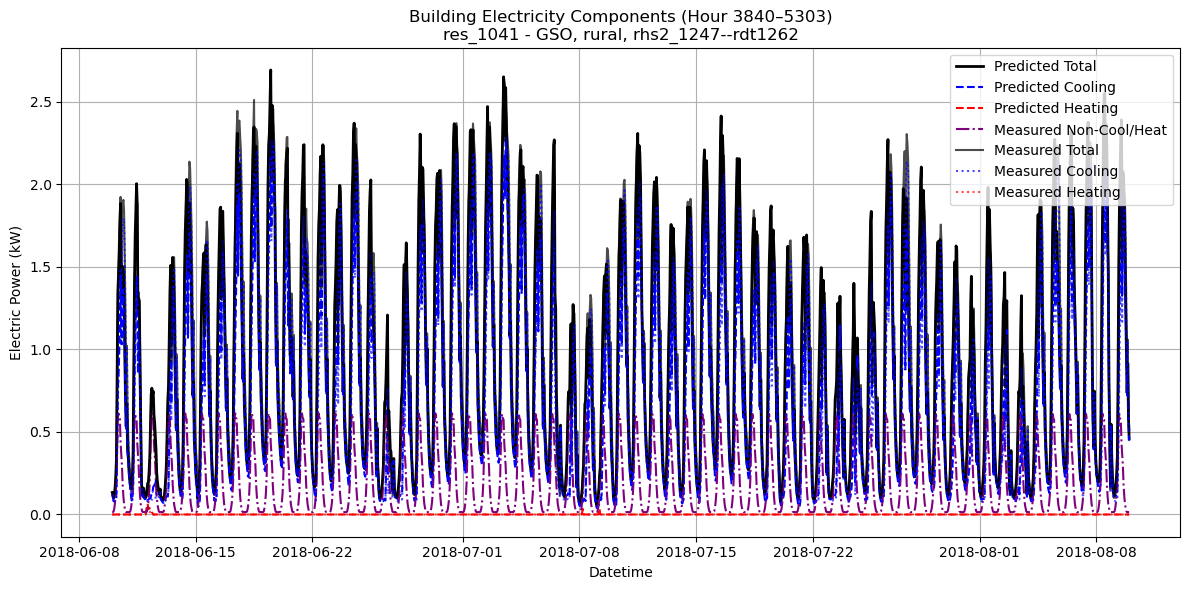

In [13]:
import matplotlib.pyplot as plt

# --- Define the selected outer_key and building_name ---
outer_key = ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res')  # example
building_name = 'res_1041'  # example

# --- Extract data ---
building_data = measured_buildings_cool_heat_dict[outer_key][building_name]
feeder_cooling_series = measured_feeder_cool_n_heat_dict[outer_key]['cooling_kw_sum'].replace(0, np.nan)
feeder_heating_series = measured_feeder_cool_n_heat_dict[outer_key]['heating_kw'].replace(0, np.nan)

# Load predicted feeder data and align index
feeder_pred_data = feeder_predict_cool_heat_dict[(TGW_weather_year, outer_key[1], outer_key[2], outer_key[3], outer_key[4])]
feeder_pred_data_aligned = feeder_pred_data.copy()
feeder_pred_data_aligned.index = feeder_cooling_series.index

# --- Compute time-varying component shares ---
cooling_ratio = building_data['cooling_sum_kw'].div(feeder_cooling_series).fillna(0)
heating_ratio = building_data['heating_kw'].div(feeder_heating_series).fillna(0)

# --- Compute predicted components ---
cooling_component = cooling_ratio * feeder_pred_data_aligned['cooling_kw_sum_predicted']
heating_component = heating_ratio * feeder_pred_data_aligned['heating_kw_predicted']
non_cn_h_component = building_data['non_cool_n_heat_kw']

# --- Compute total predicted load ---
building_predicted_total = cooling_component + heating_component + non_cn_h_component

# --- Measured values for comparison ---
measured_total = building_data['total_site_electricity_kw']
measured_cooling = building_data['cooling_sum_kw']
measured_heating = building_data['heating_kw']

# --- Select a range of data points (e.g., day 184) ---
start, end = 184 * 24, 184 * 24 + 24
start, end = 160 * 24, 220 * 24 + 24
building_predicted_total = building_predicted_total.iloc[start:end]
cooling_component = cooling_component.iloc[start:end]
heating_component = heating_component.iloc[start:end]
non_cn_h_component = non_cn_h_component.iloc[start:end]
measured_total = measured_total.iloc[start:end]
measured_cooling = measured_cooling.iloc[start:end]
measured_heating = measured_heating.iloc[start:end]
time_index = building_predicted_total.index

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(time_index, building_predicted_total, label='Predicted Total', linewidth=2, color='black')
plt.plot(time_index, cooling_component, label='Predicted Cooling', linestyle='--', color='blue')
plt.plot(time_index, heating_component, label='Predicted Heating', linestyle='--', color='red')
plt.plot(time_index, non_cn_h_component, label='Measured Non-Cool/Heat', linestyle='-.', color='purple')
plt.plot(time_index, measured_total, label='Measured Total', alpha=0.7, color='black')
plt.plot(time_index, measured_cooling, label='Measured Cooling', linestyle=':', alpha=0.7, color='blue')
plt.plot(time_index, measured_heating, label='Measured Heating', linestyle=':', alpha=0.7, color='red')

# --- Title and labels ---
plt.title(f"Building Electricity Components (Hour {start}–{end - 1})\n{building_name} - {outer_key[1]}, {outer_key[2]}, {outer_key[3]}")
plt.xlabel("Datetime")
plt.ylabel("Electric Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Analyze cooling and heating historical ratios 

#### Load data

In [12]:
building_measured_cooling_ratio_dict = joblib.load("building_measured_cooling_ratio_dict.joblib")
building_measured_heating_ratio_dict = joblib.load("building_measured_heating_ratio_dict.joblib")

FileNotFoundError: [Errno 2] No such file or directory: 'building_measured_cooling_ratio_dict.joblib'

In [42]:
building_measured_heating_ratio_dict.keys()

dict_keys([('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'com'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'com'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'res'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2999', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'res'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'com')])

#### Plot heating and cooling ratios max value for all buildings in each feeder

In [9]:
import matplotlib.pyplot as plt

# Loop over all outer keys
for outer_key in building_measured_cooling_ratio_dict:
    cooling_ratios = building_measured_cooling_ratio_dict[outer_key]
    heating_ratios = building_measured_heating_ratio_dict[outer_key]

    # Prepare data for cooling
    building_names = list(cooling_ratios.keys())
    max_cooling_values = [series.max() for series in cooling_ratios.values()]

    # Scatter plot for cooling
    plt.figure(figsize=(10, 4))
    plt.scatter(building_names, max_cooling_values, color='blue')
    plt.title(f'Max Cooling Ratios - {outer_key}')
    plt.xlabel('Building Name')
    plt.ylabel('Max Cooling Ratio')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.5)  # adjust as needed
    plt.tight_layout()
    plt.show()

    # Prepare data for heating
    max_heating_values = [series.max() for series in heating_ratios.values()]

    # Scatter plot for heating
    plt.figure(figsize=(10, 4))
    plt.scatter(building_names, max_heating_values, color='red')
    plt.title(f'Max Heating Ratios - {outer_key}')
    plt.xlabel('Building Name')
    plt.ylabel('Max Heating Ratio')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.5)  # adjust as needed
    plt.tight_layout()
    plt.show()


NameError: name 'building_measured_cooling_ratio_dict' is not defined

#### Select feeder

In [63]:
# Select feeder and building type (outer_key)
smart_ds_year = '2018'
city = 'GSO'
region = 'rural'
feeder = 'rhs2_1247--rdt1262'
building_type = 'res'

# Get inner dictionaries (used for ploting)
cooling_ratios = building_measured_cooling_ratio_dict[outer_key]
heating_ratios = building_measured_heating_ratio_dict[outer_key]

# Display buildings in this feeder
building_measured_heating_ratio_dict[(smart_ds_year, city, region, feeder, building_type)].keys()

dict_keys(['res_101', 'res_1013', 'res_1036', 'res_1037', 'res_1041', 'res_1042', 'res_1070', 'res_1094', 'res_1108', 'res_1112', 'res_1113', 'res_1138', 'res_1148', 'res_1157', 'res_1160', 'res_1162', 'res_1186', 'res_1190', 'res_1193', 'res_1205', 'res_1209', 'res_1220', 'res_1223', 'res_1228', 'res_1258', 'res_1267', 'res_1270', 'res_1273', 'res_1276', 'res_128', 'res_1283', 'res_141', 'res_149', 'res_162', 'res_182', 'res_184', 'res_19', 'res_199', 'res_2', 'res_203', 'res_205', 'res_206', 'res_207', 'res_225', 'res_229', 'res_236', 'res_24', 'res_245', 'res_250', 'res_26', 'res_263', 'res_267', 'res_278', 'res_280', 'res_282', 'res_305', 'res_314', 'res_324', 'res_33', 'res_339', 'res_35', 'res_362', 'res_366', 'res_39', 'res_4', 'res_401', 'res_407', 'res_409', 'res_416', 'res_421', 'res_436', 'res_450', 'res_454', 'res_46', 'res_47', 'res_470', 'res_502', 'res_504', 'res_517', 'res_523', 'res_549', 'res_561', 'res_616', 'res_621', 'res_624', 'res_626', 'res_627', 'res_63', 'res_

#### Plot heating and cooling ratios for each building - separately 

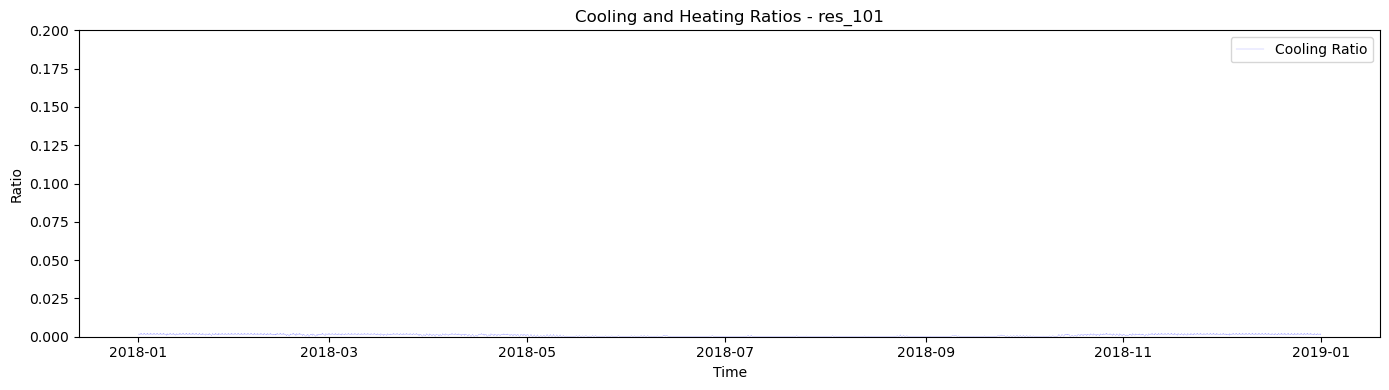

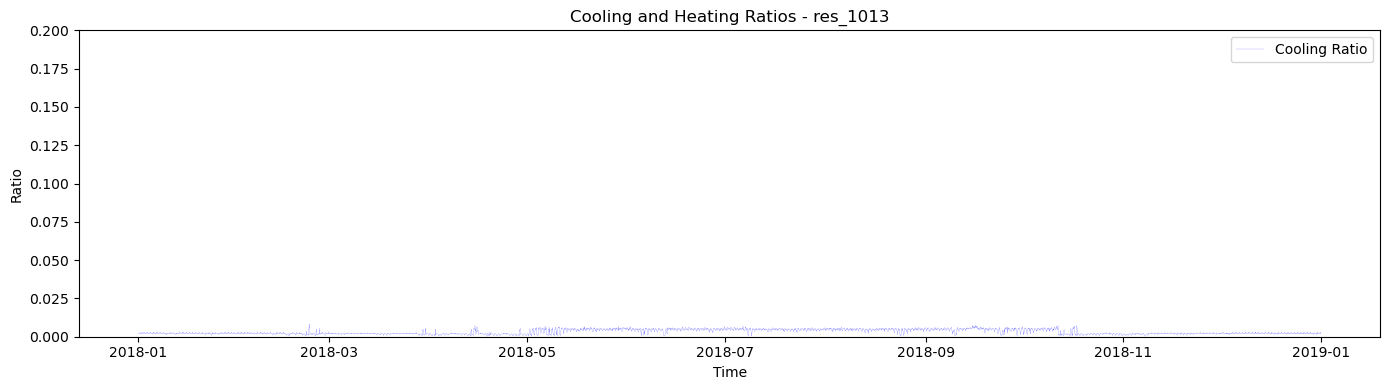

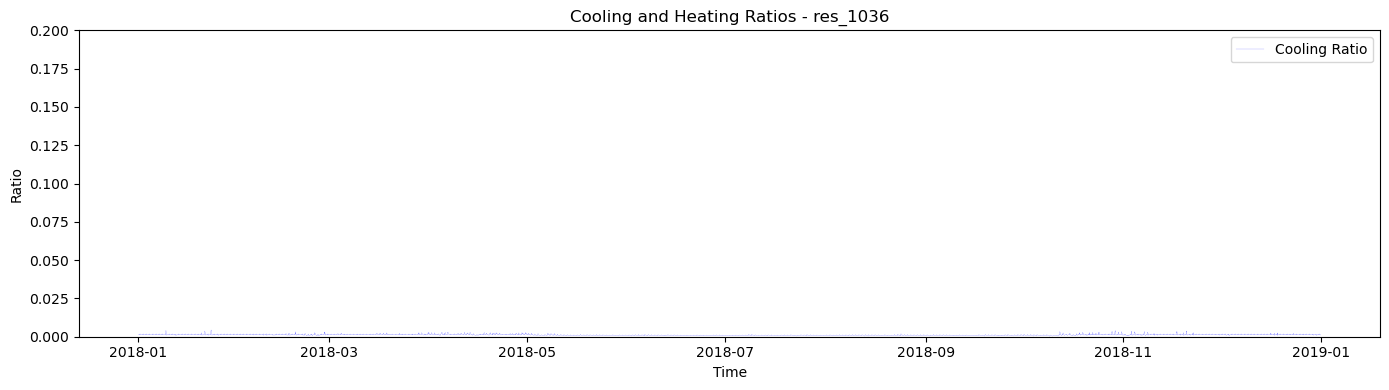

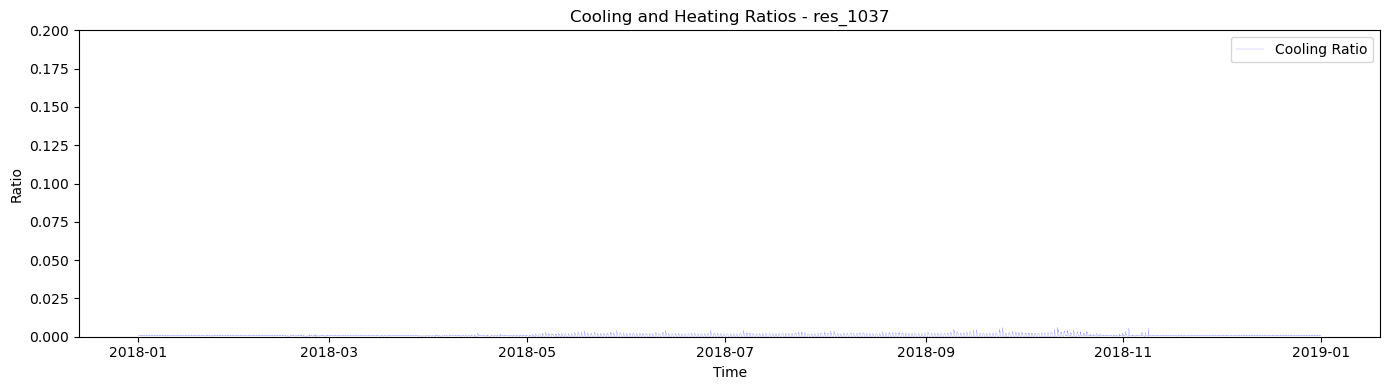

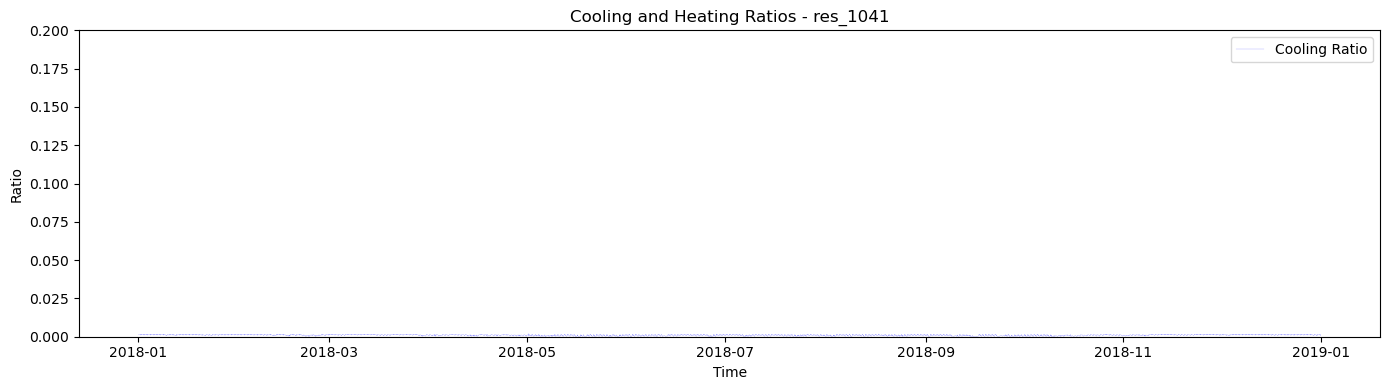

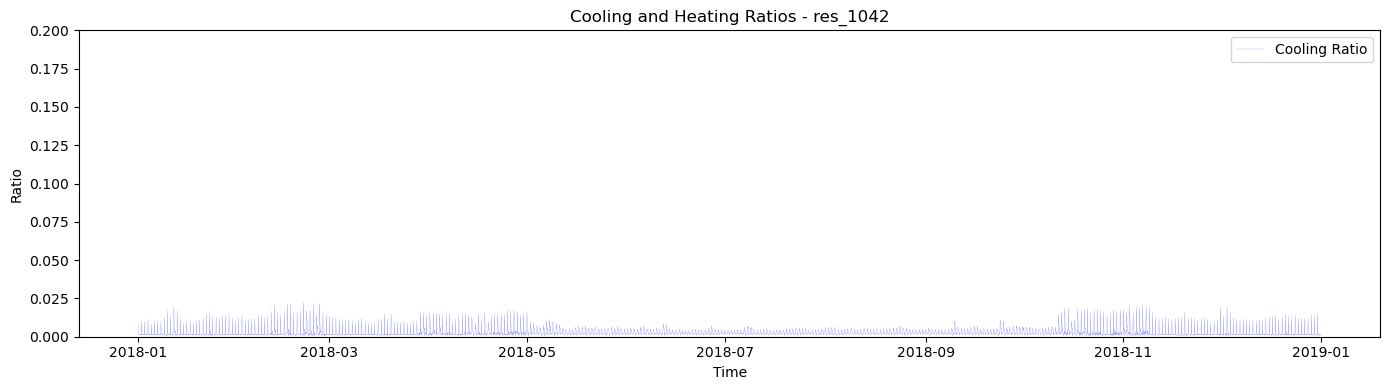

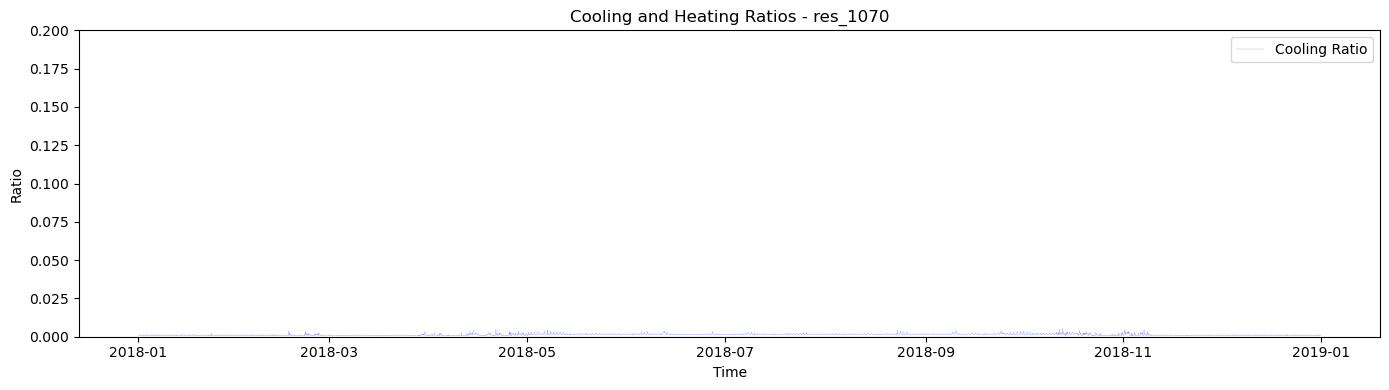

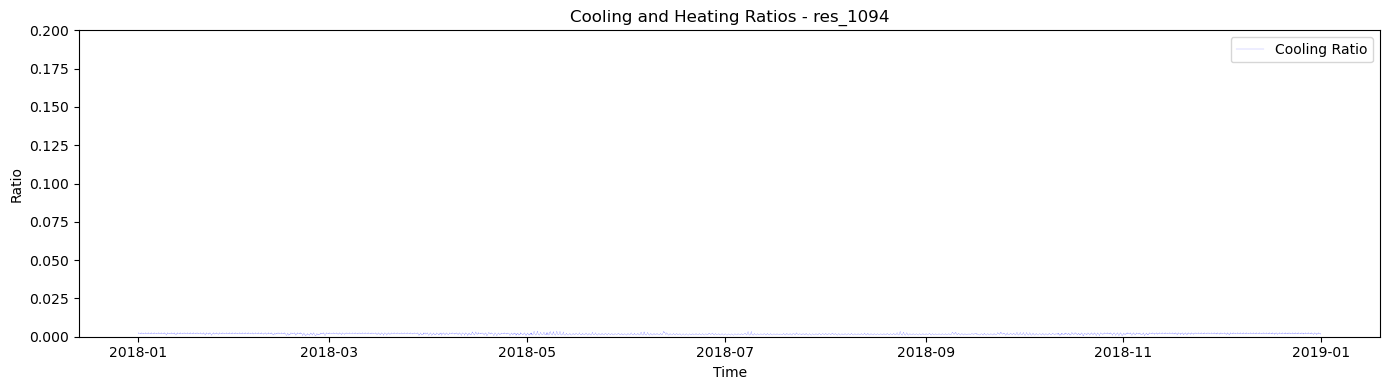

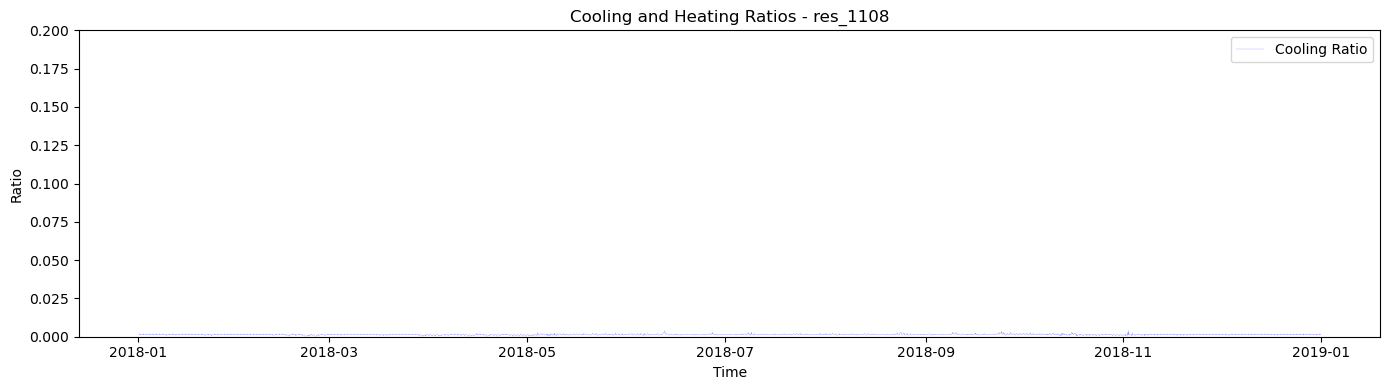

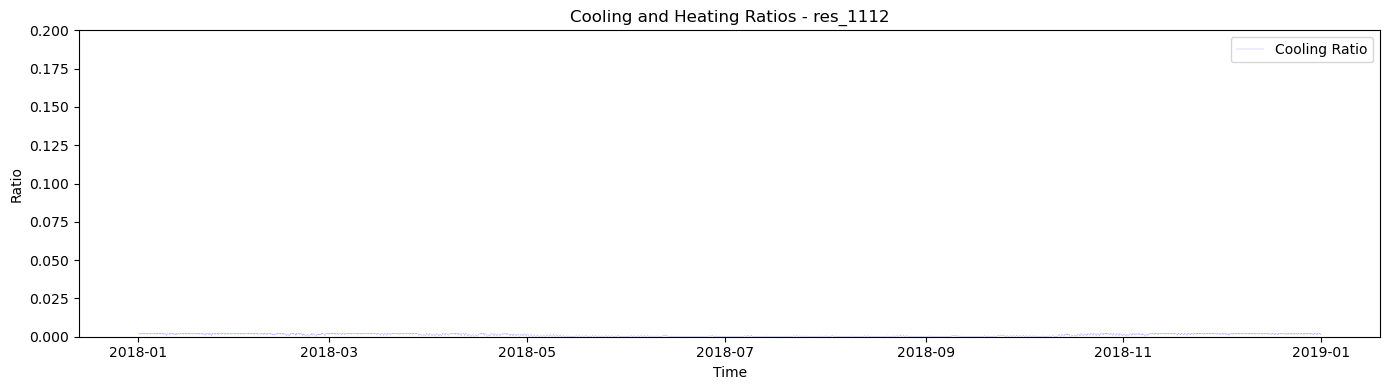

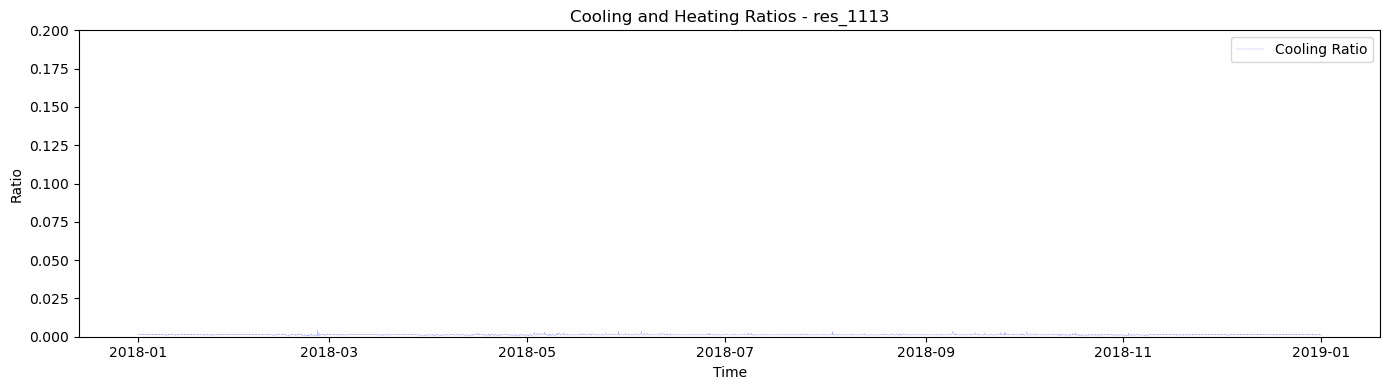

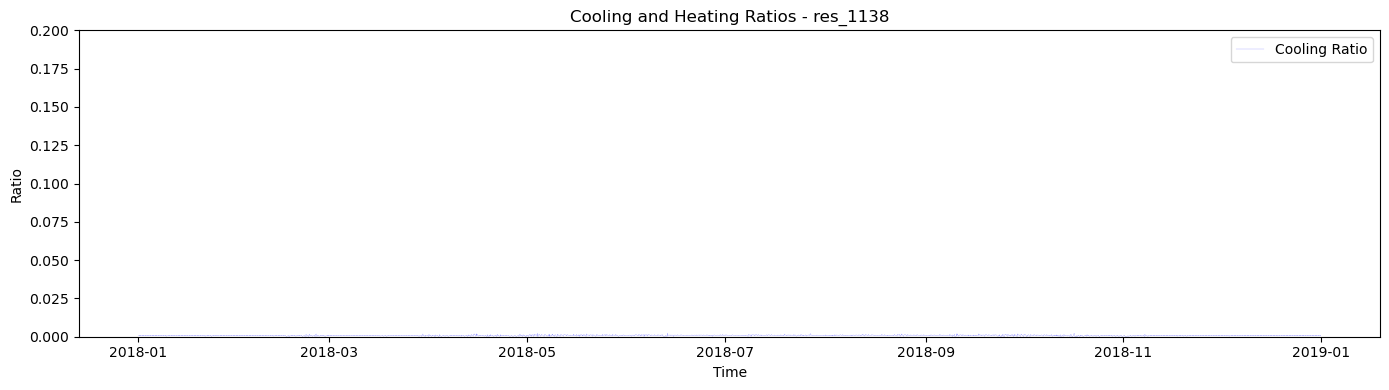

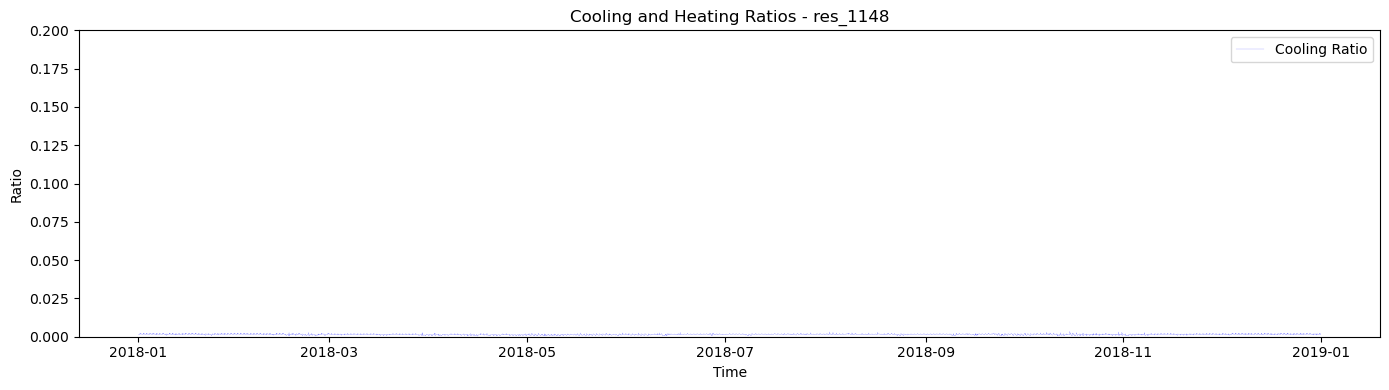

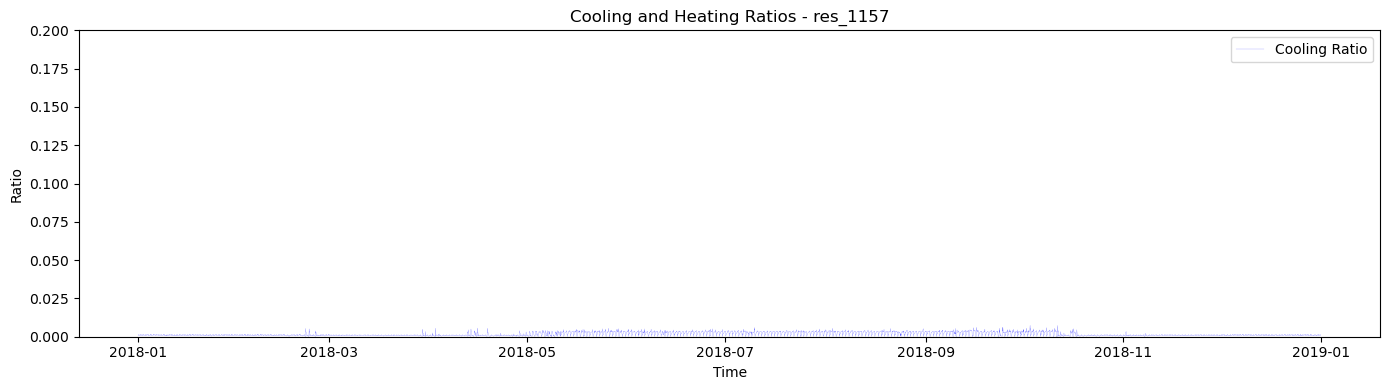

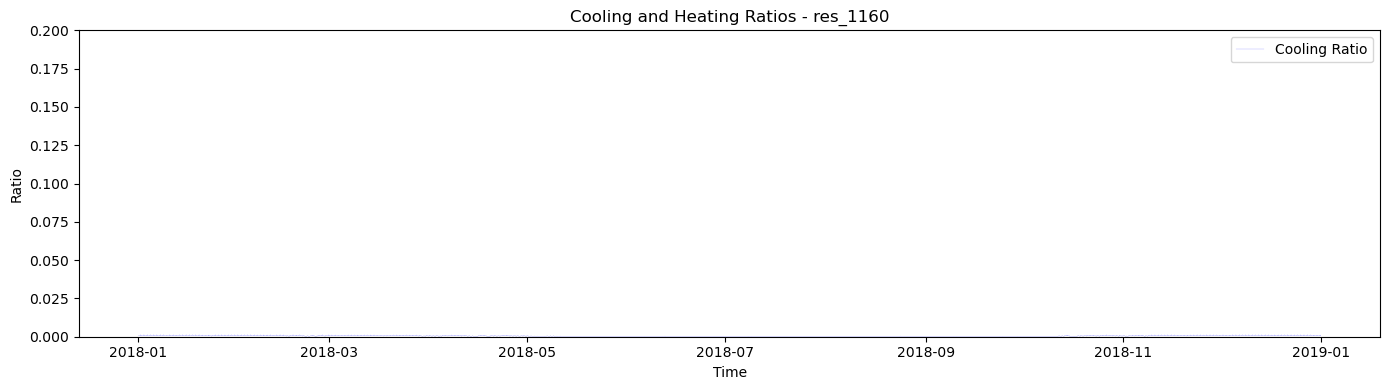

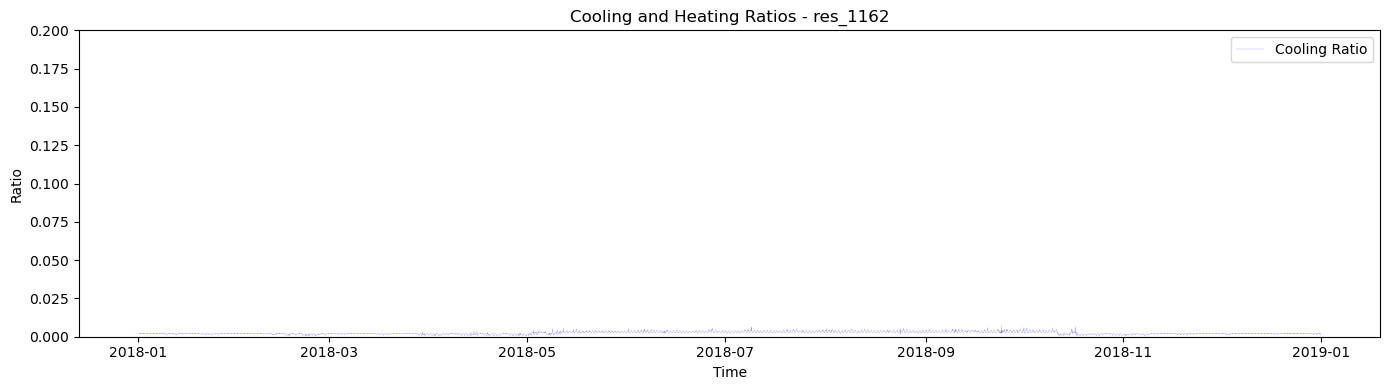

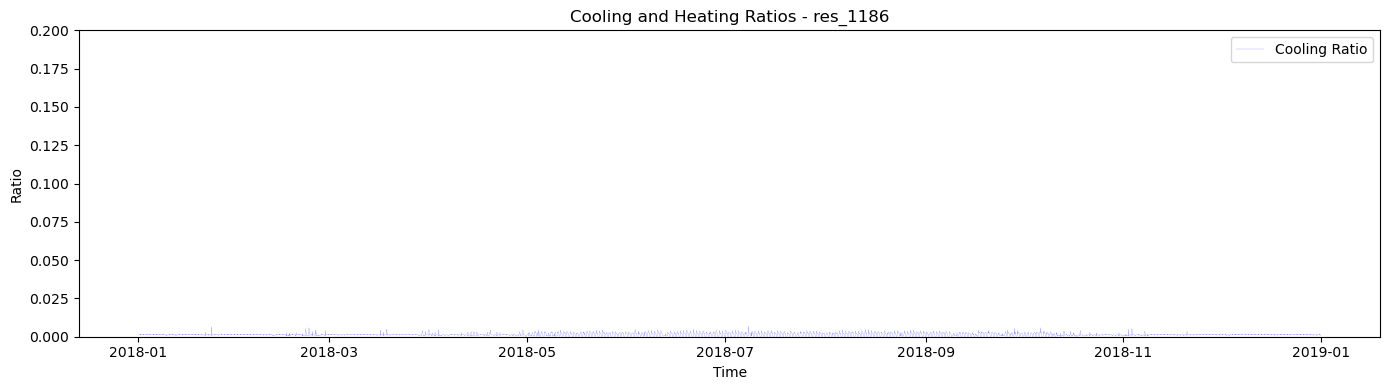

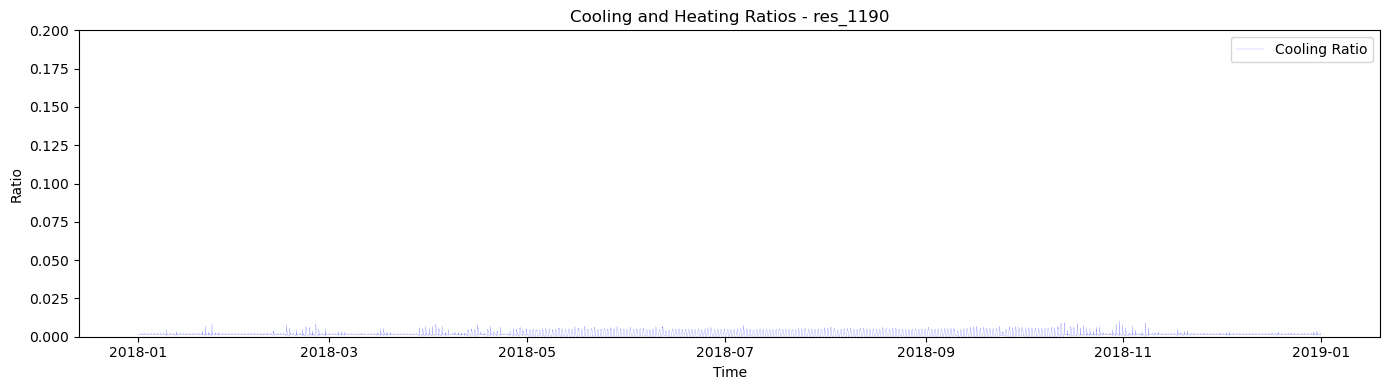

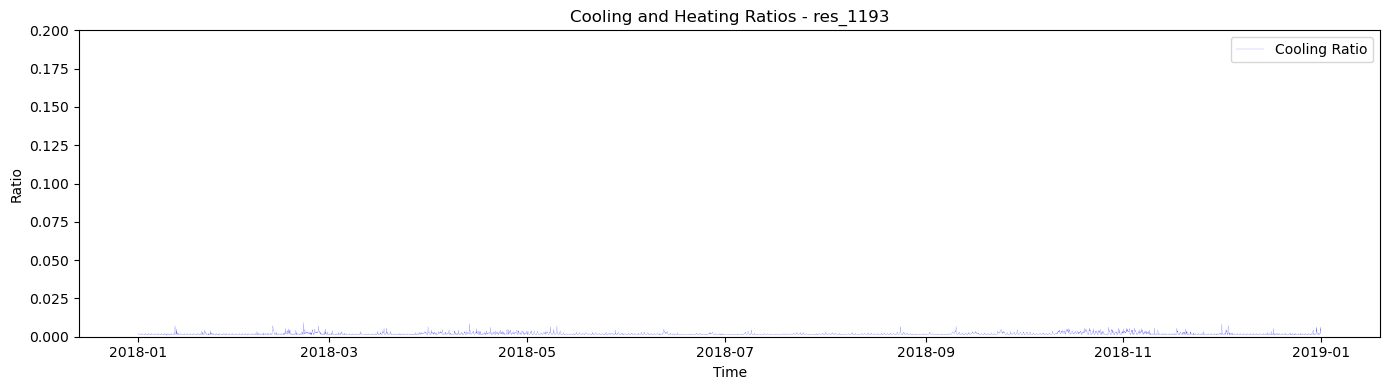

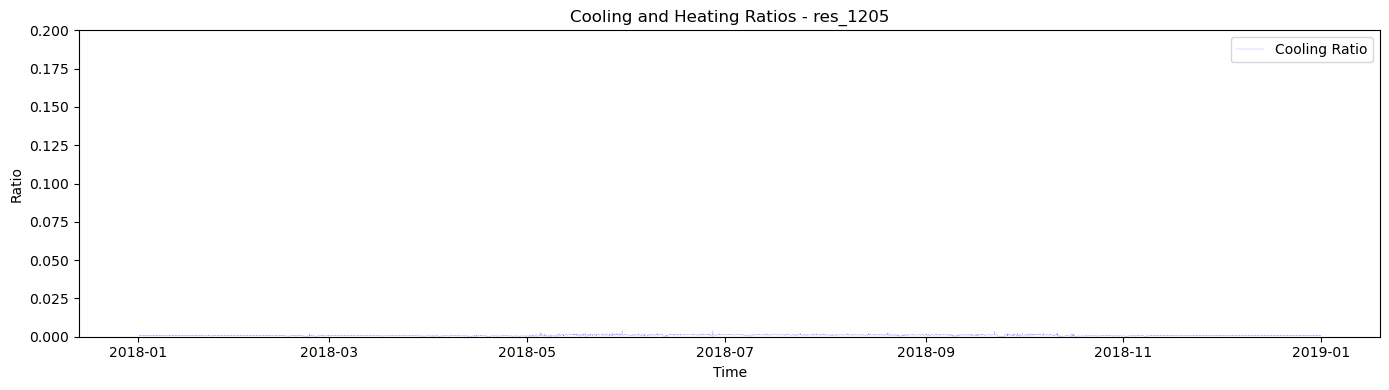

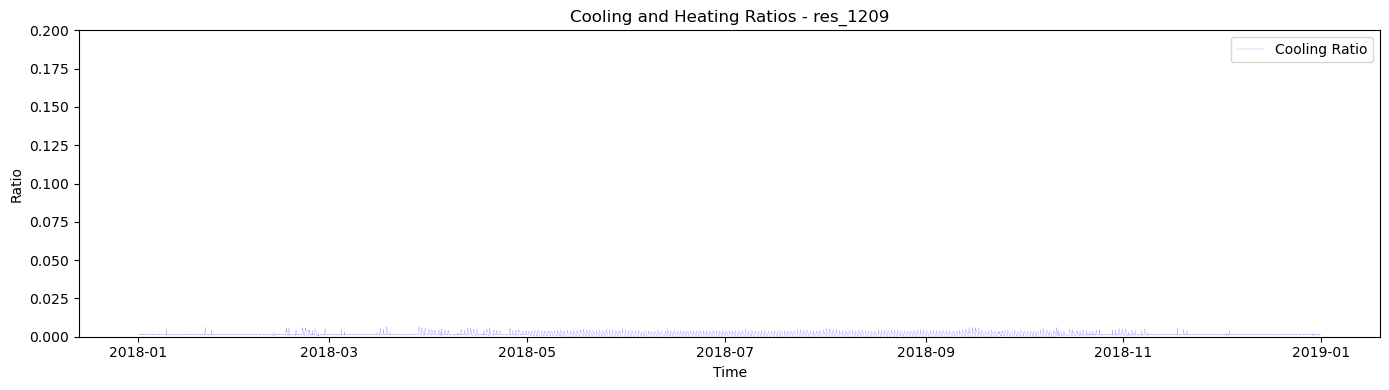

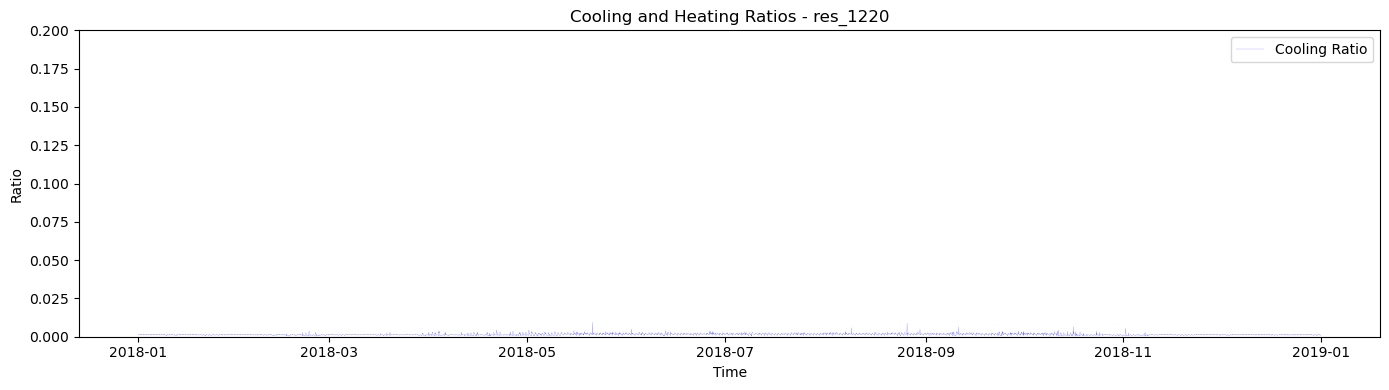

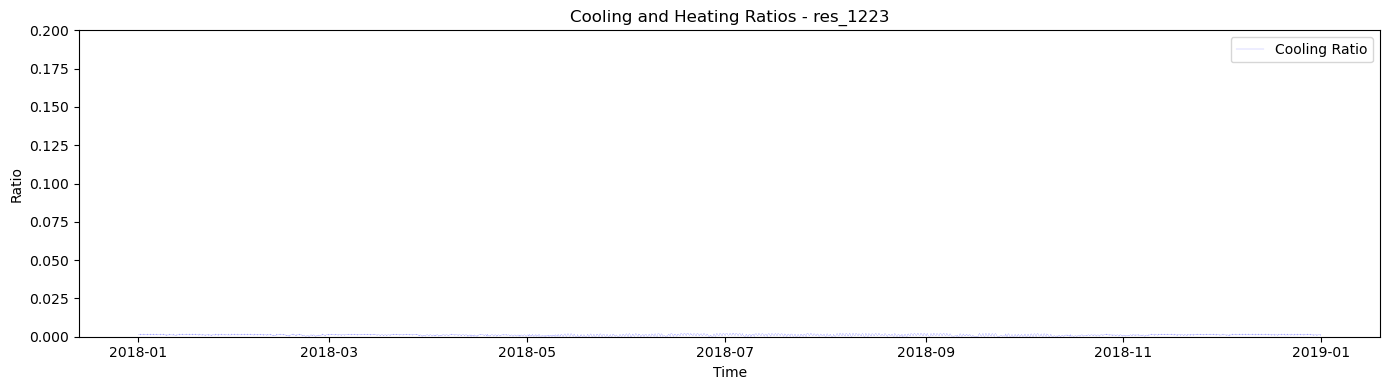

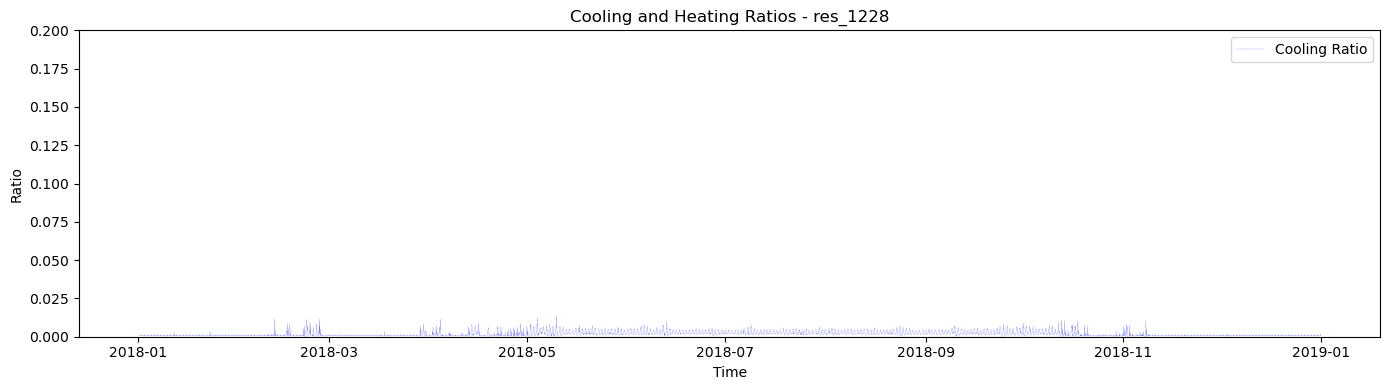

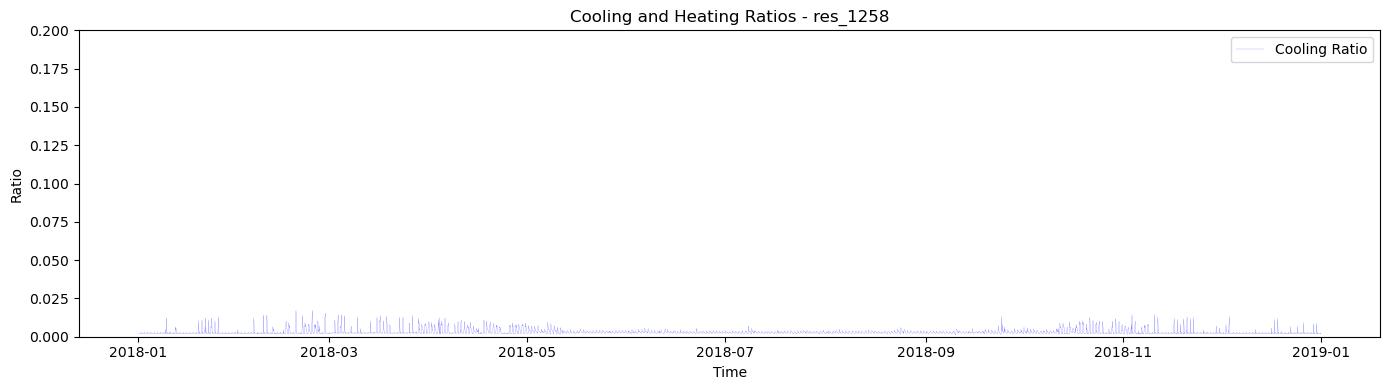

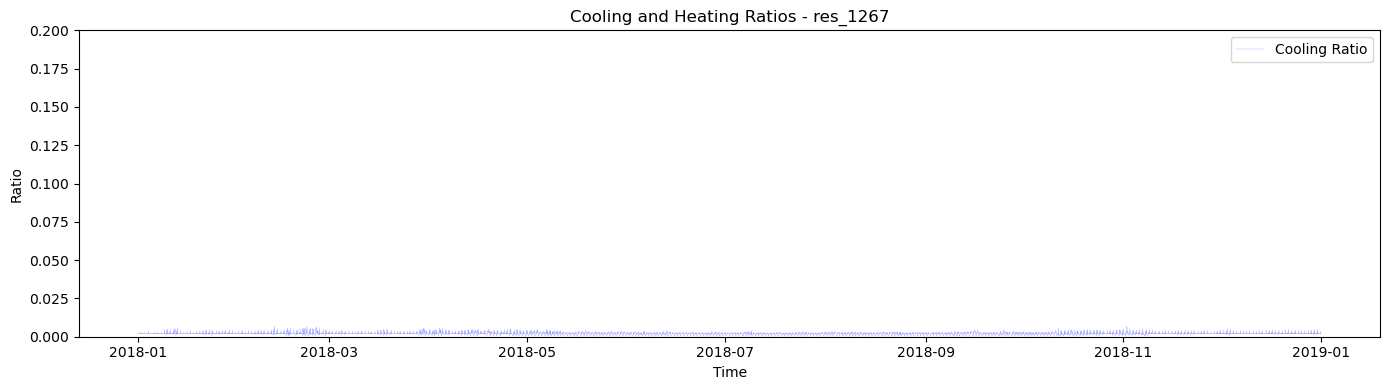

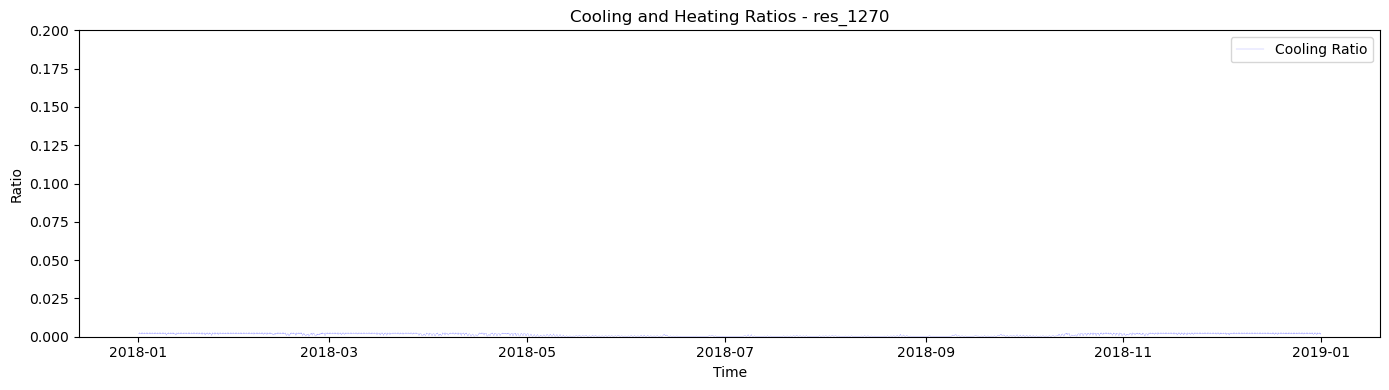

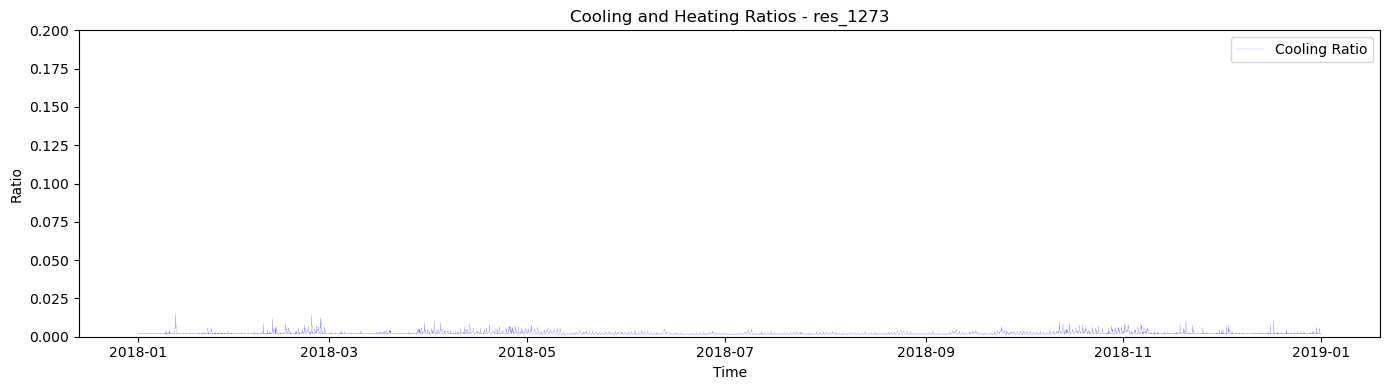

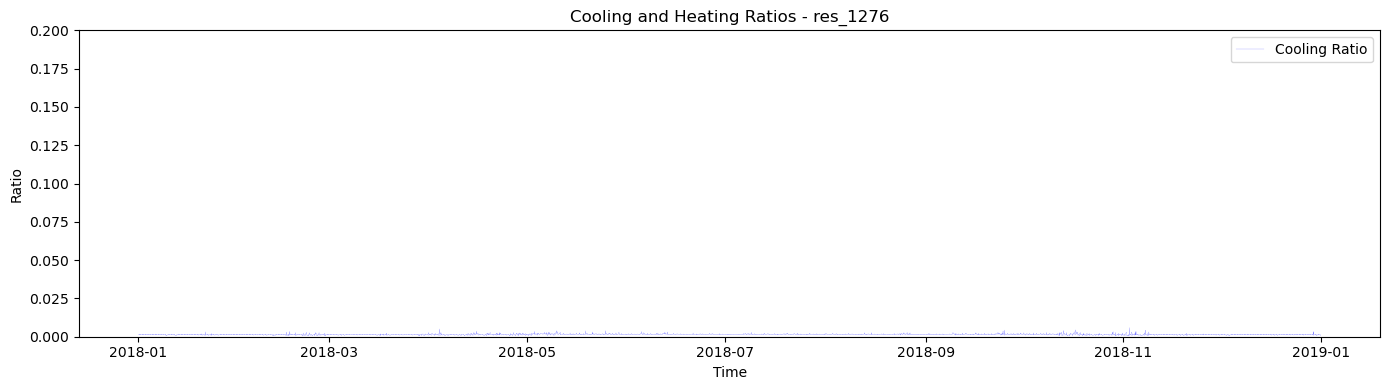

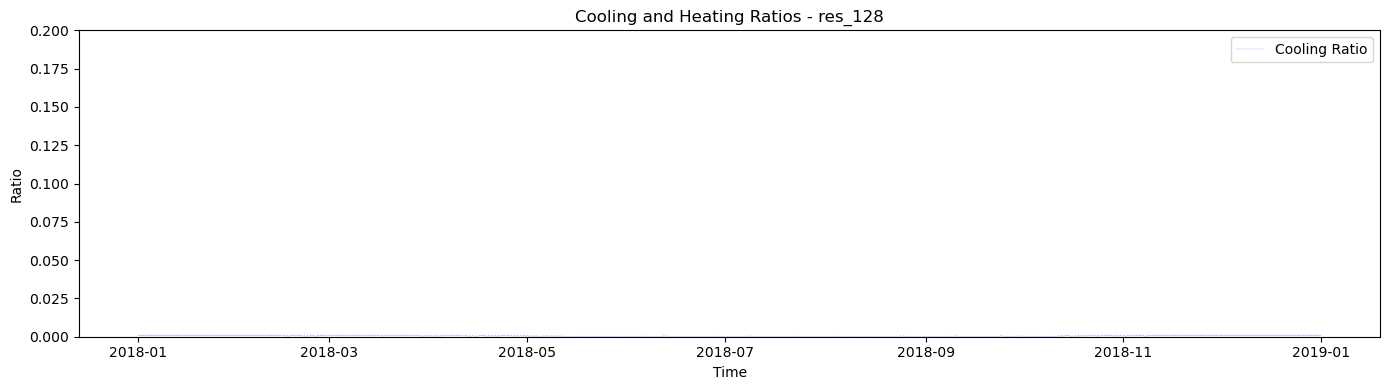

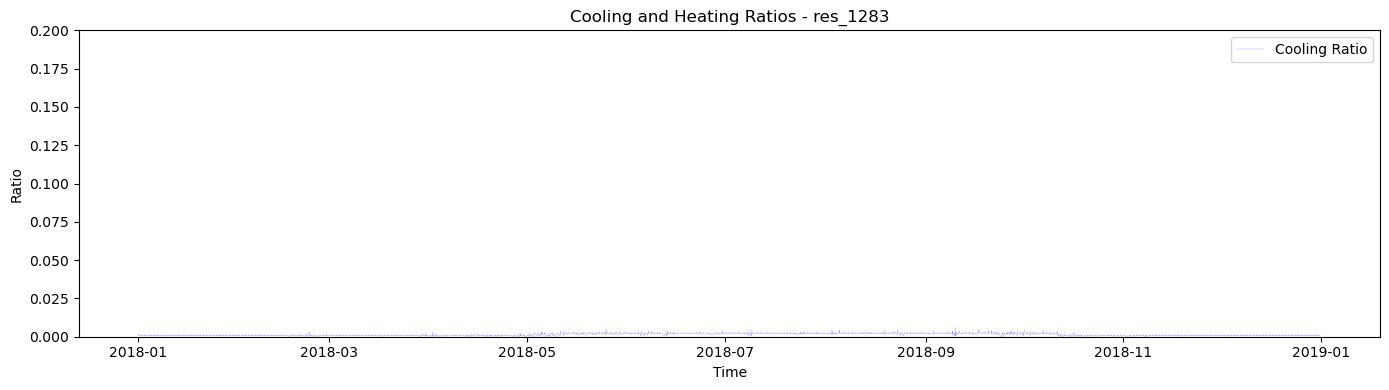

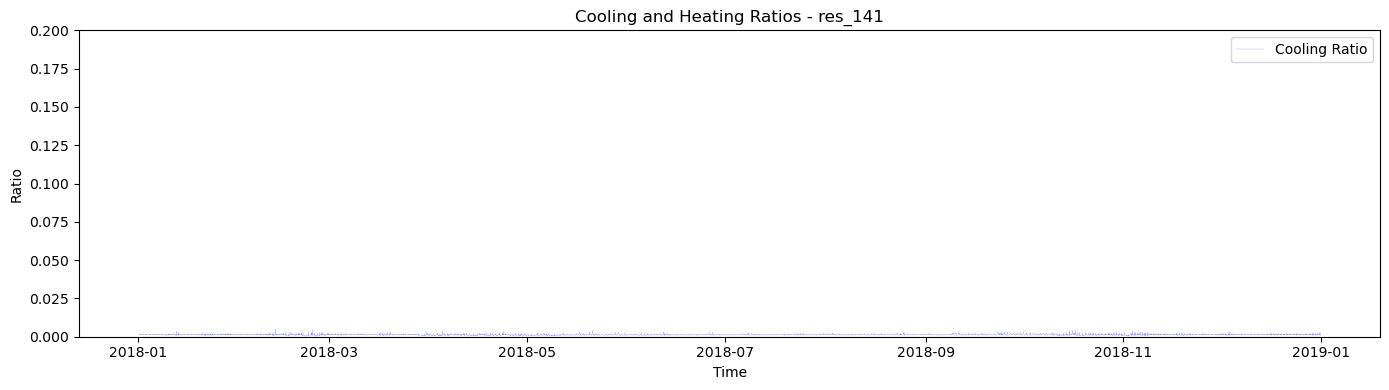

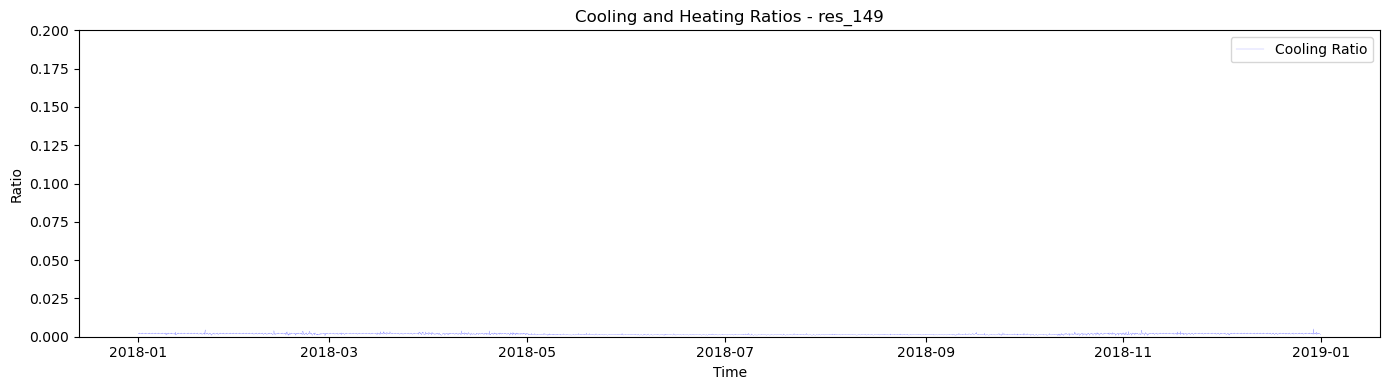

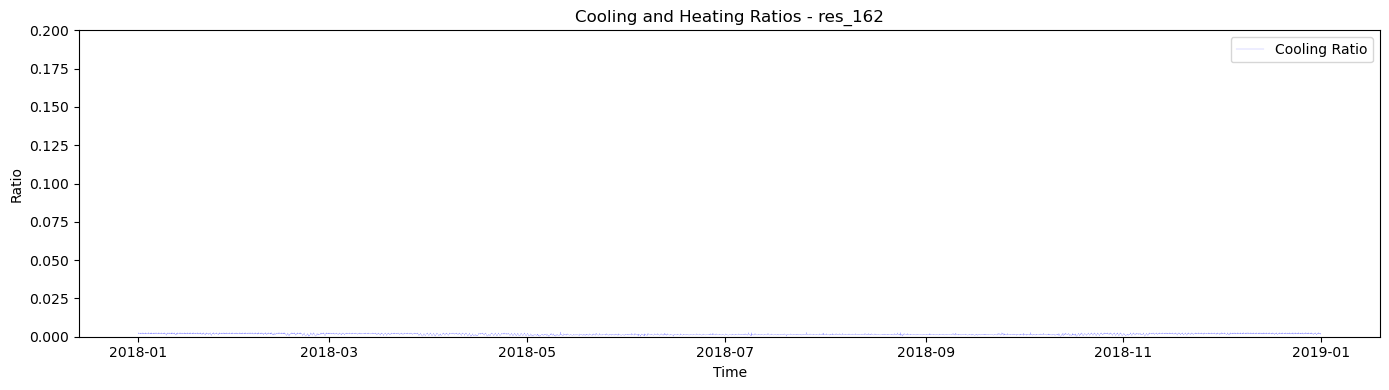

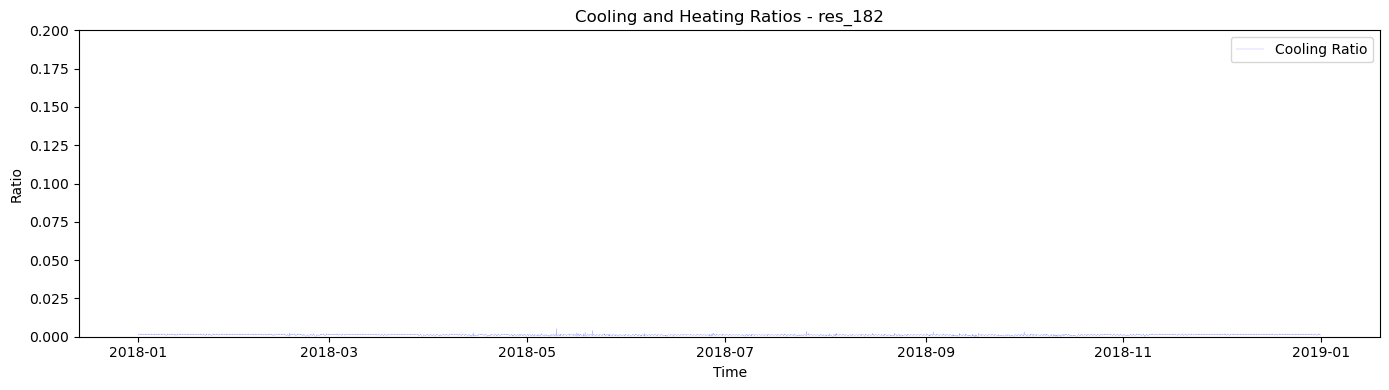

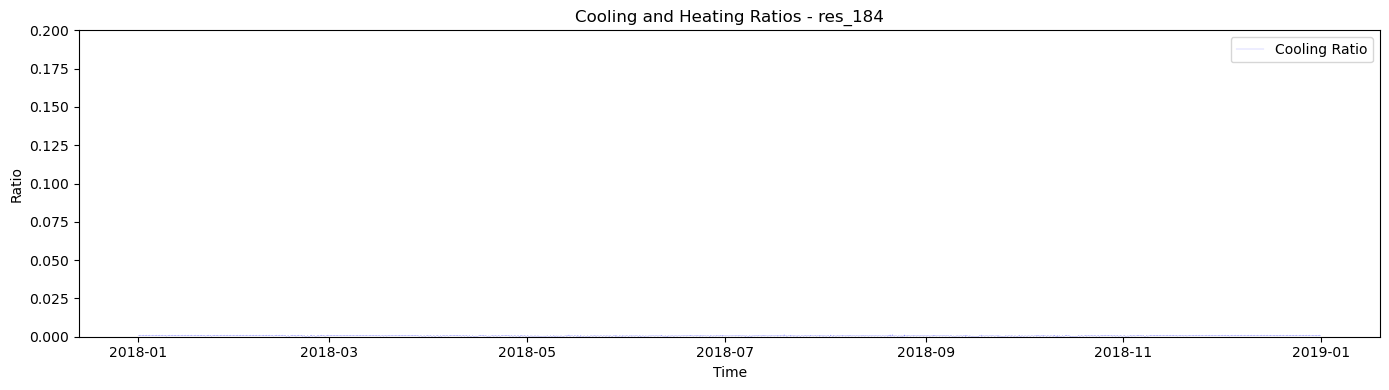

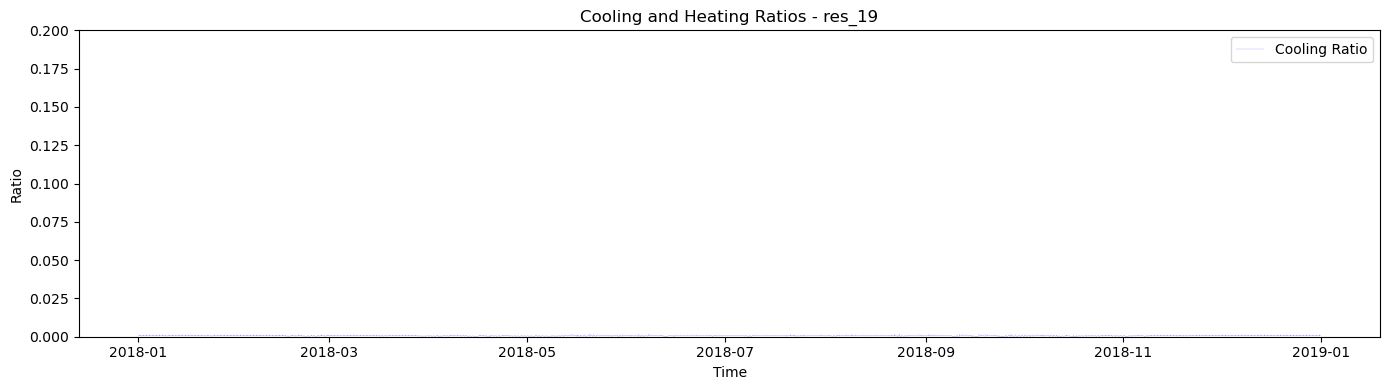

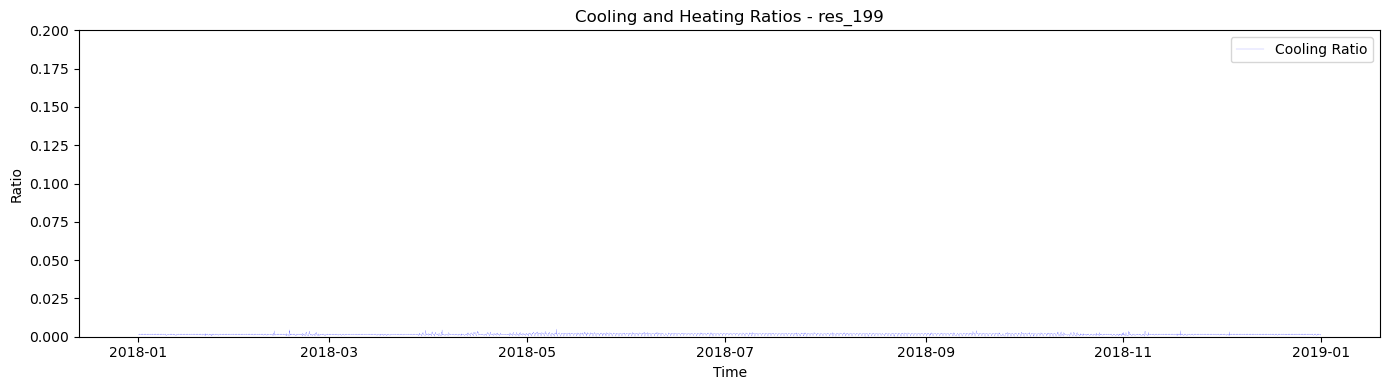

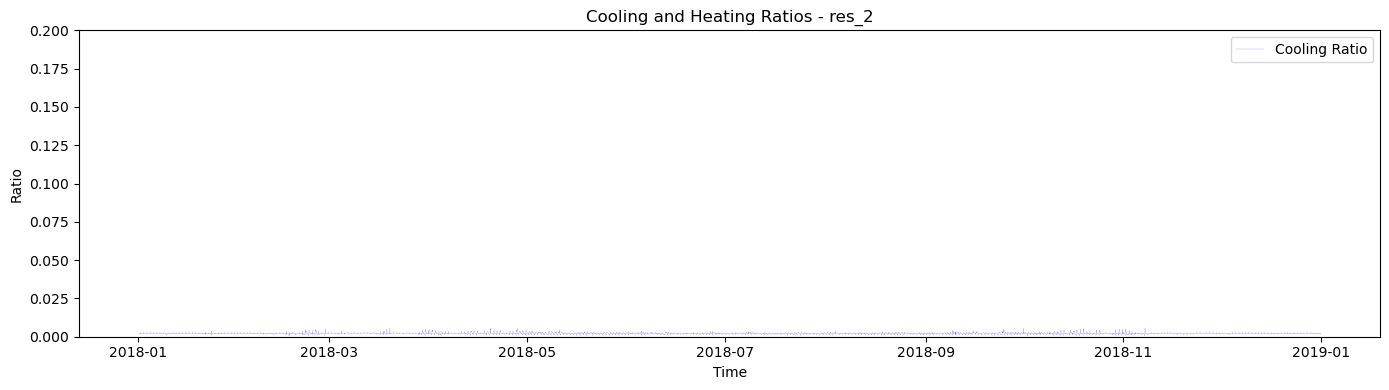

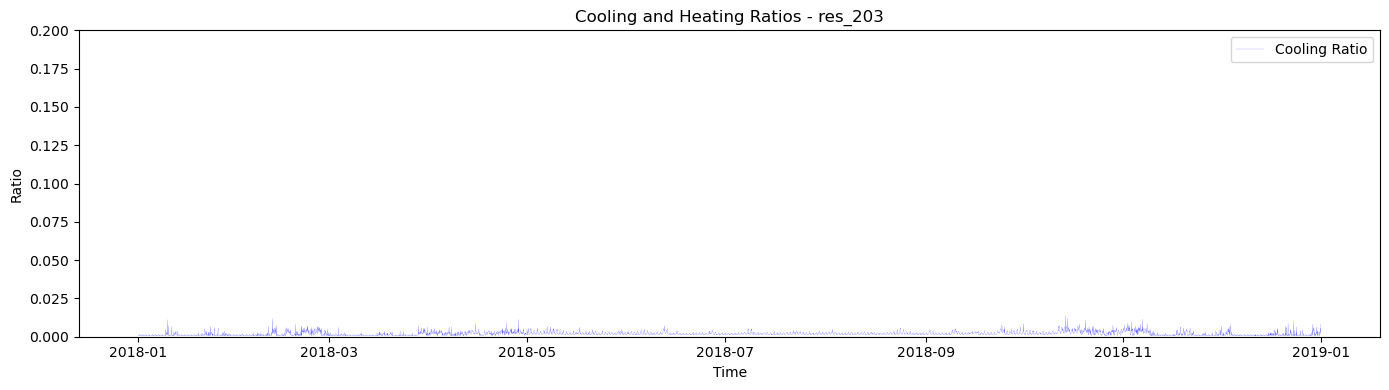

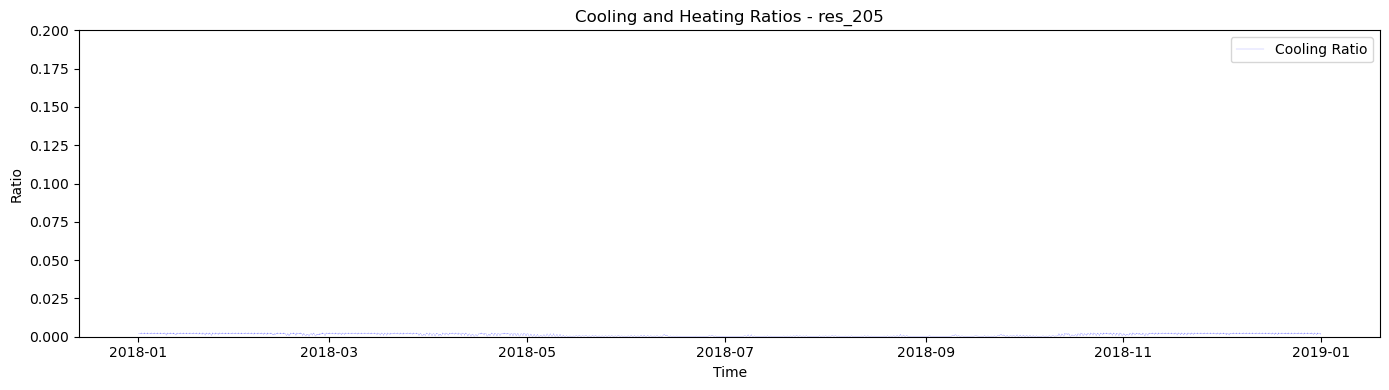

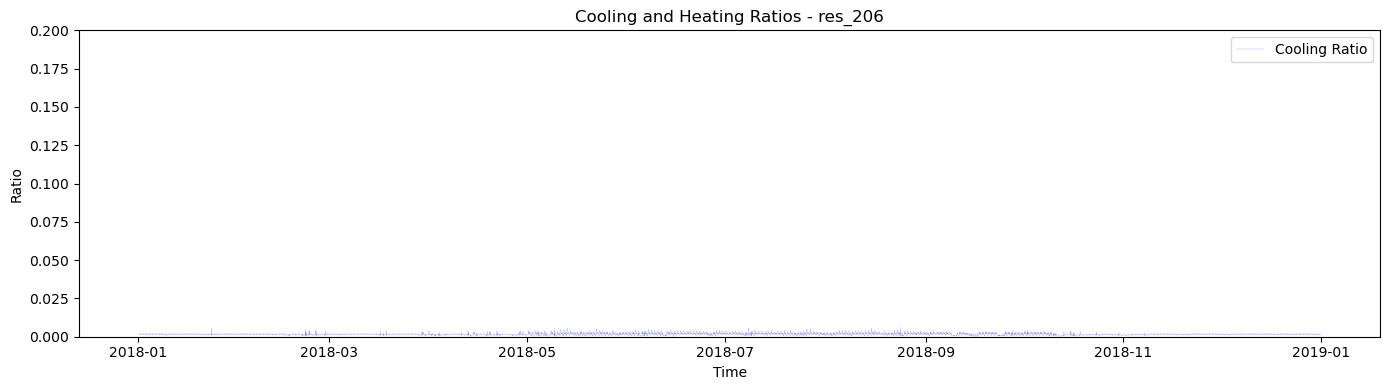

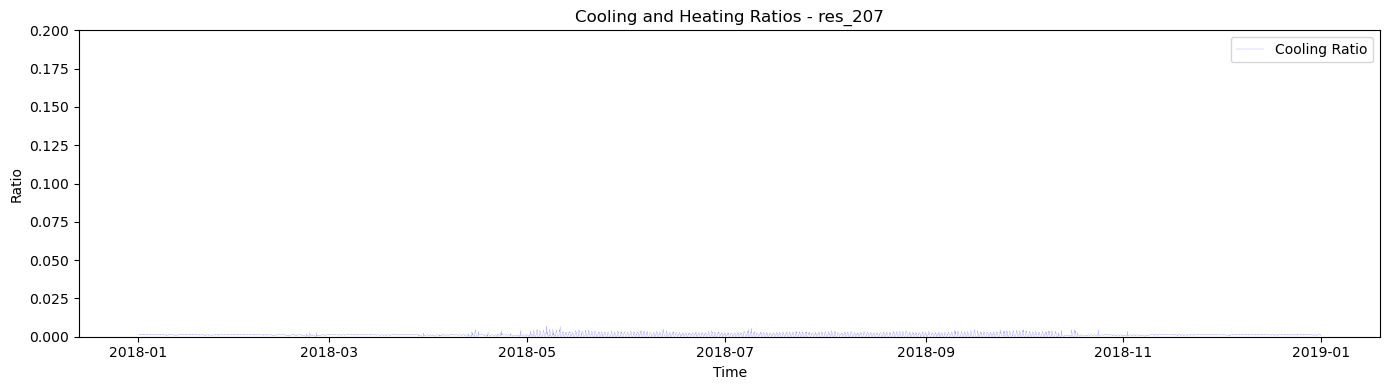

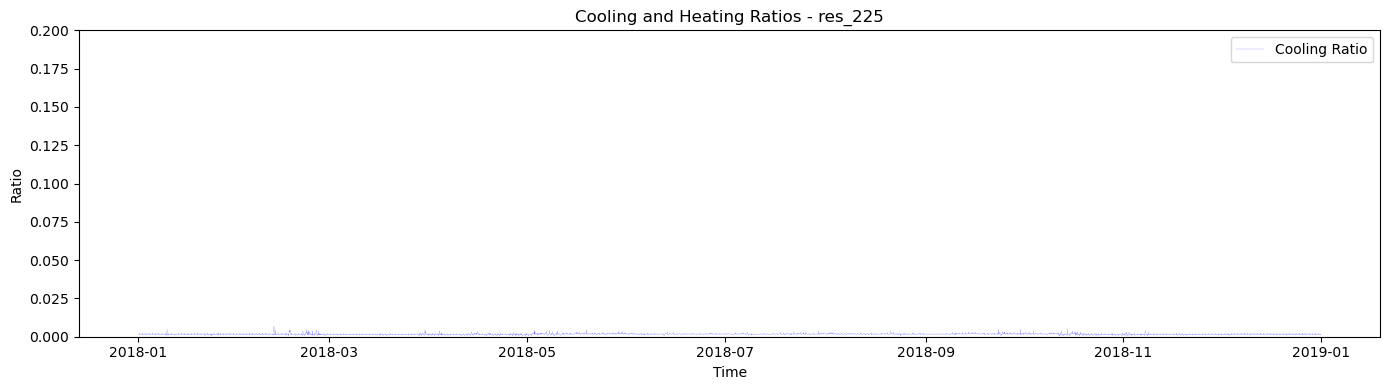

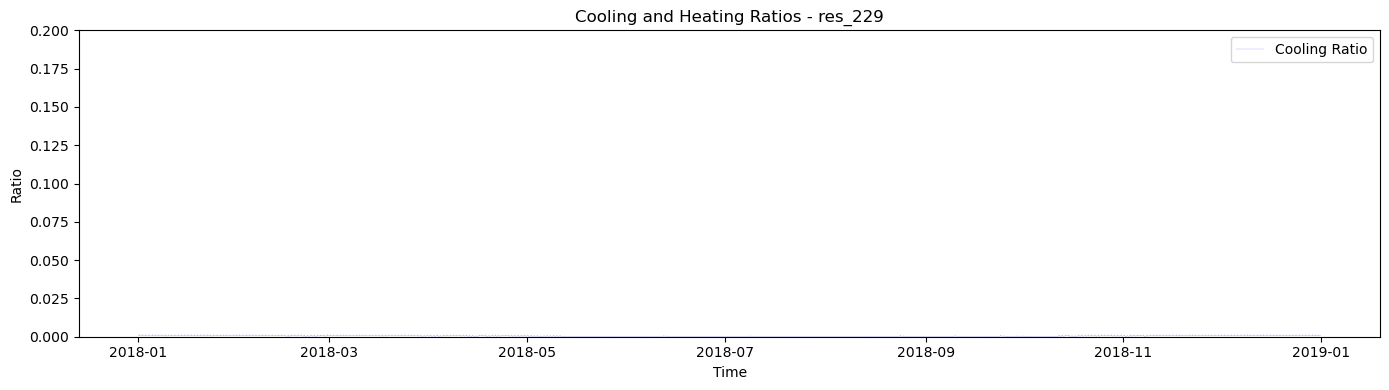

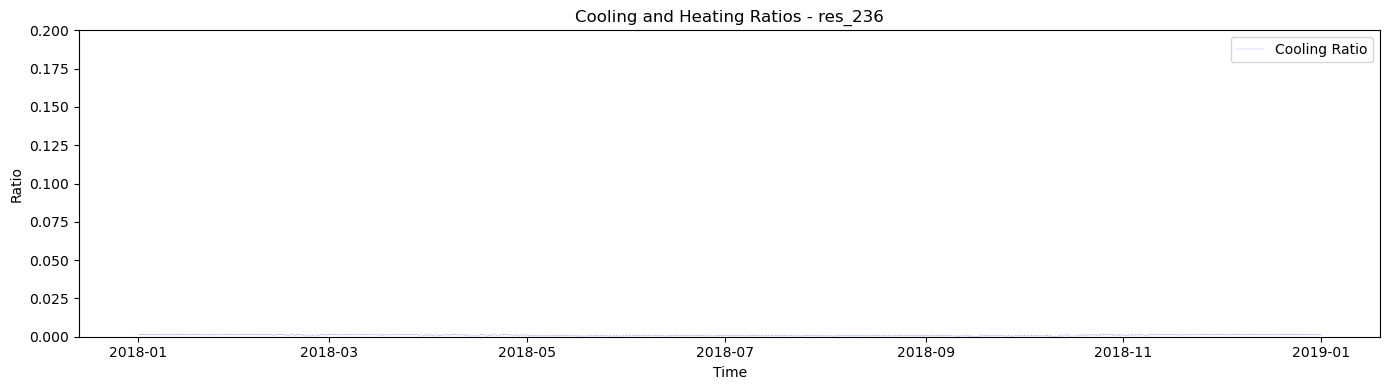

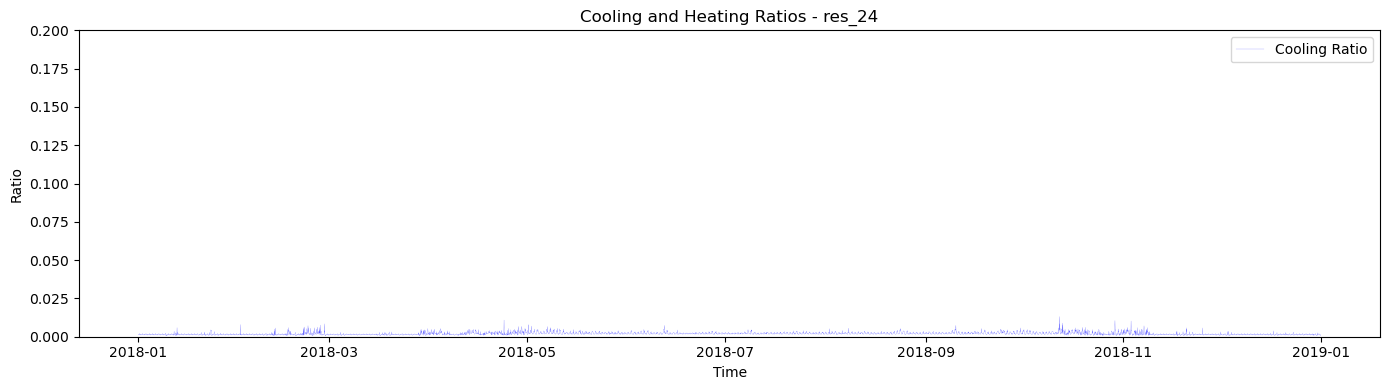

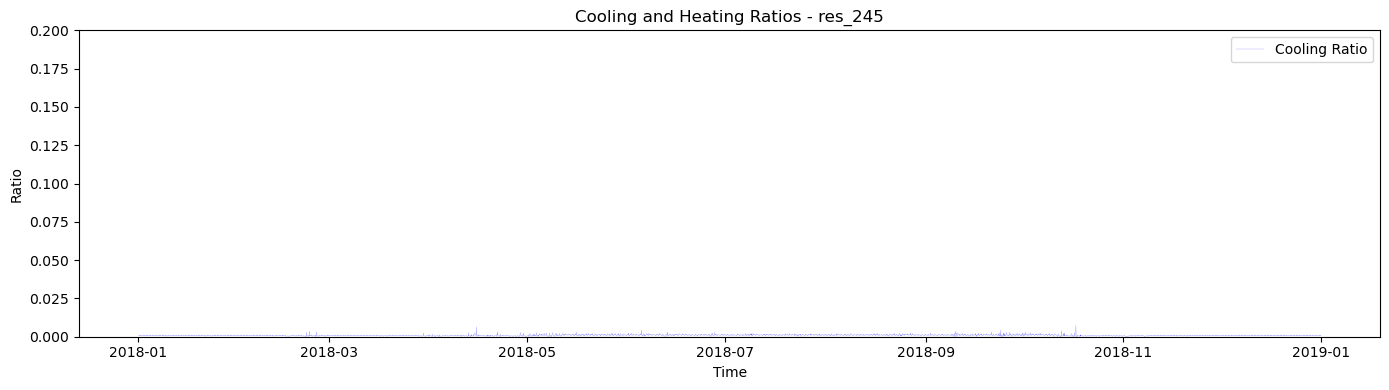

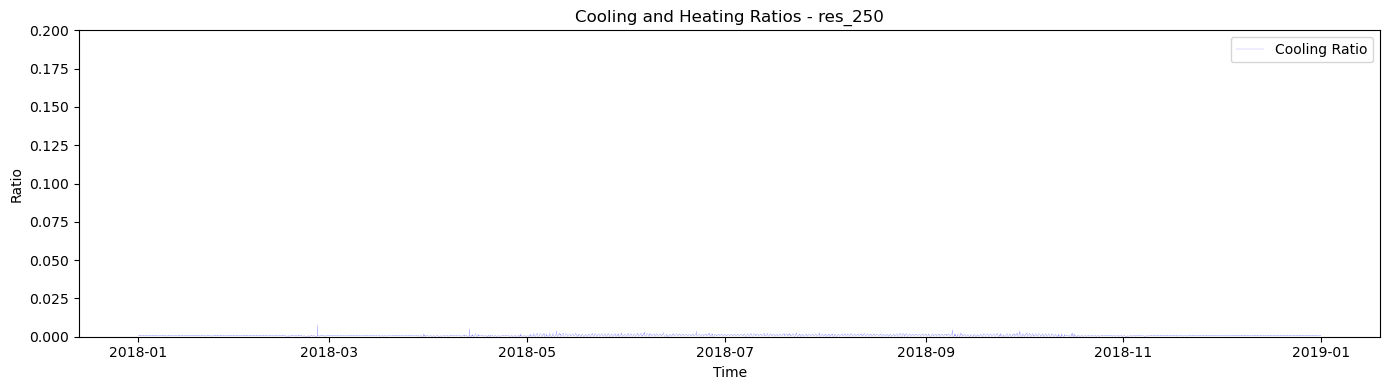

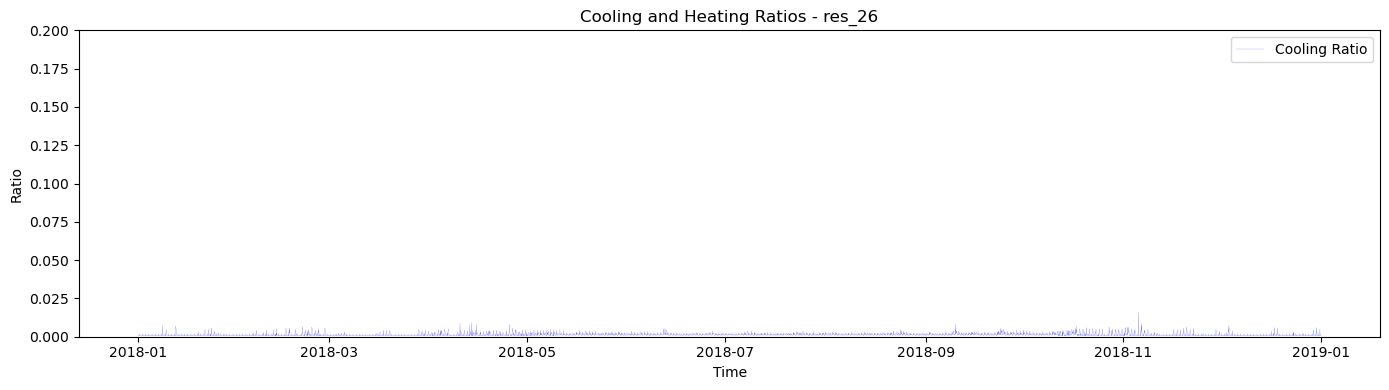

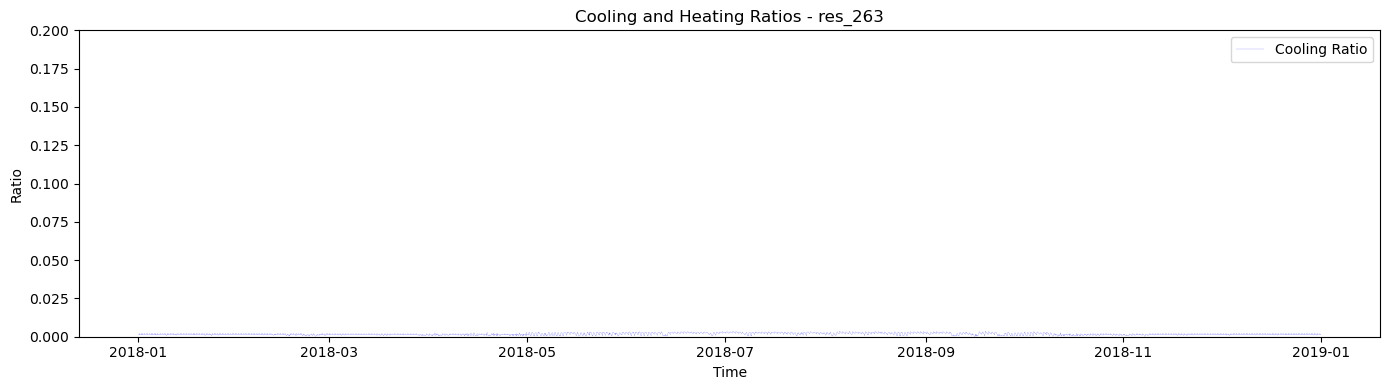

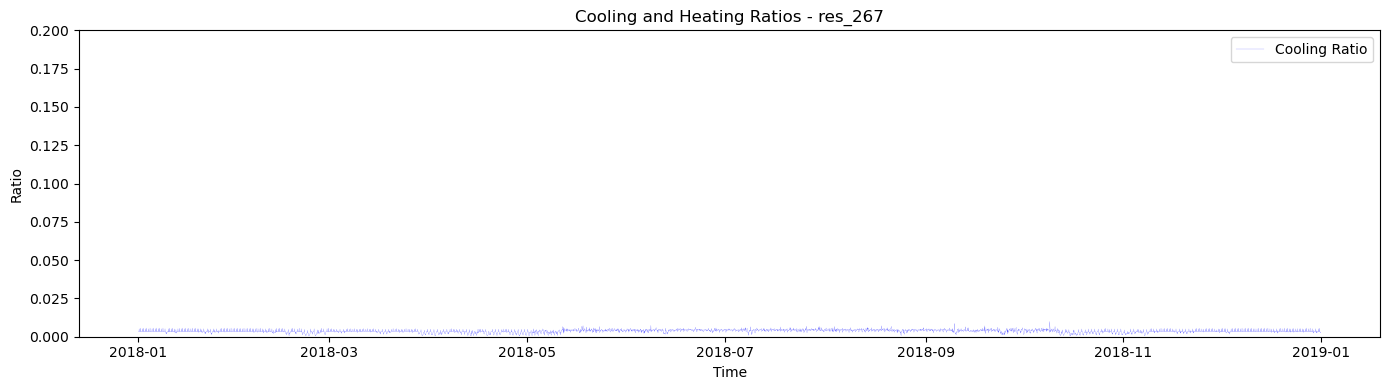

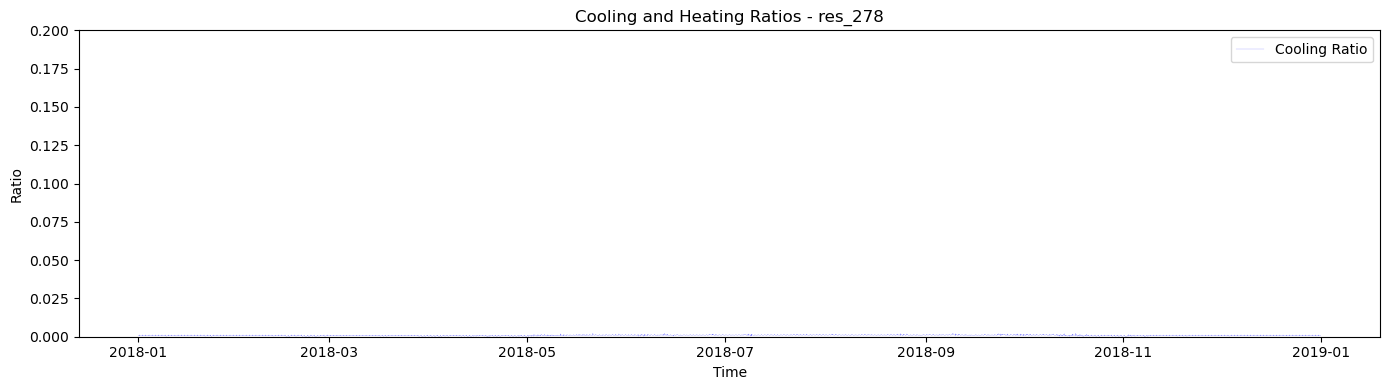

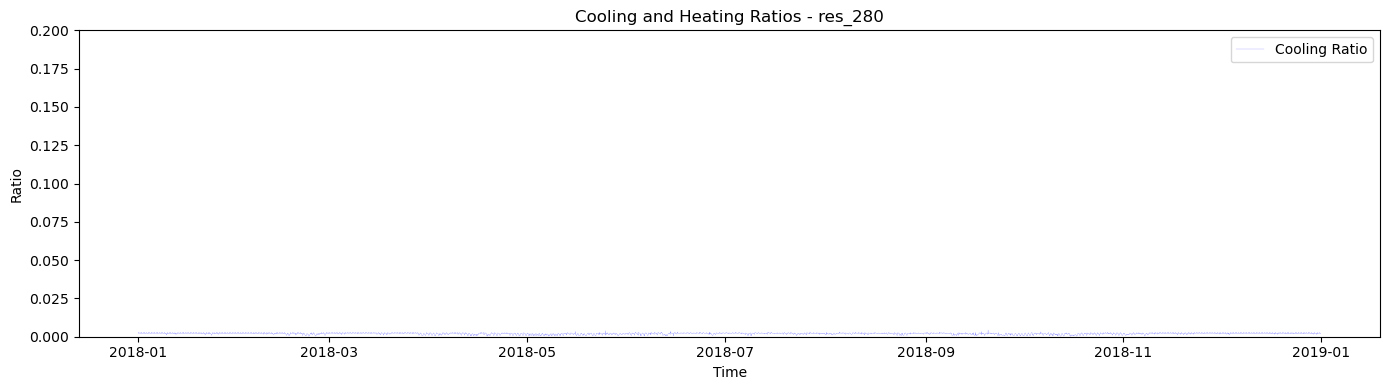

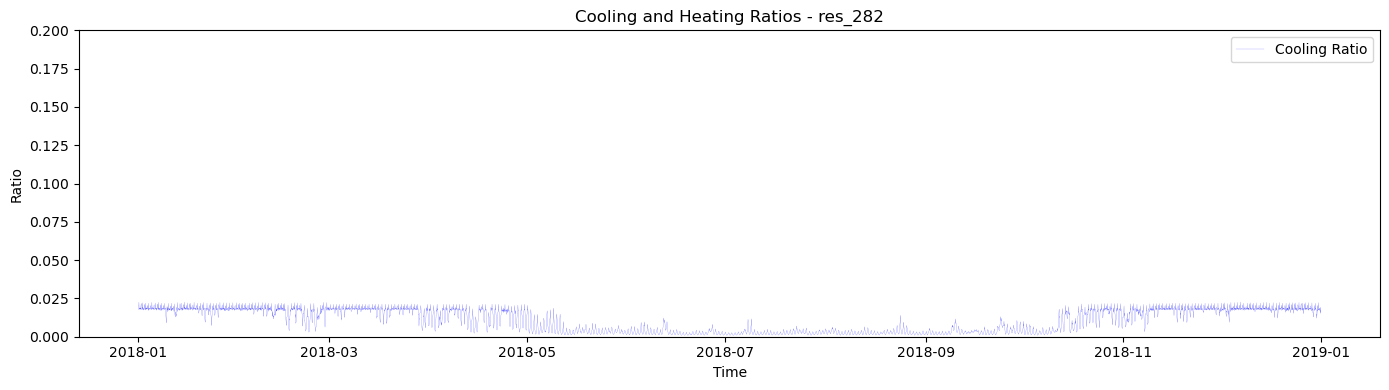

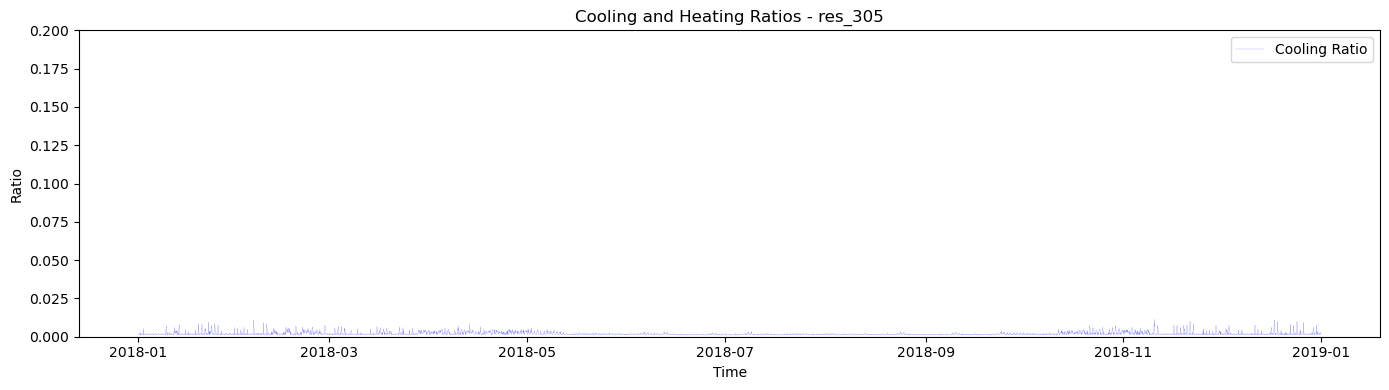

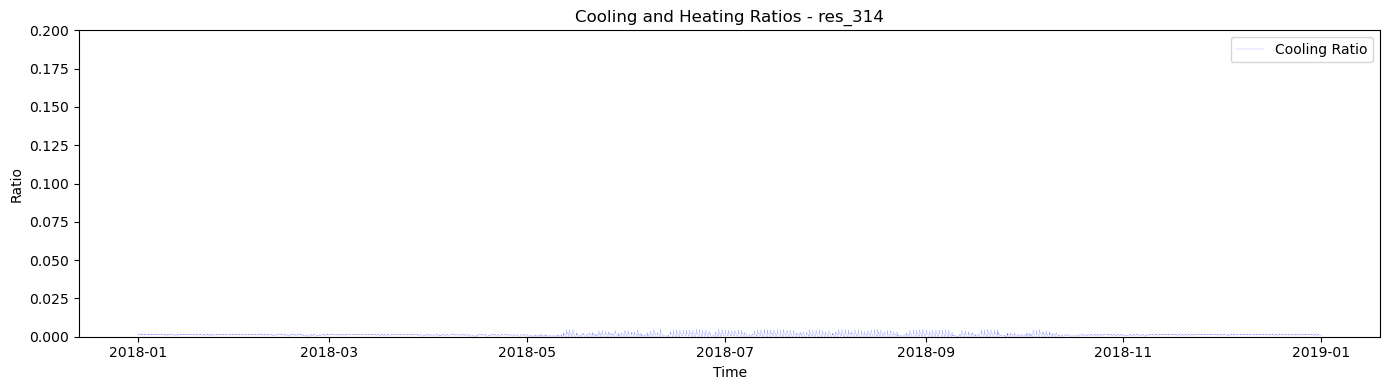

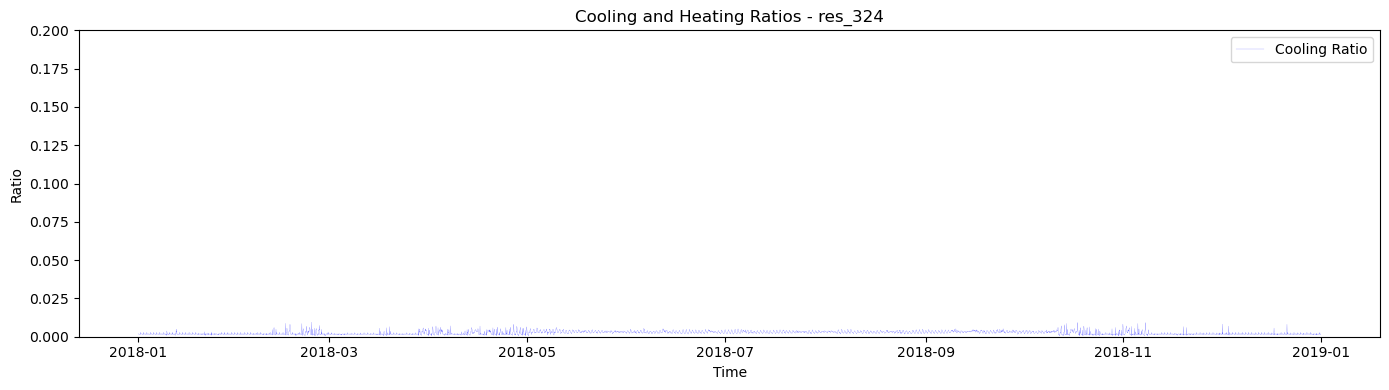

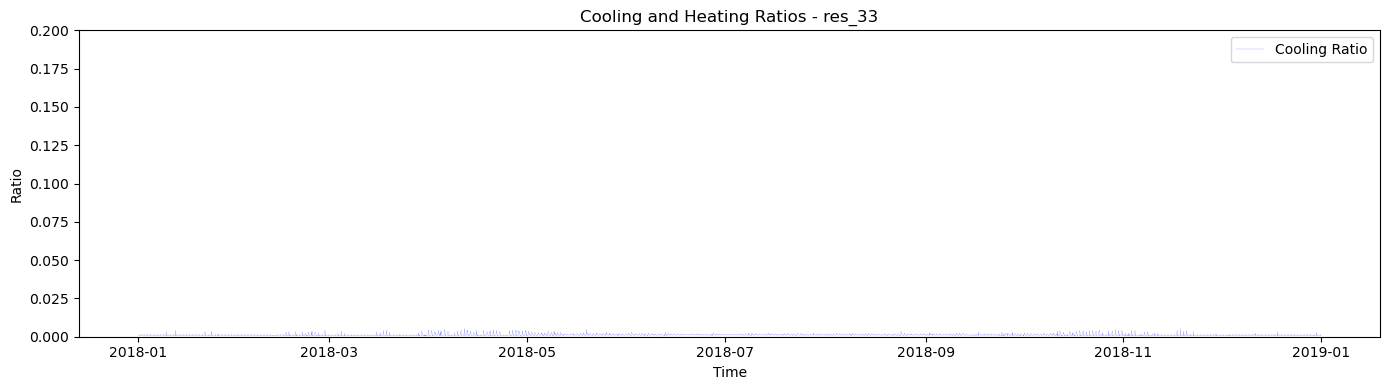

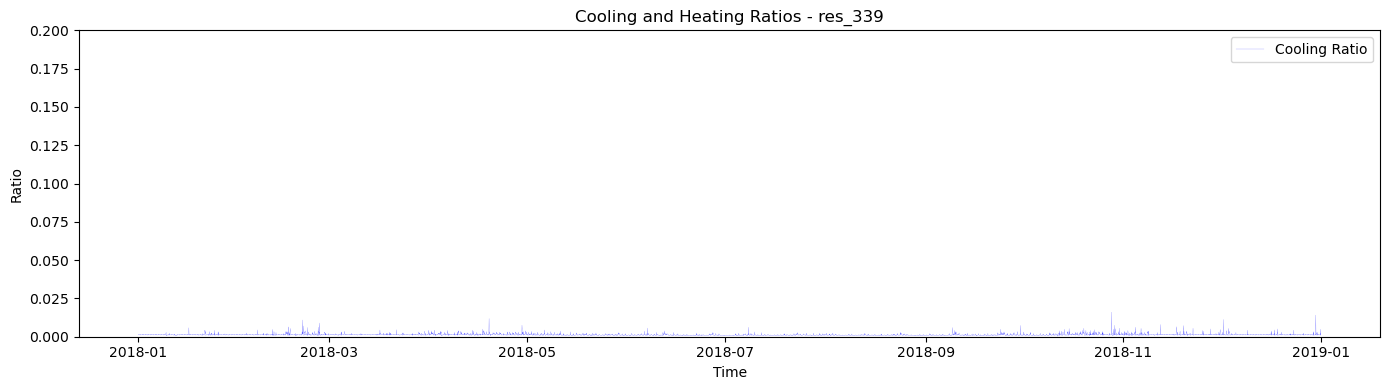

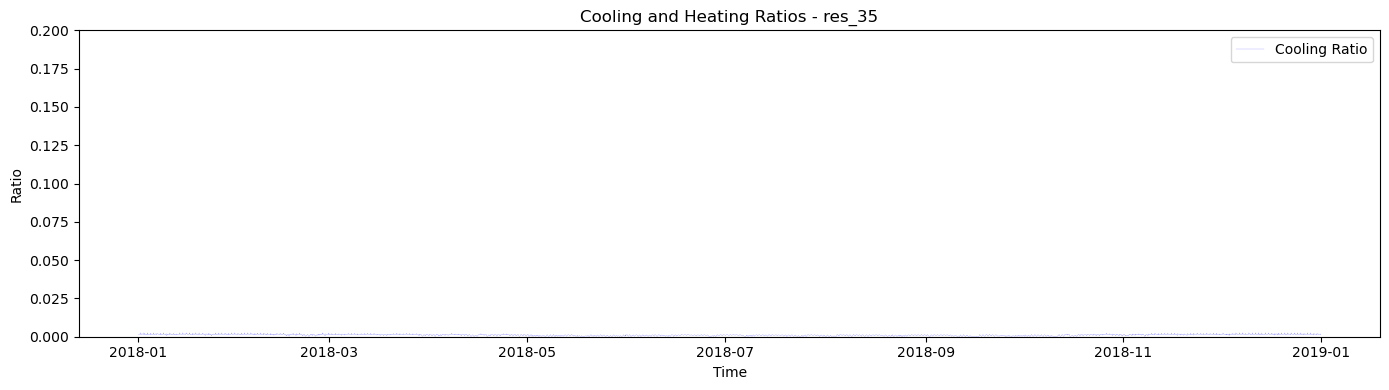

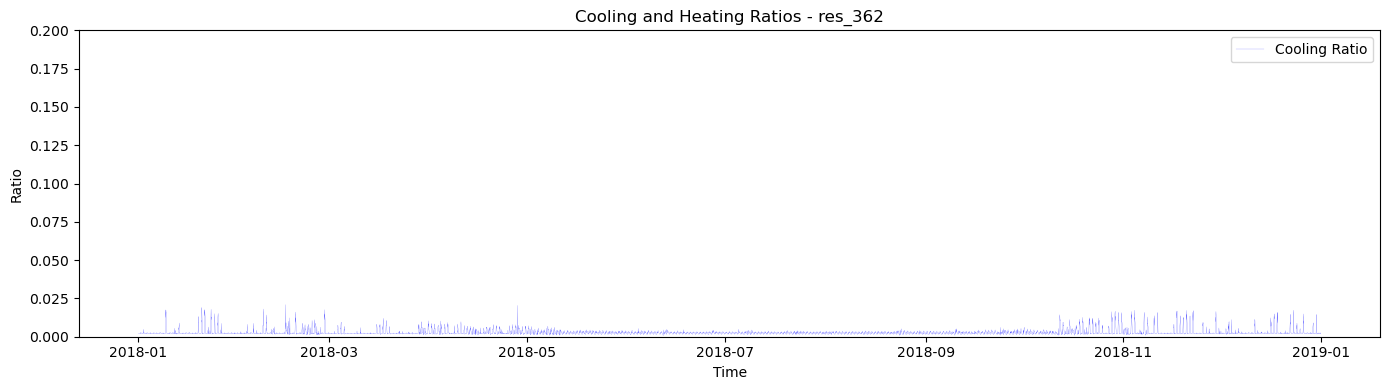

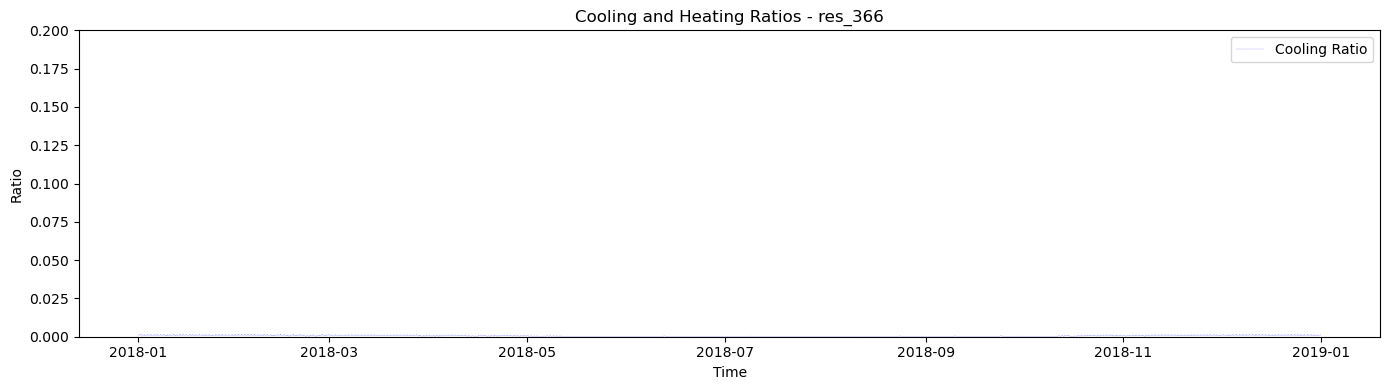

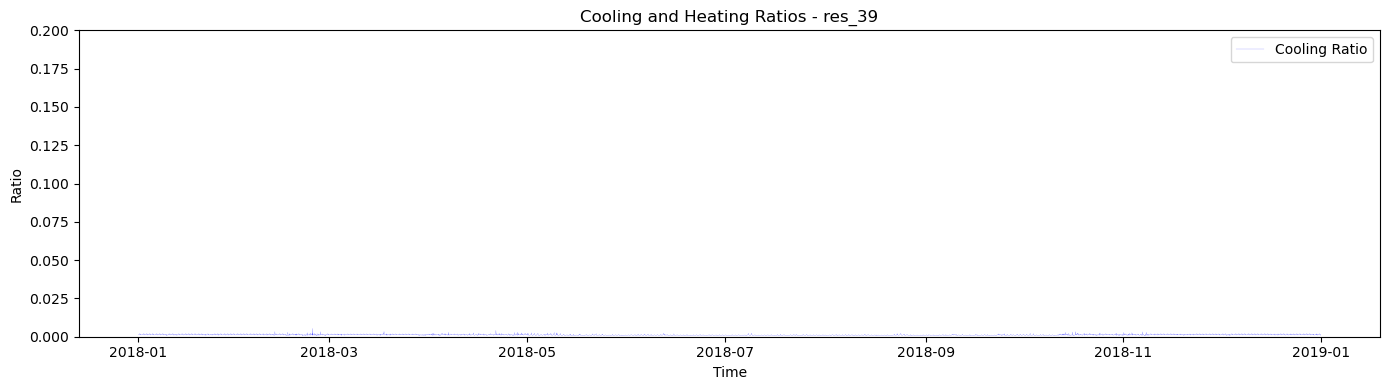

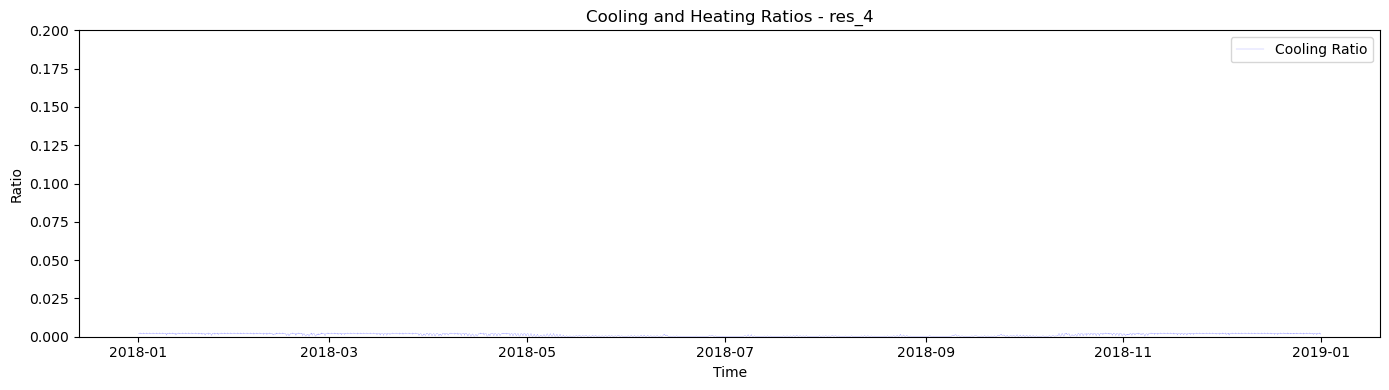

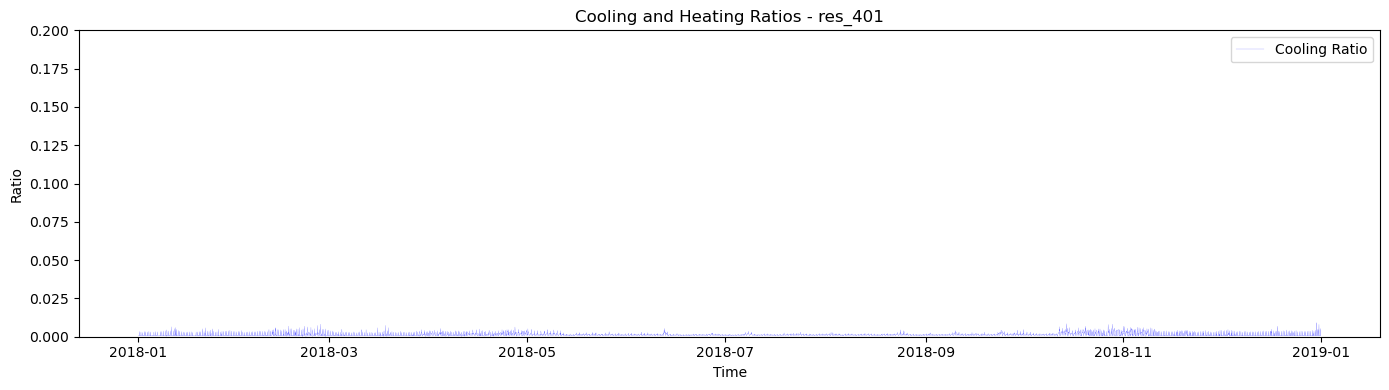

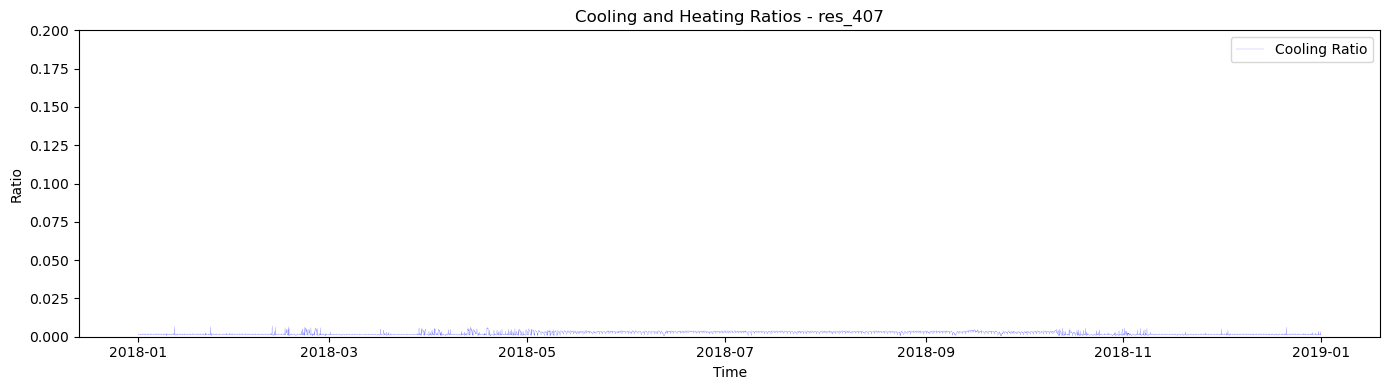

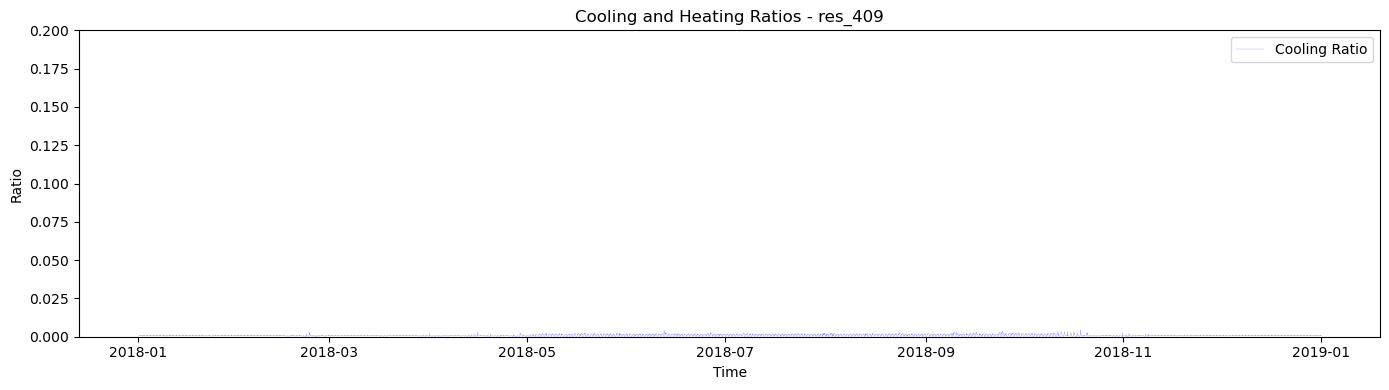

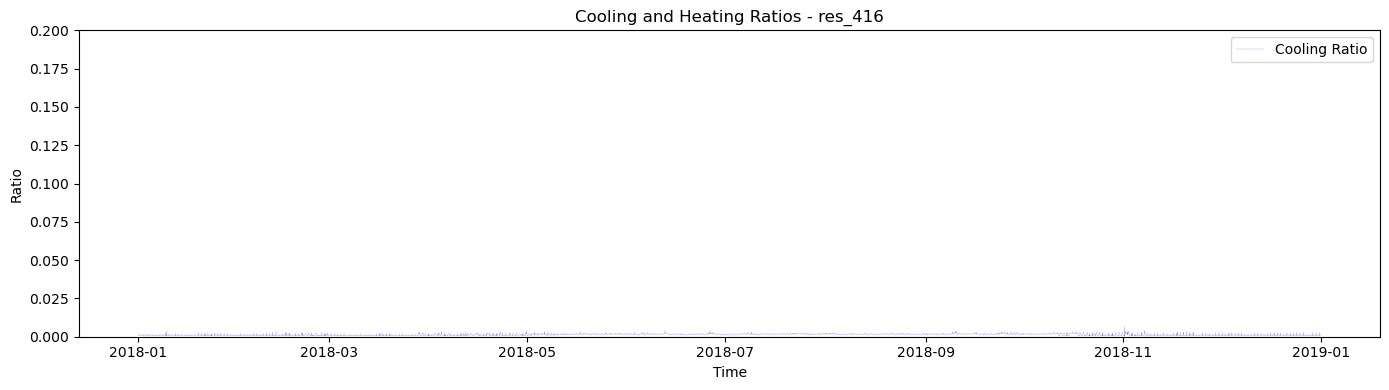

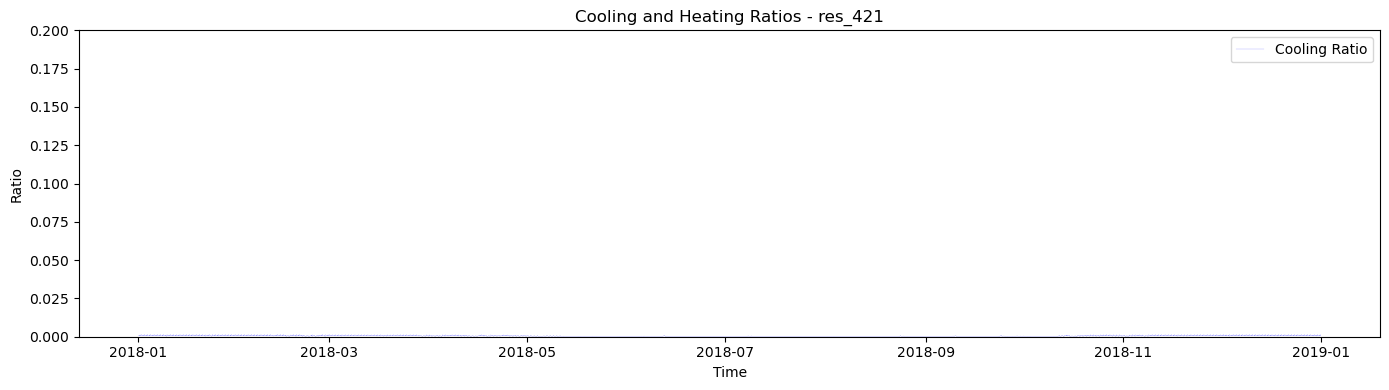

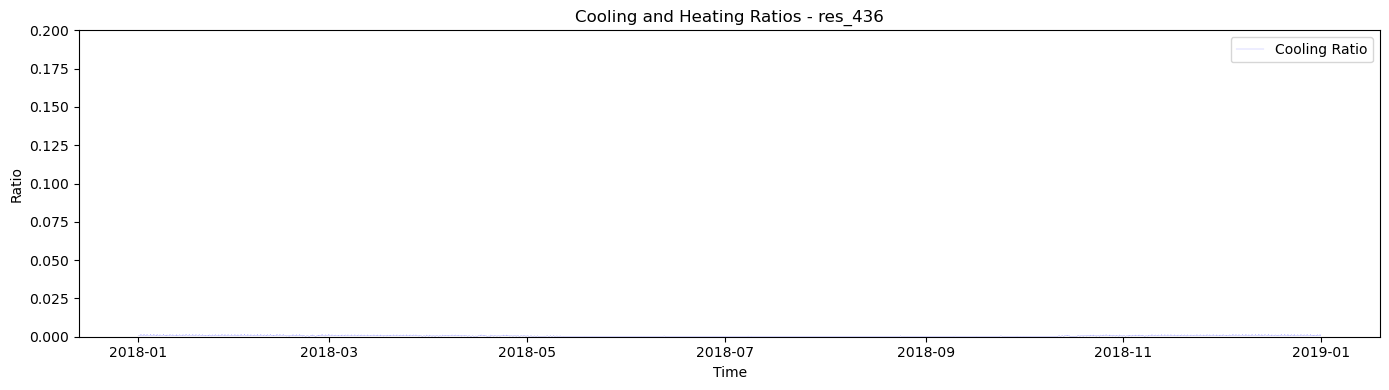

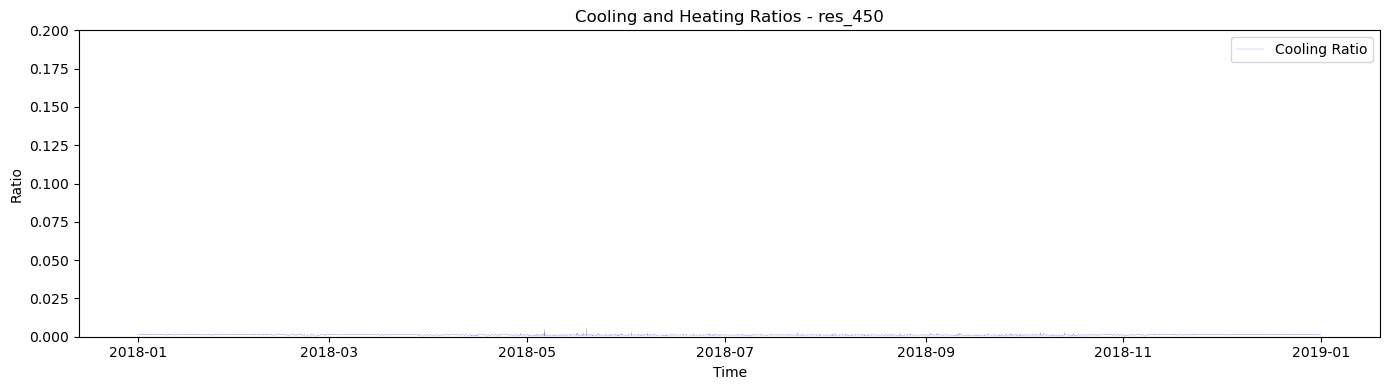

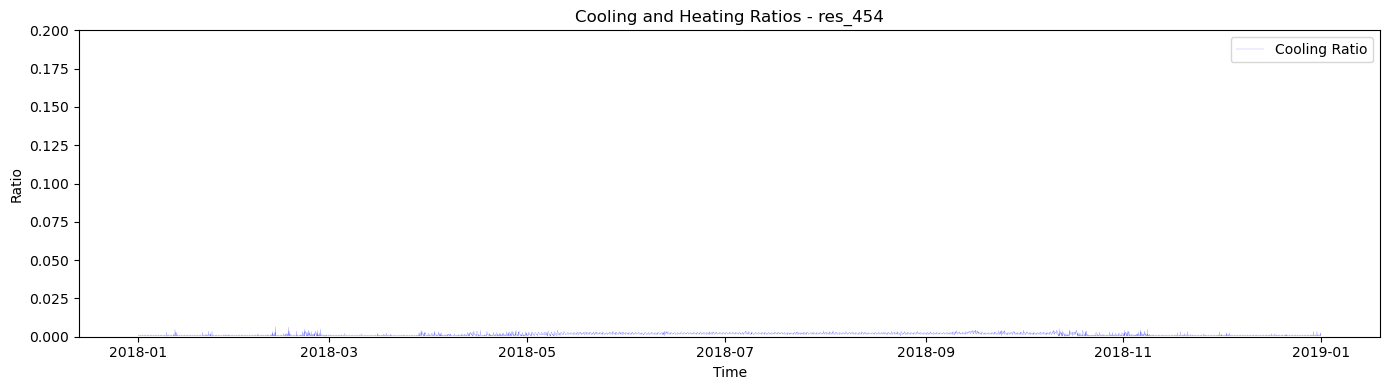

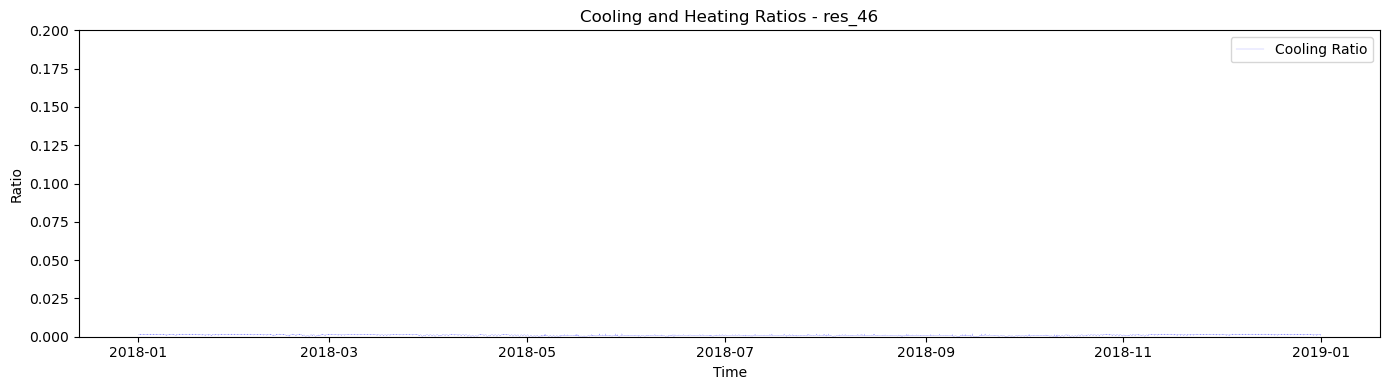

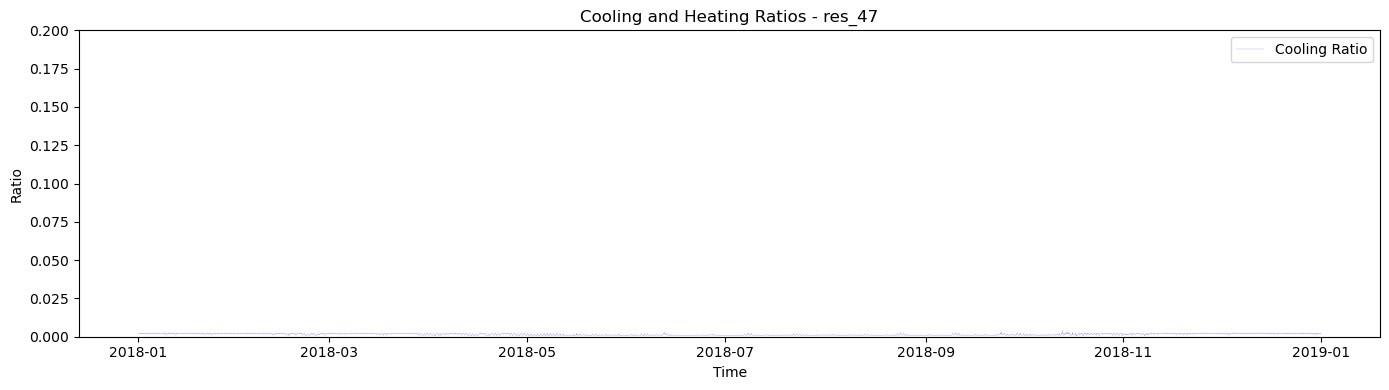

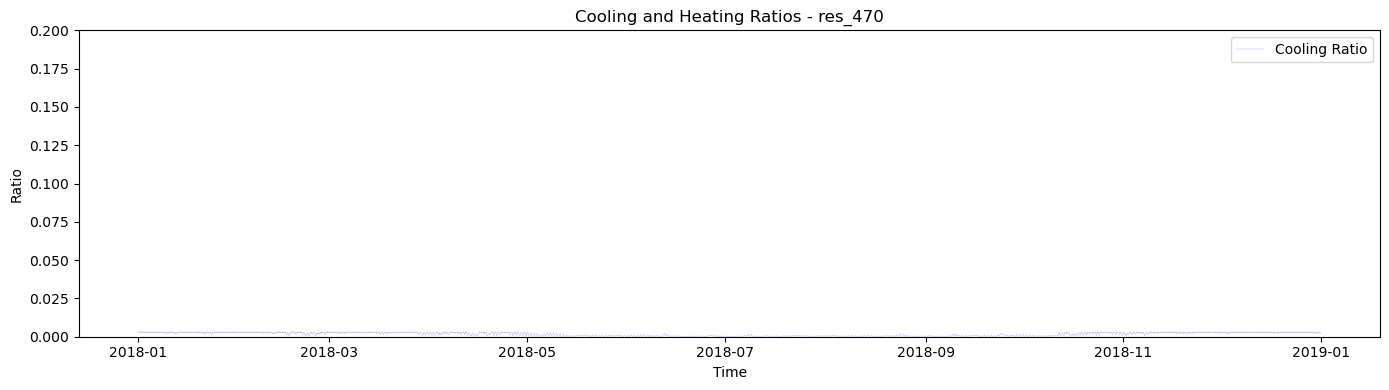

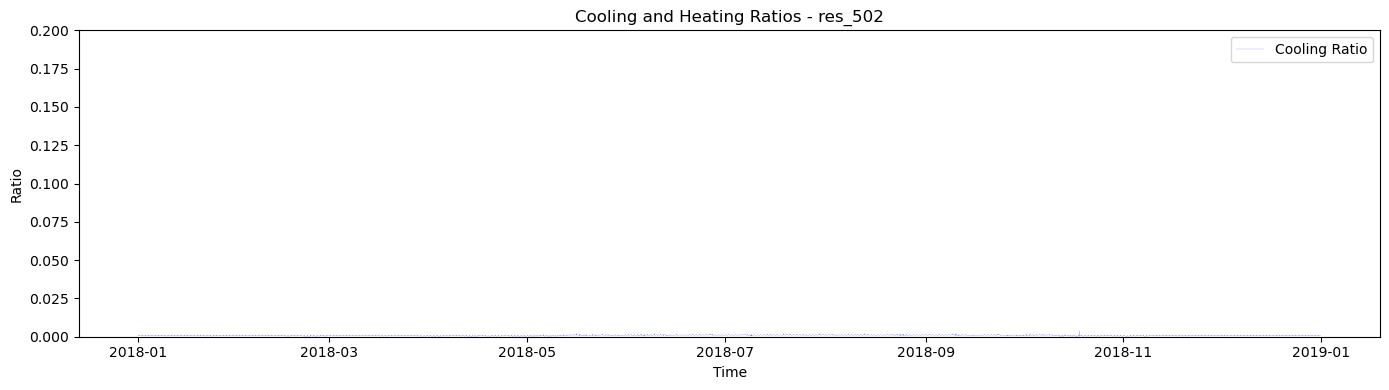

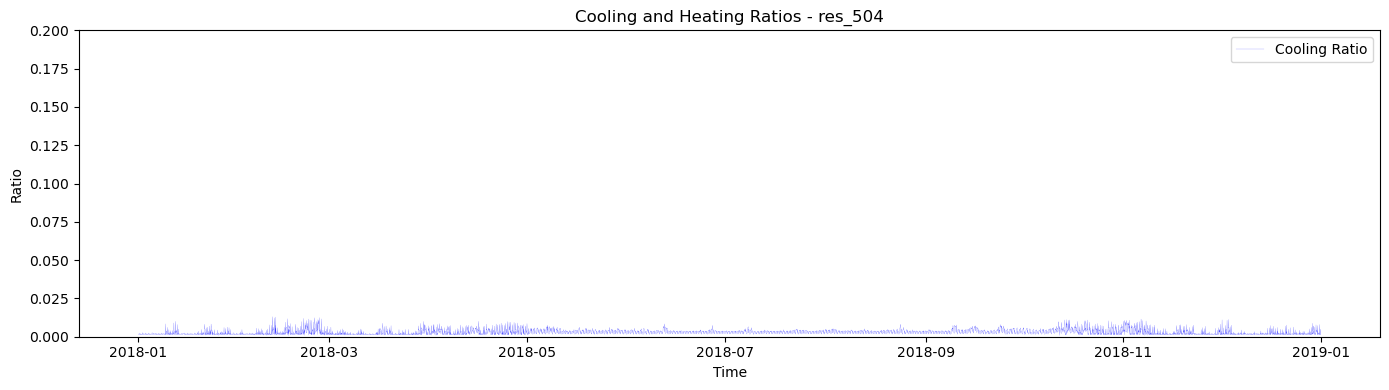

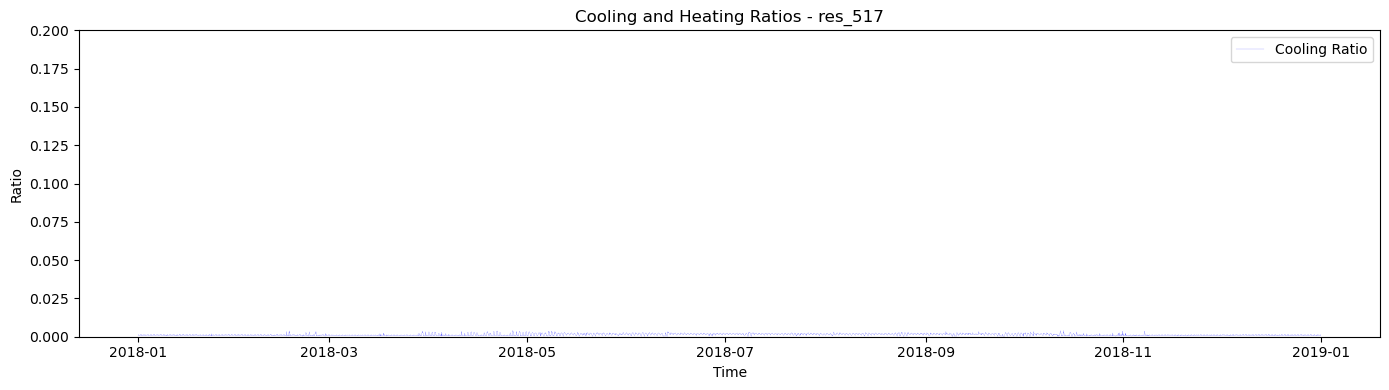

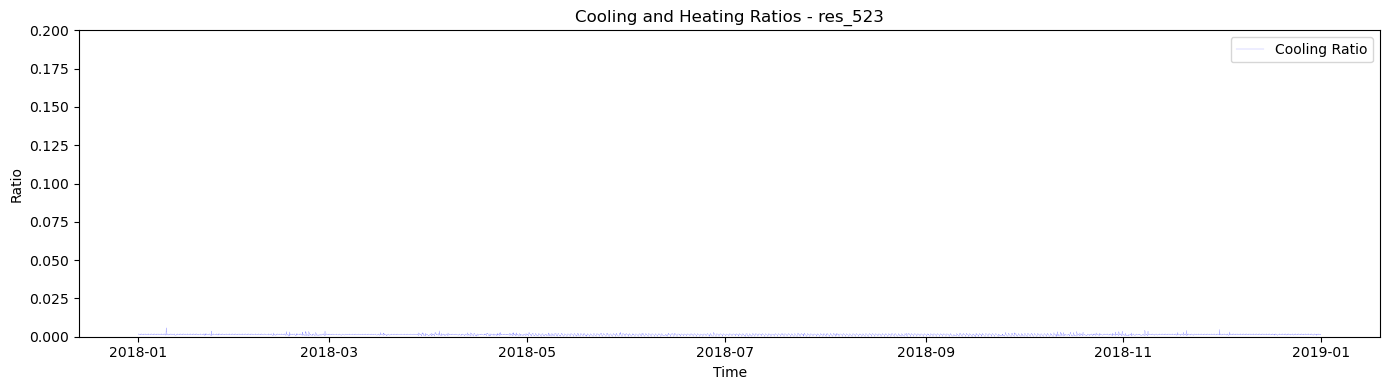

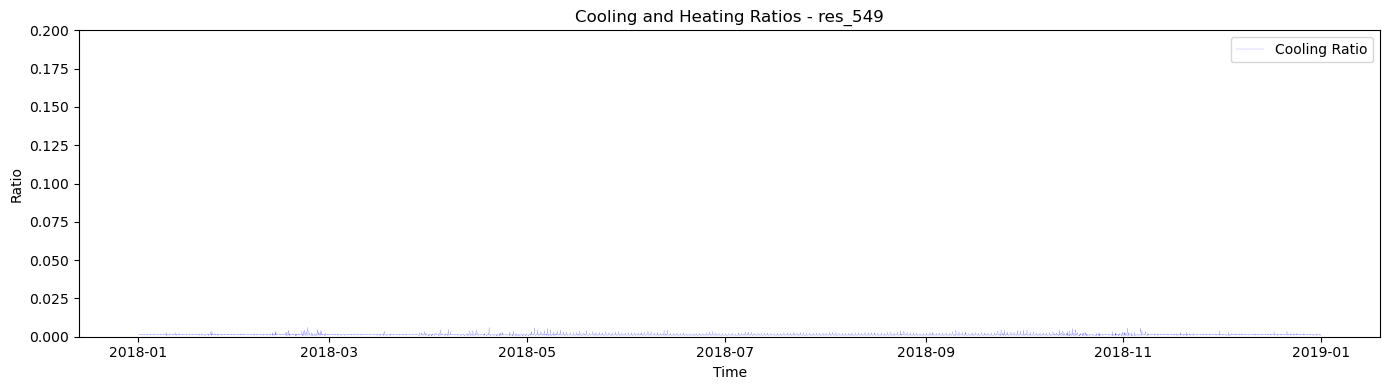

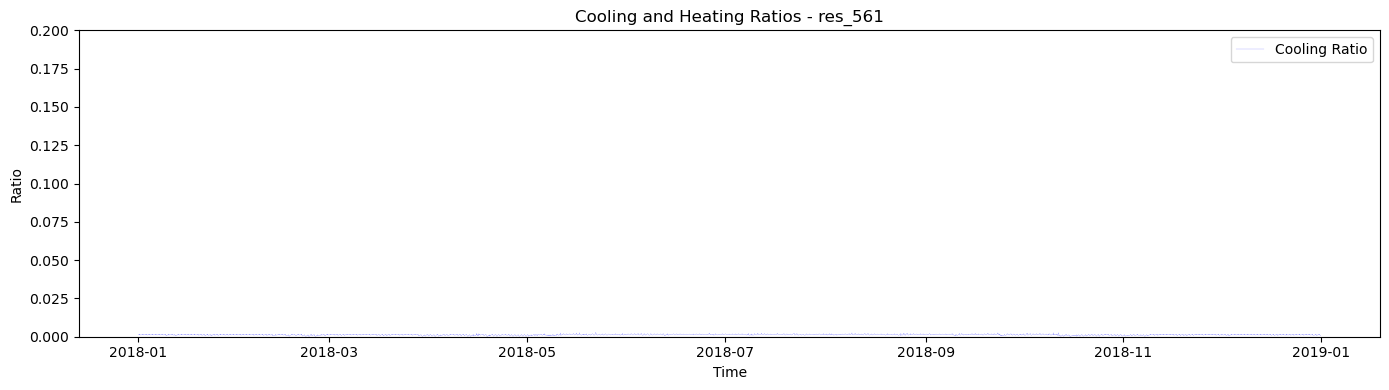

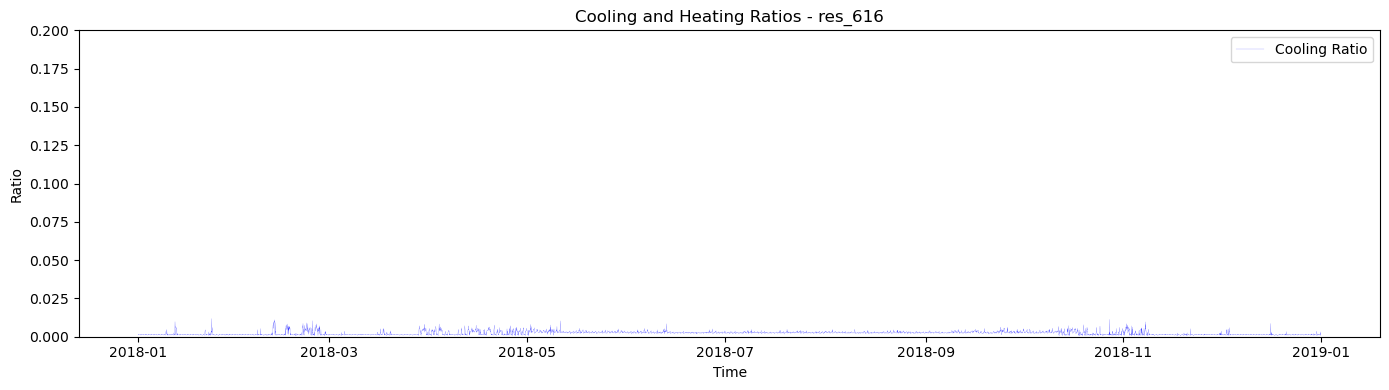

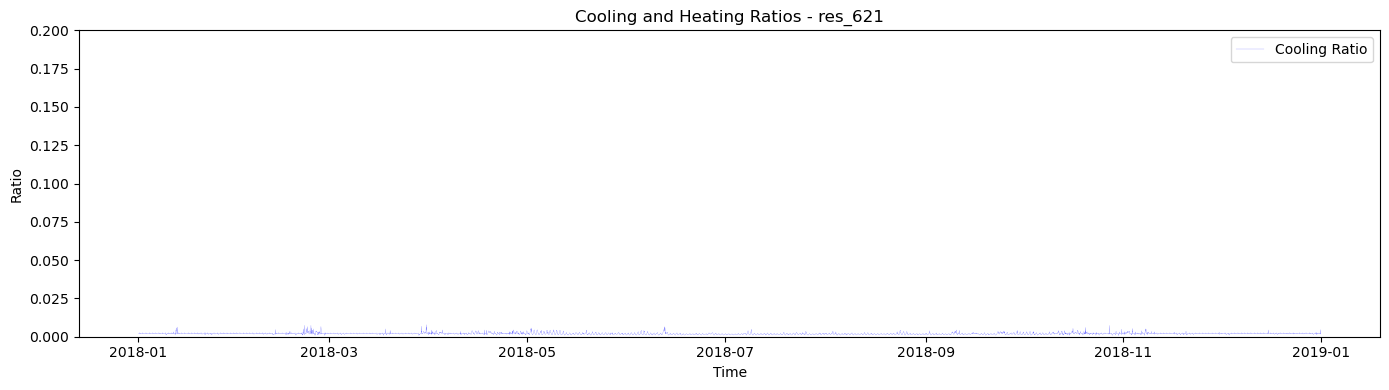

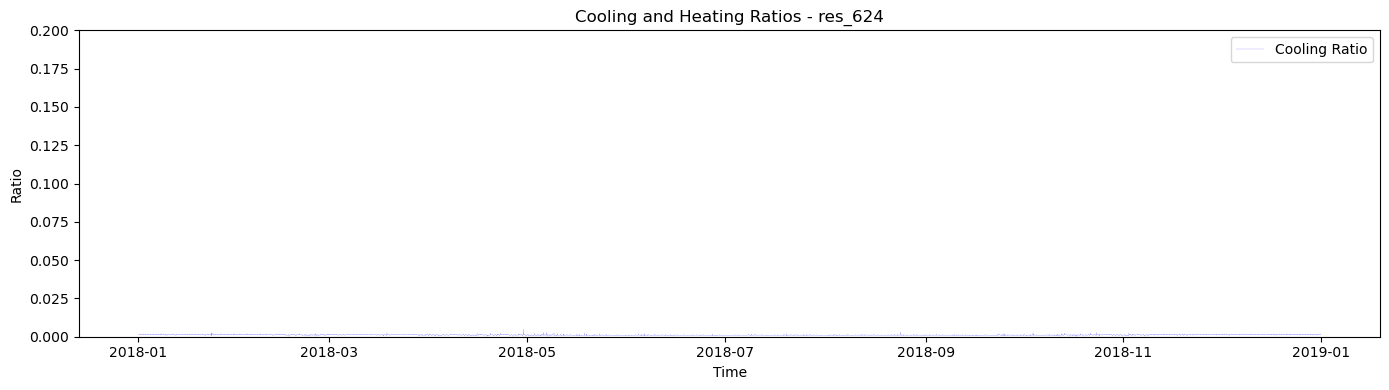

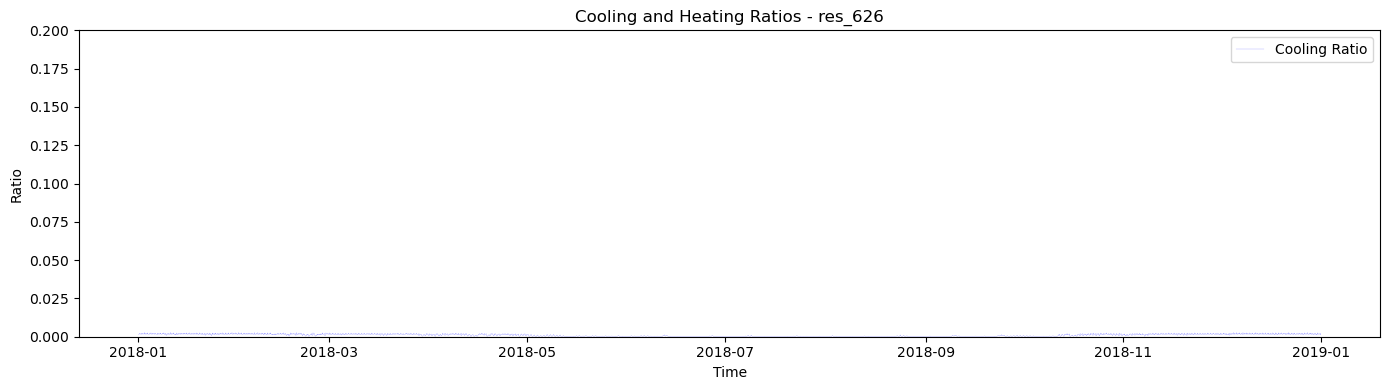

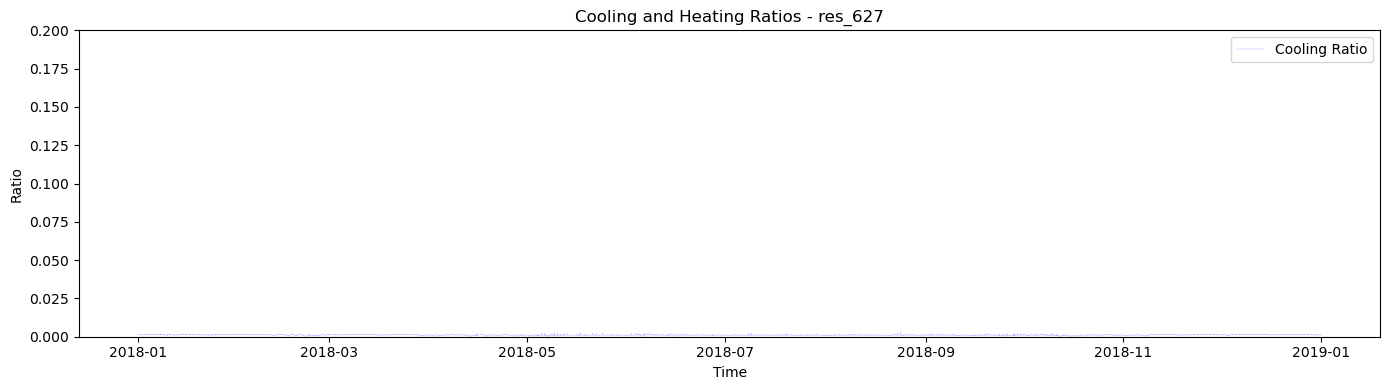

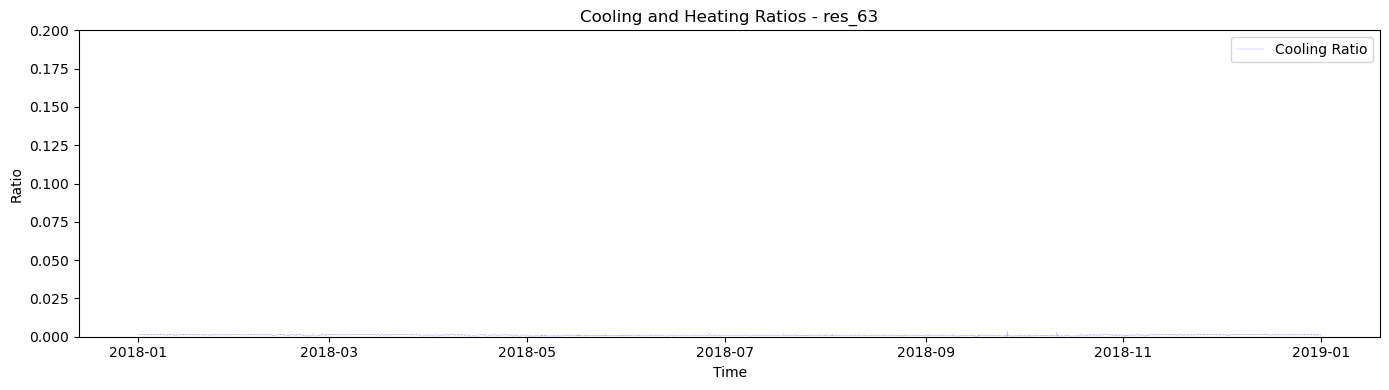

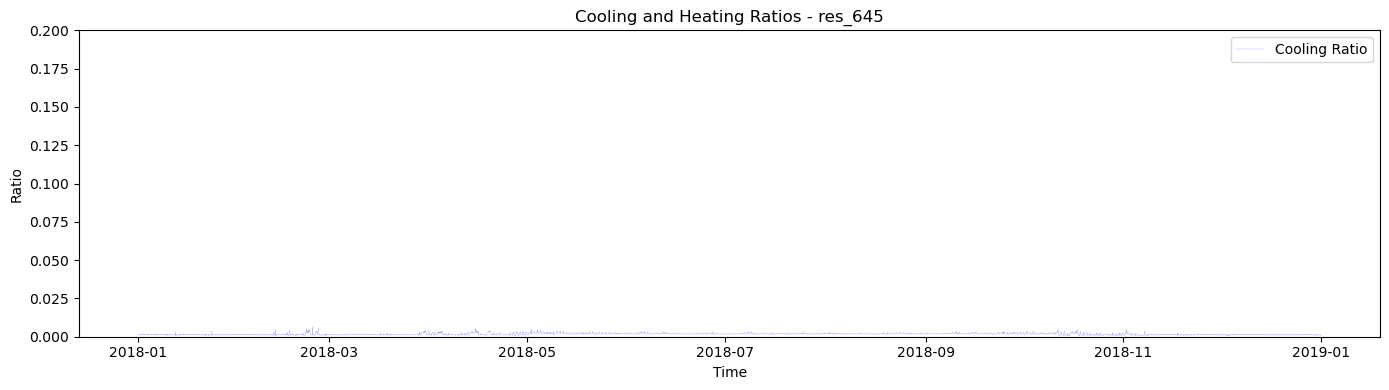

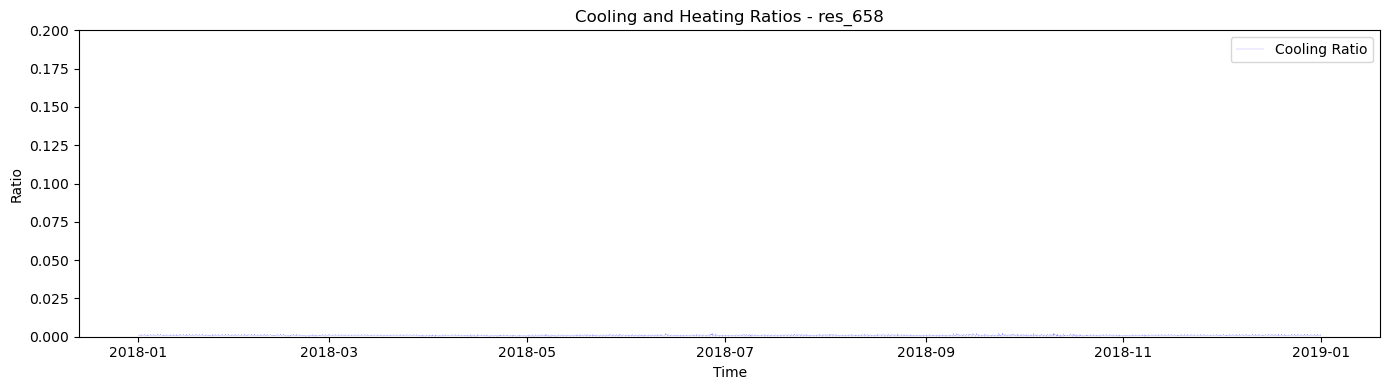

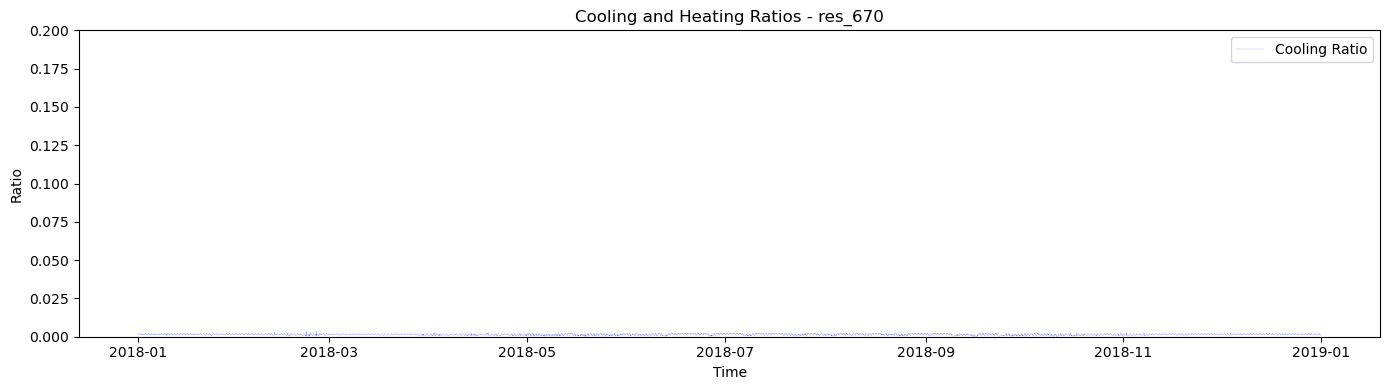

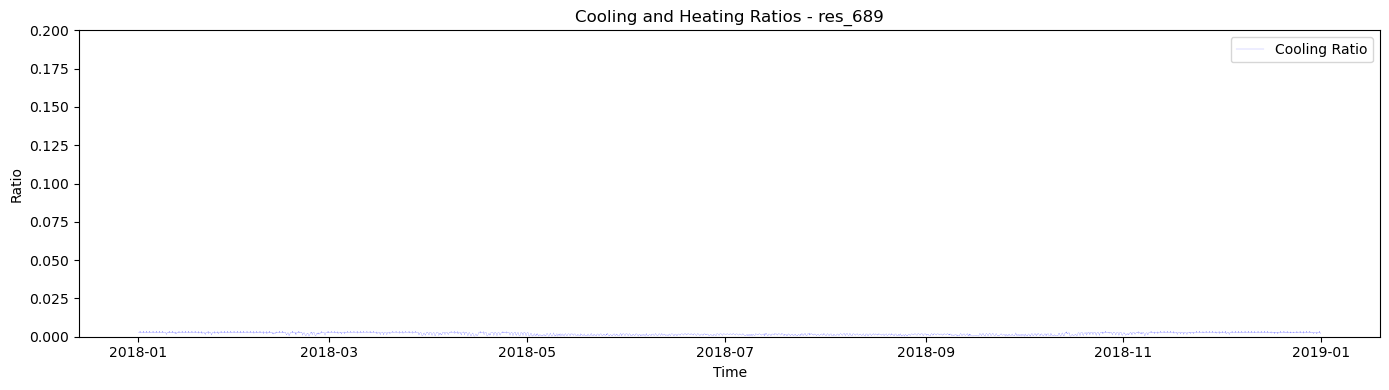

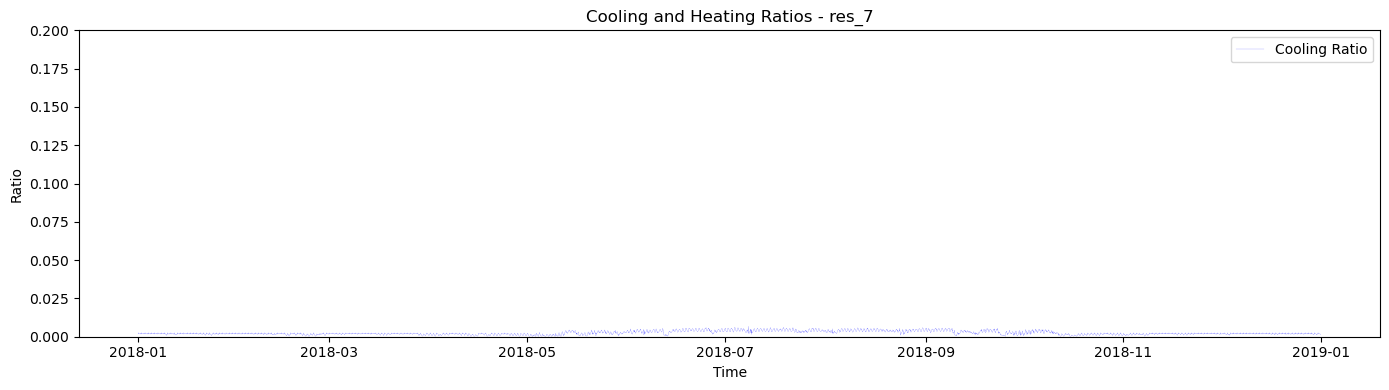

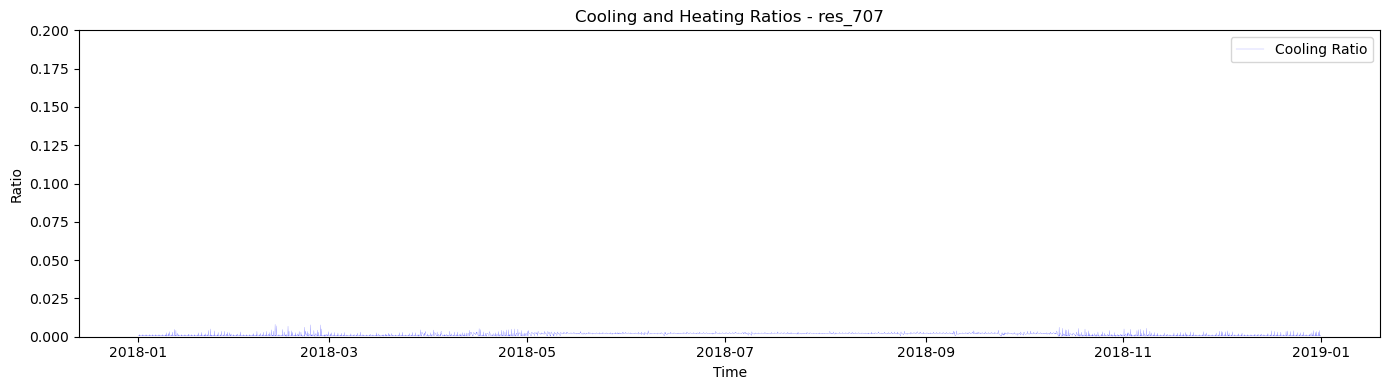

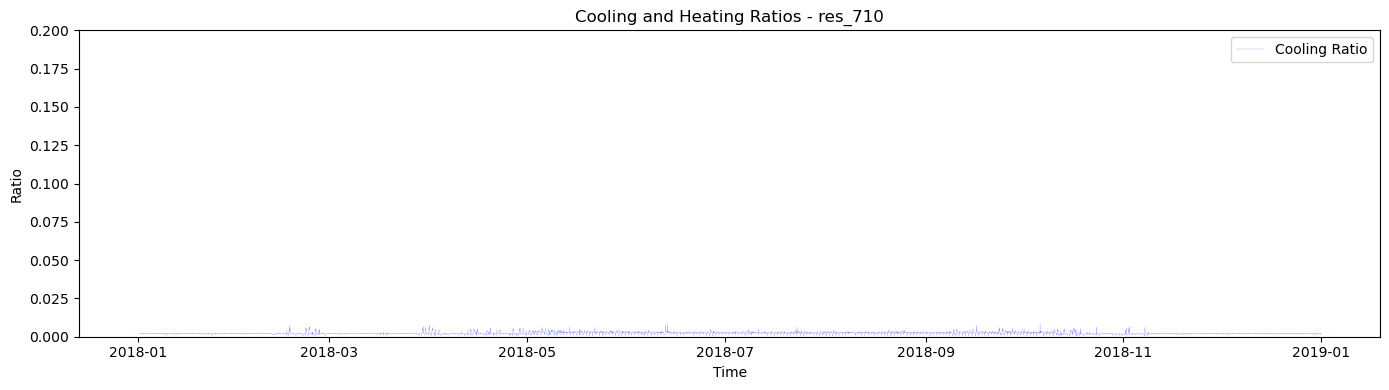

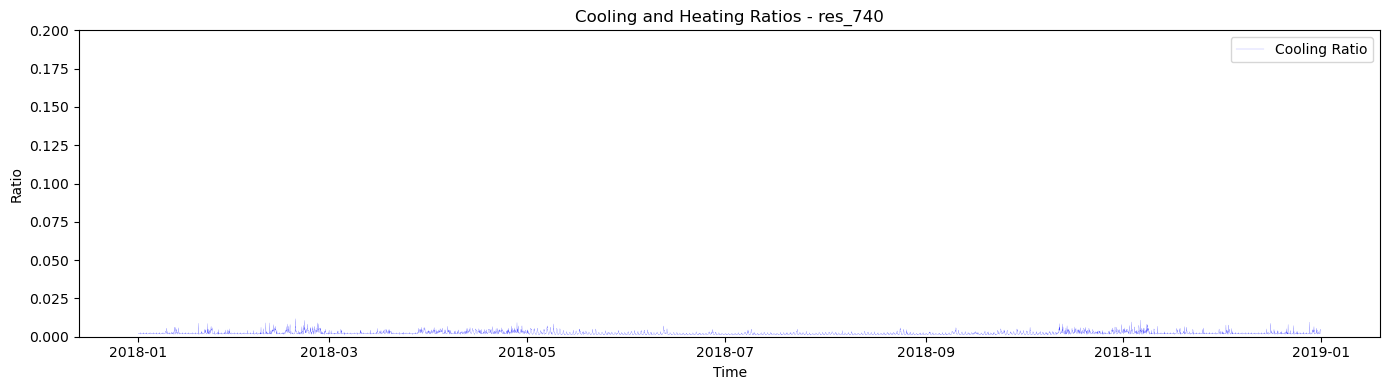

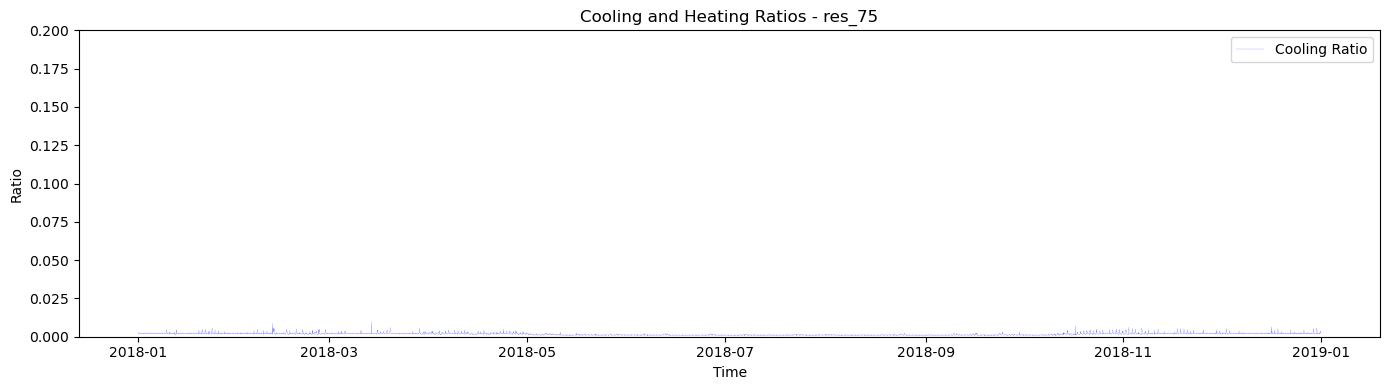

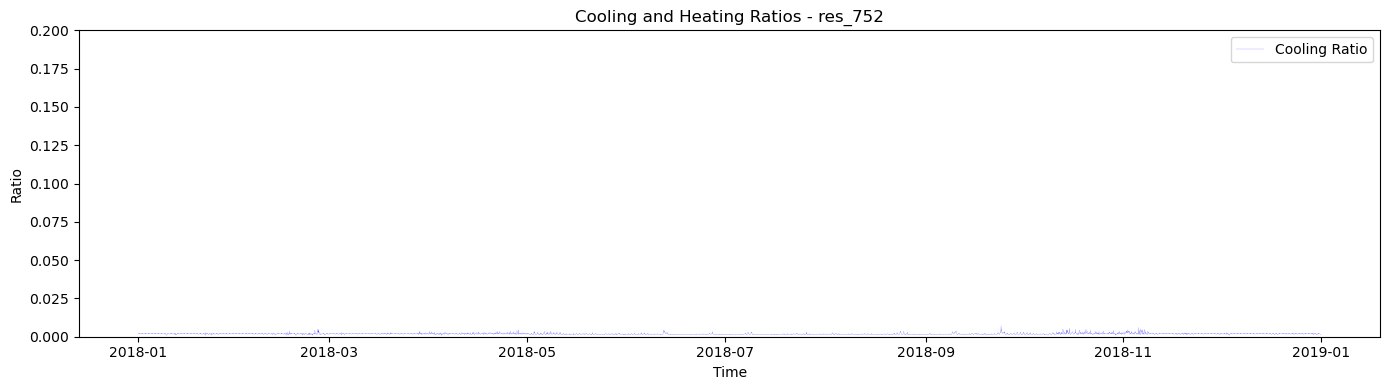

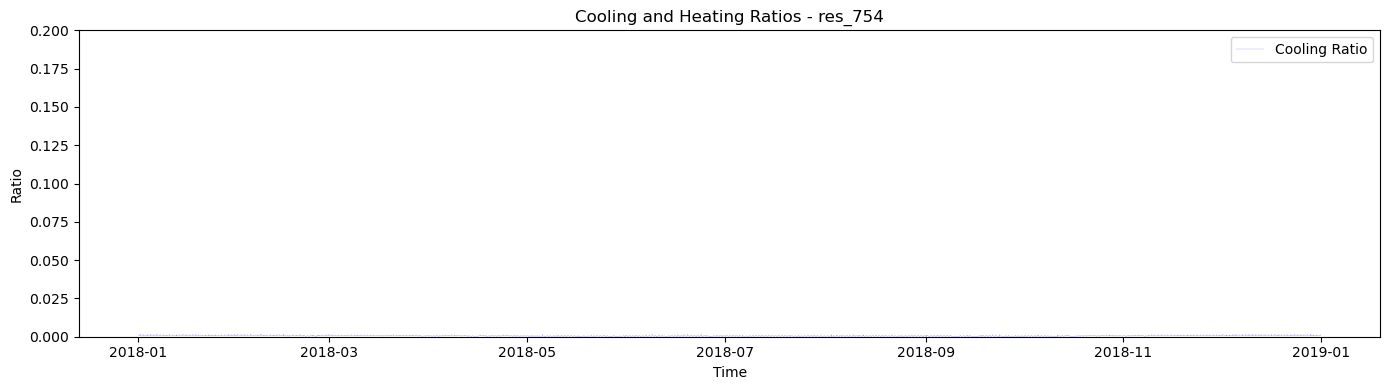

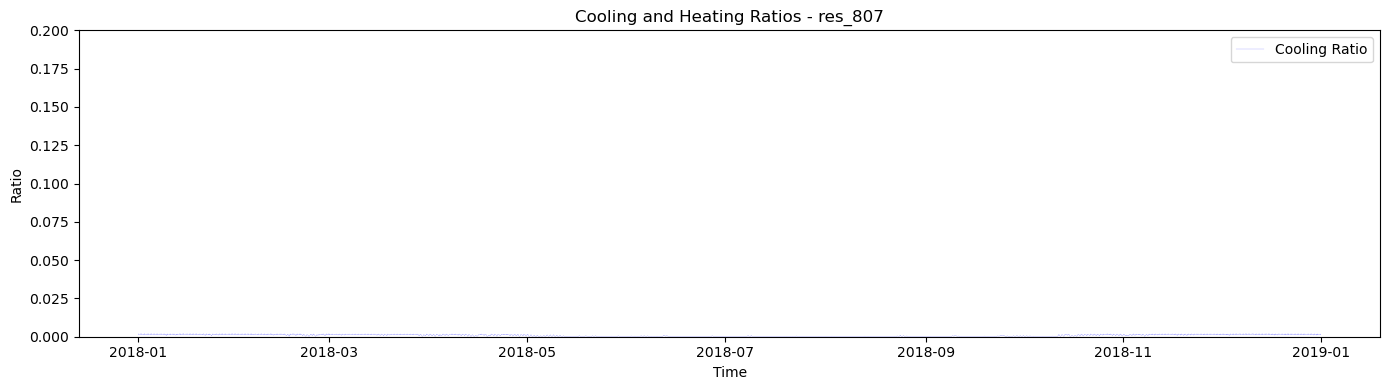

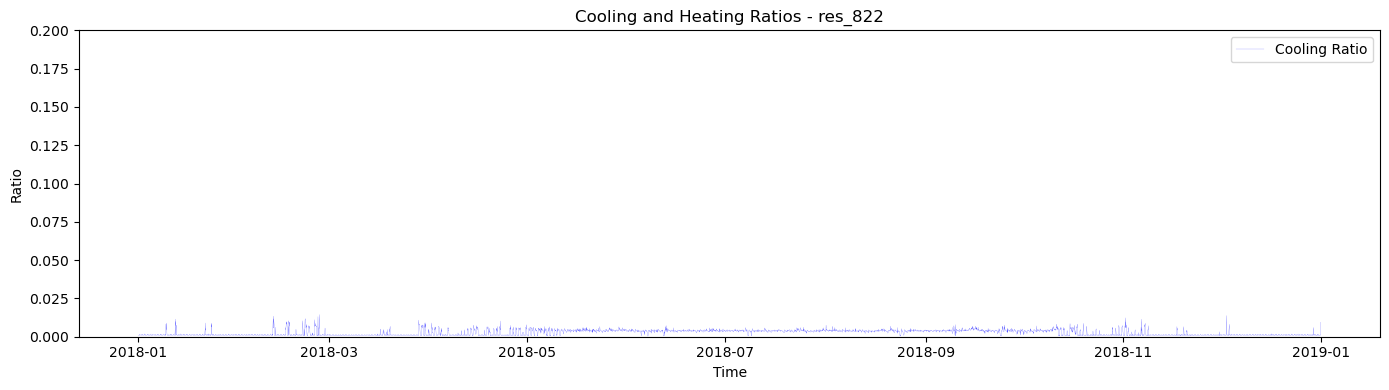

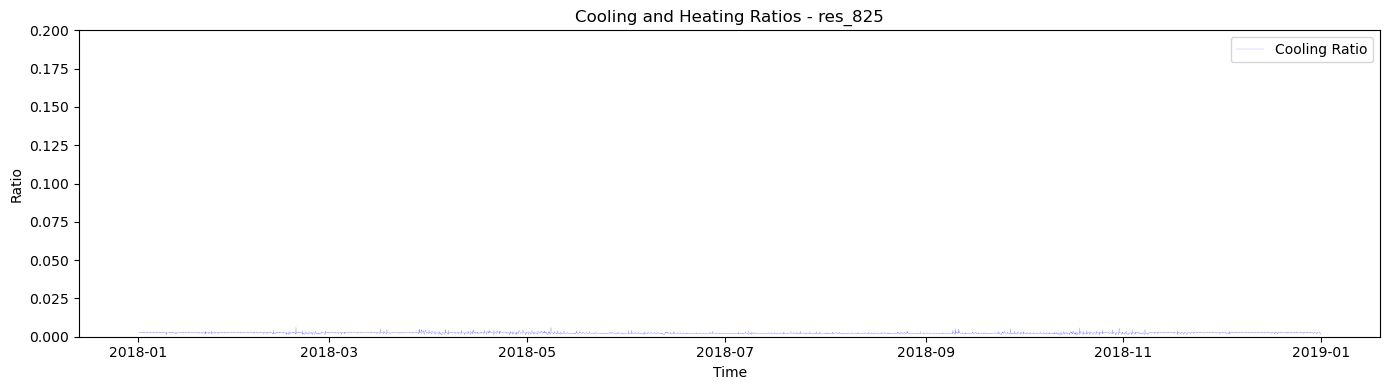

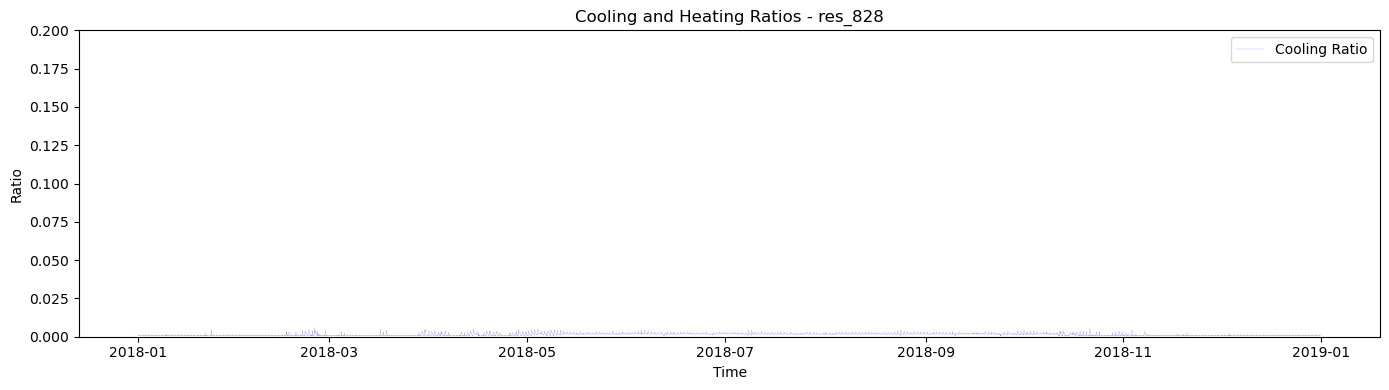

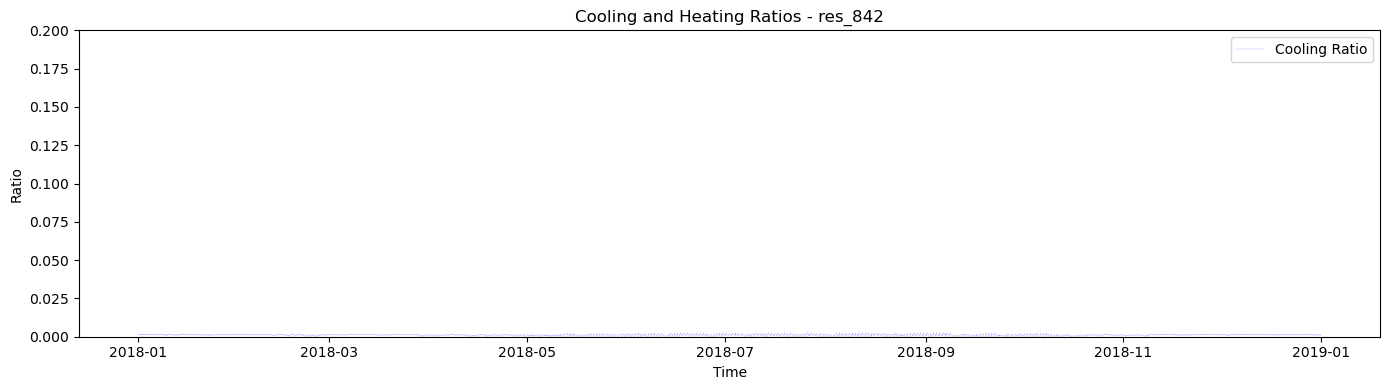

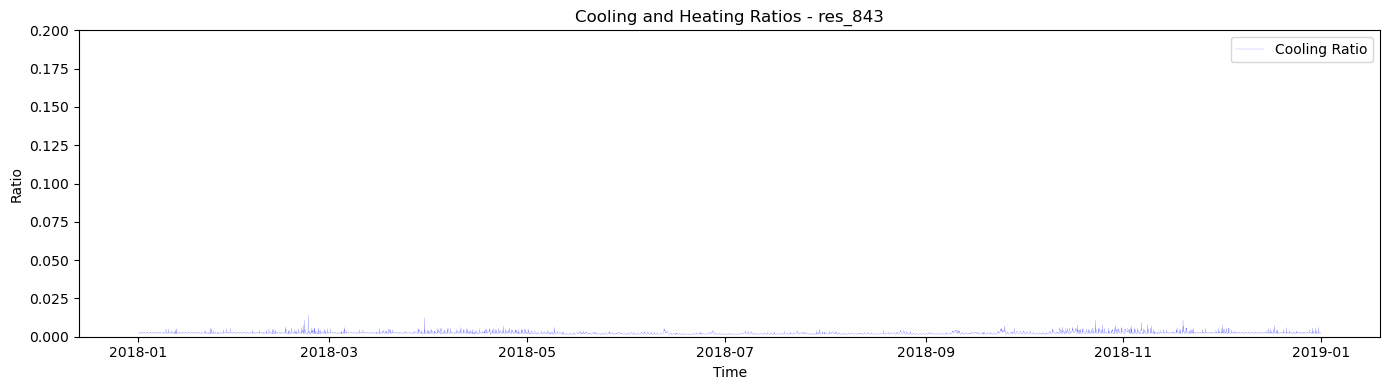

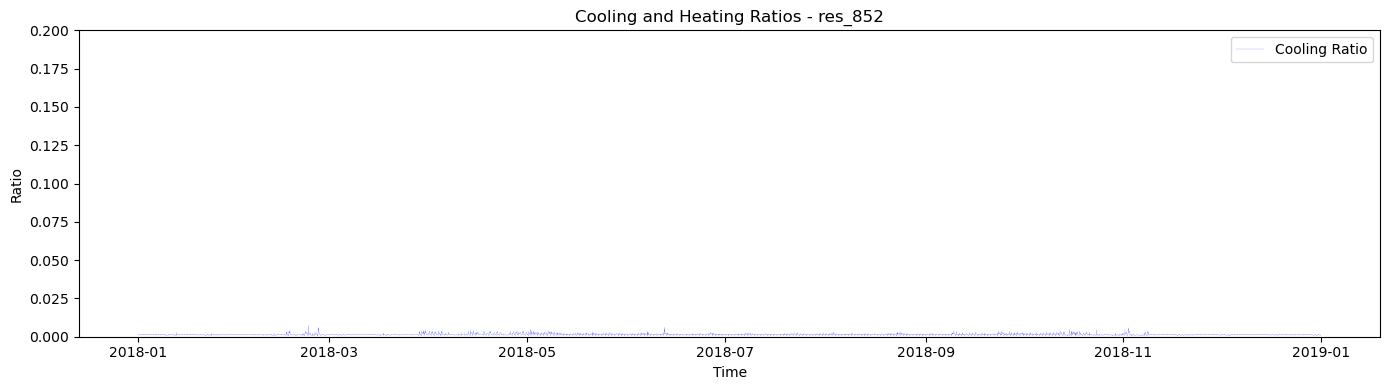

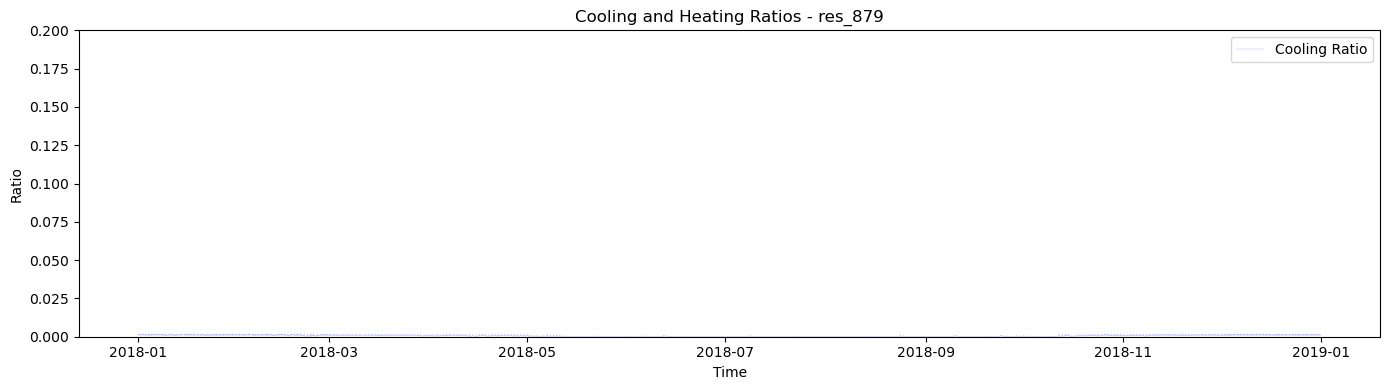

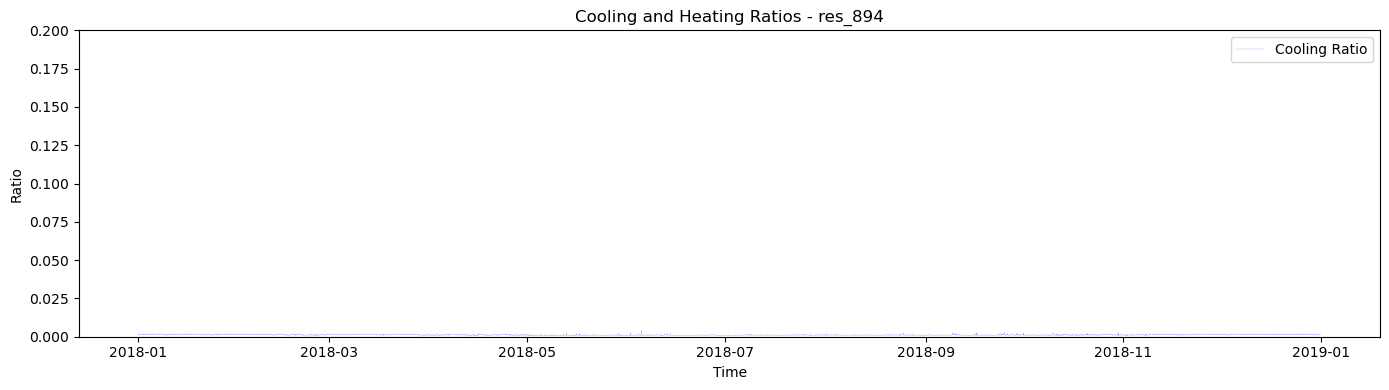

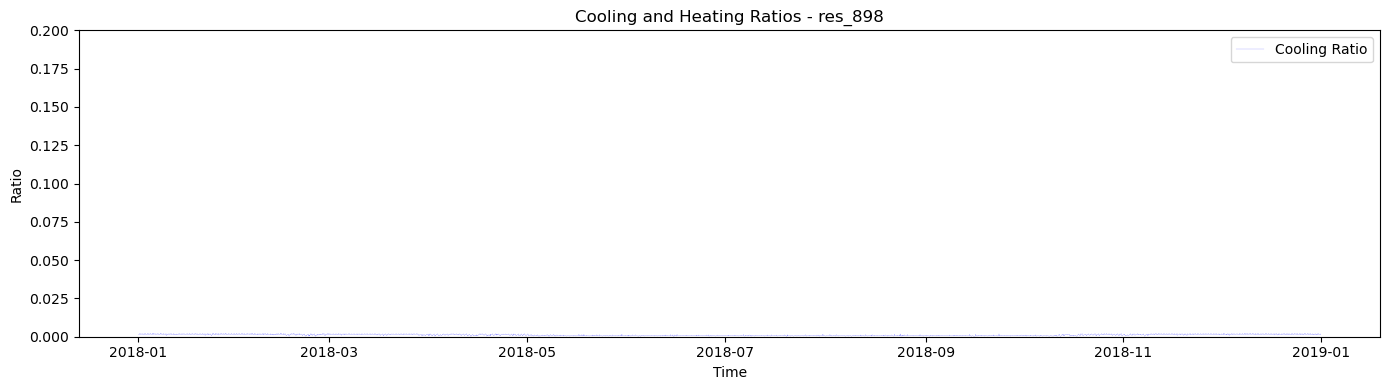

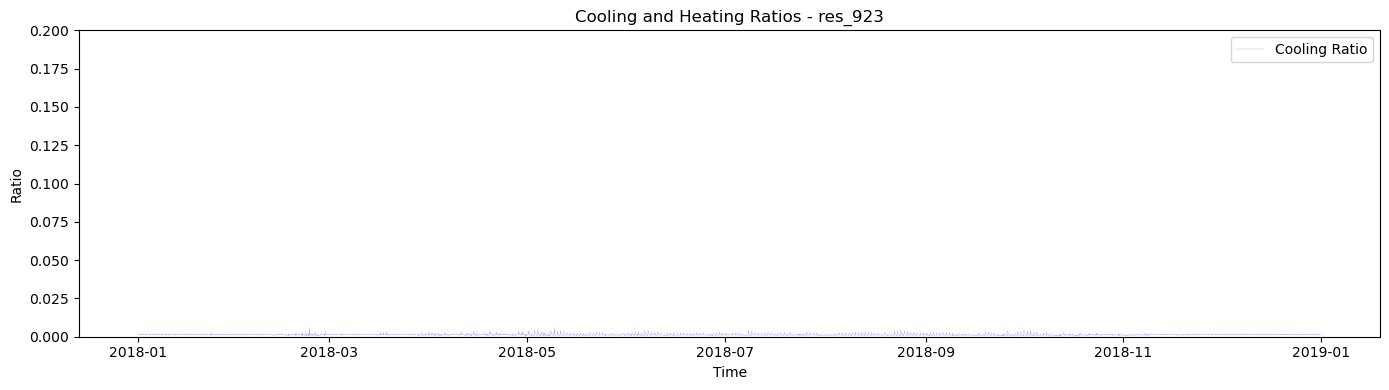

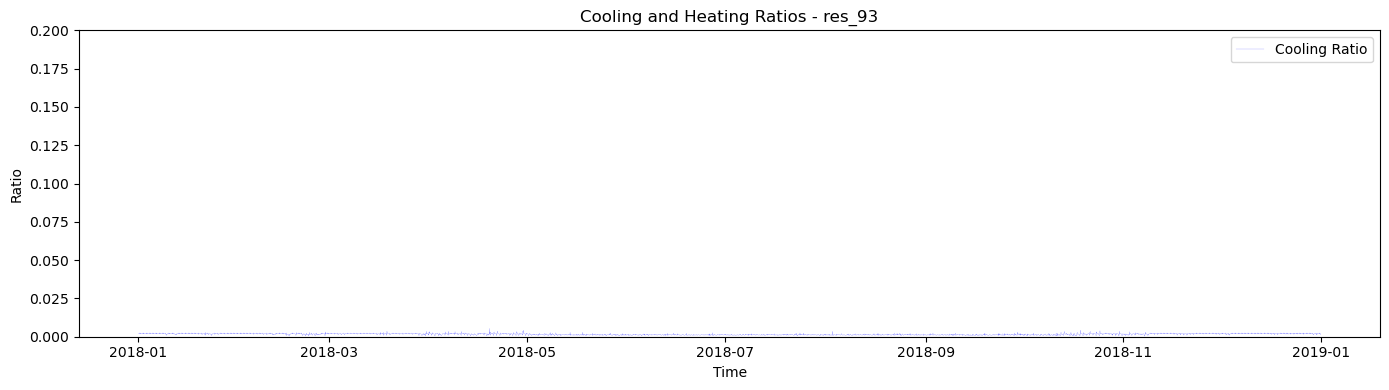

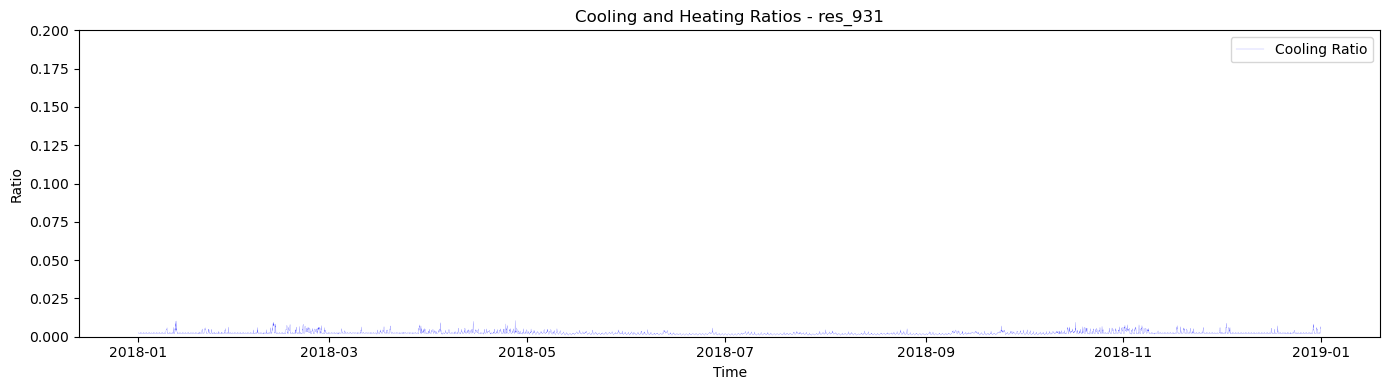

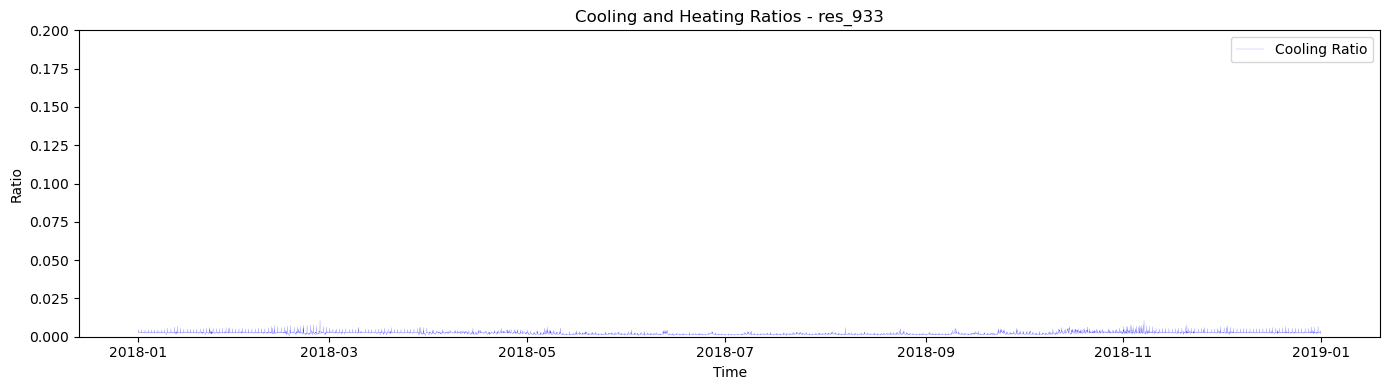

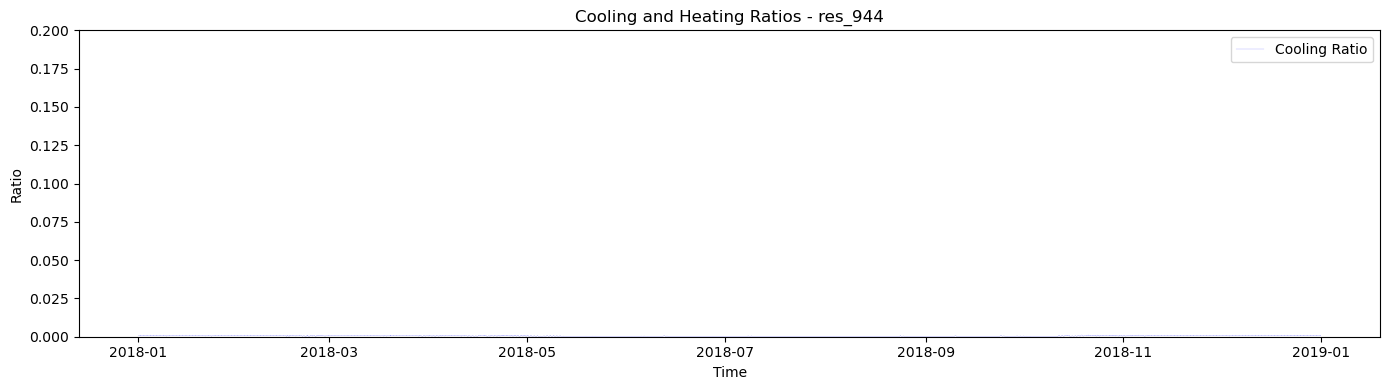

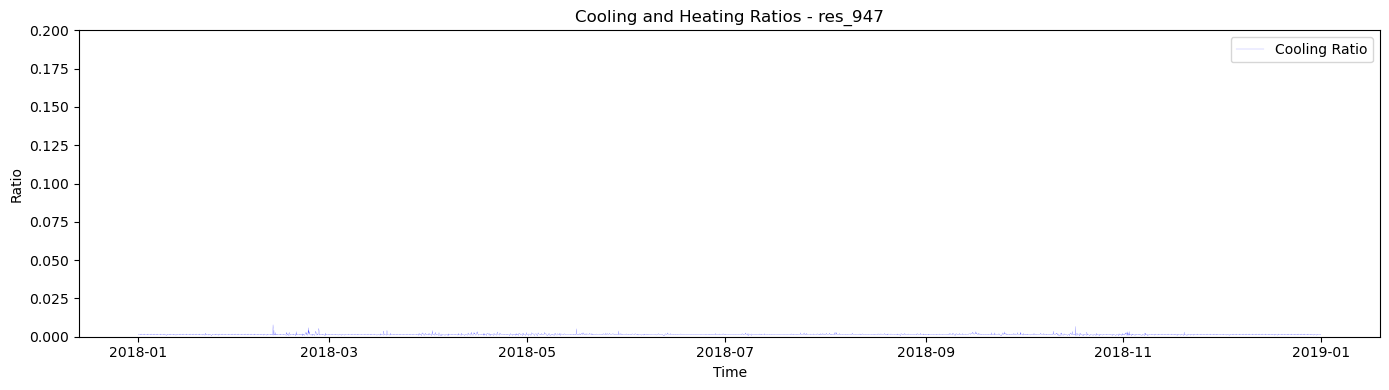

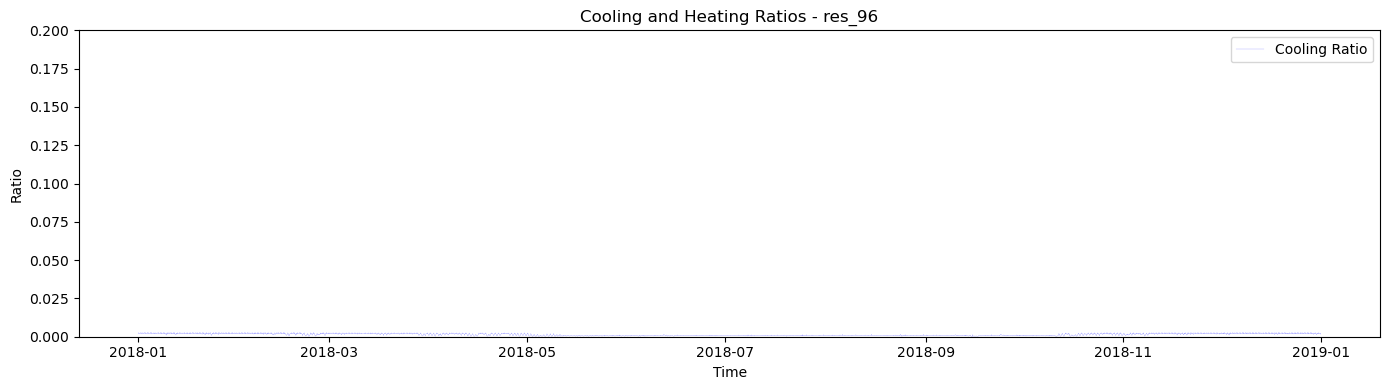

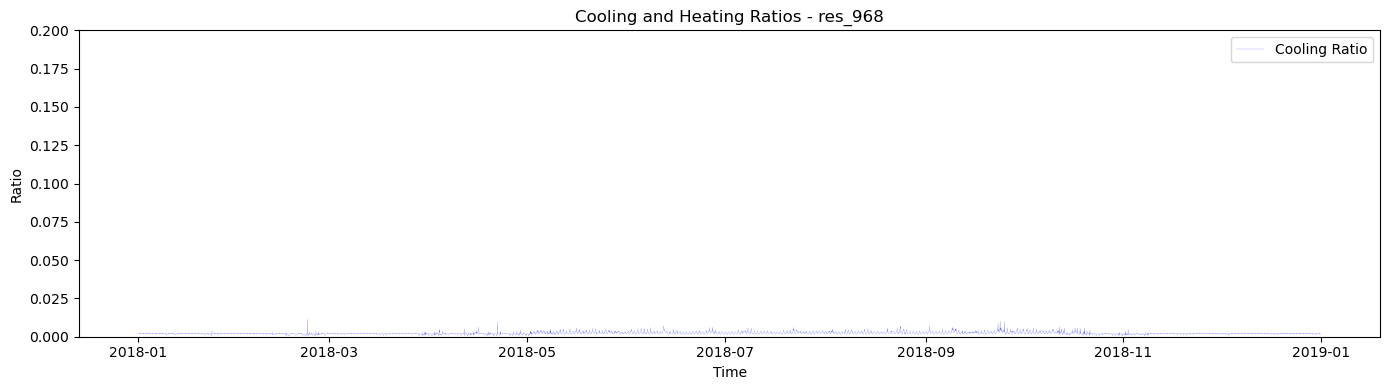

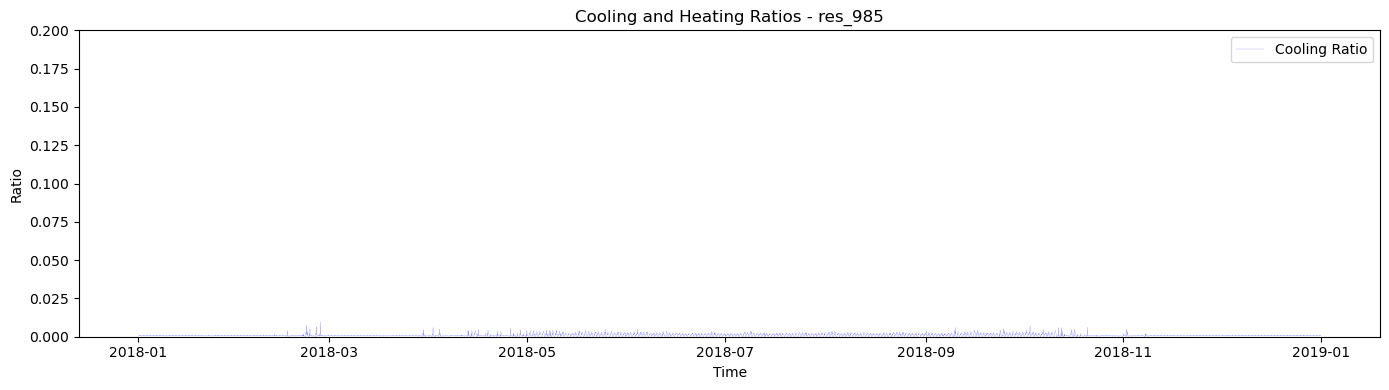

In [64]:
import matplotlib.pyplot as plt

line_width = 0.1

outer_key = (smart_ds_year, city, region, feeder, building_type)

# Set plot limits (adjust as needed)
if building_type == 'res':
    y_min, y_max = 0, 0.2  # Assuming ratios between 0 and a bit above 1
else:
    y_min, y_max = 0, 1  # Assuming ratios between 0 and a bit above 1

x_min, x_max = None, None  # You can set this if you want to limit time range (e.g., 0, 96 for a 4-day window at 15-min resolution)


# Check if the outer_key exists
if outer_key not in building_measured_cooling_ratio_dict or outer_key not in building_measured_heating_ratio_dict:
    print(f"Outer key {outer_key} not found in the dictionaries.")
else:
    # Get inner dictionaries
    cooling_ratios = building_measured_cooling_ratio_dict[outer_key]
    heating_ratios = building_measured_heating_ratio_dict[outer_key]

    # Plot for each building
    for building_name in cooling_ratios:
        # Set the y-axis limits
        plt.figure(figsize=(14, 4))
        plt.plot(cooling_ratios[building_name], color='blue', label='Cooling Ratio',linewidth=line_width)
        # plt.plot(heating_ratios[building_name], color='red', label='Heating Ratio', linewidth=line_width)
        plt.title(f'Cooling and Heating Ratios - {building_name}')
        plt.xlabel('Time')
        plt.ylabel('Ratio')
        # Set axis limits
        plt.ylim(y_min, y_max)
        if x_min is not None and x_max is not None:
            plt.xlim(x_min, x_max)
        plt.legend()
        plt.tight_layout()
        plt.show()


#### Plot heating and cooling ratios for each building - all together 

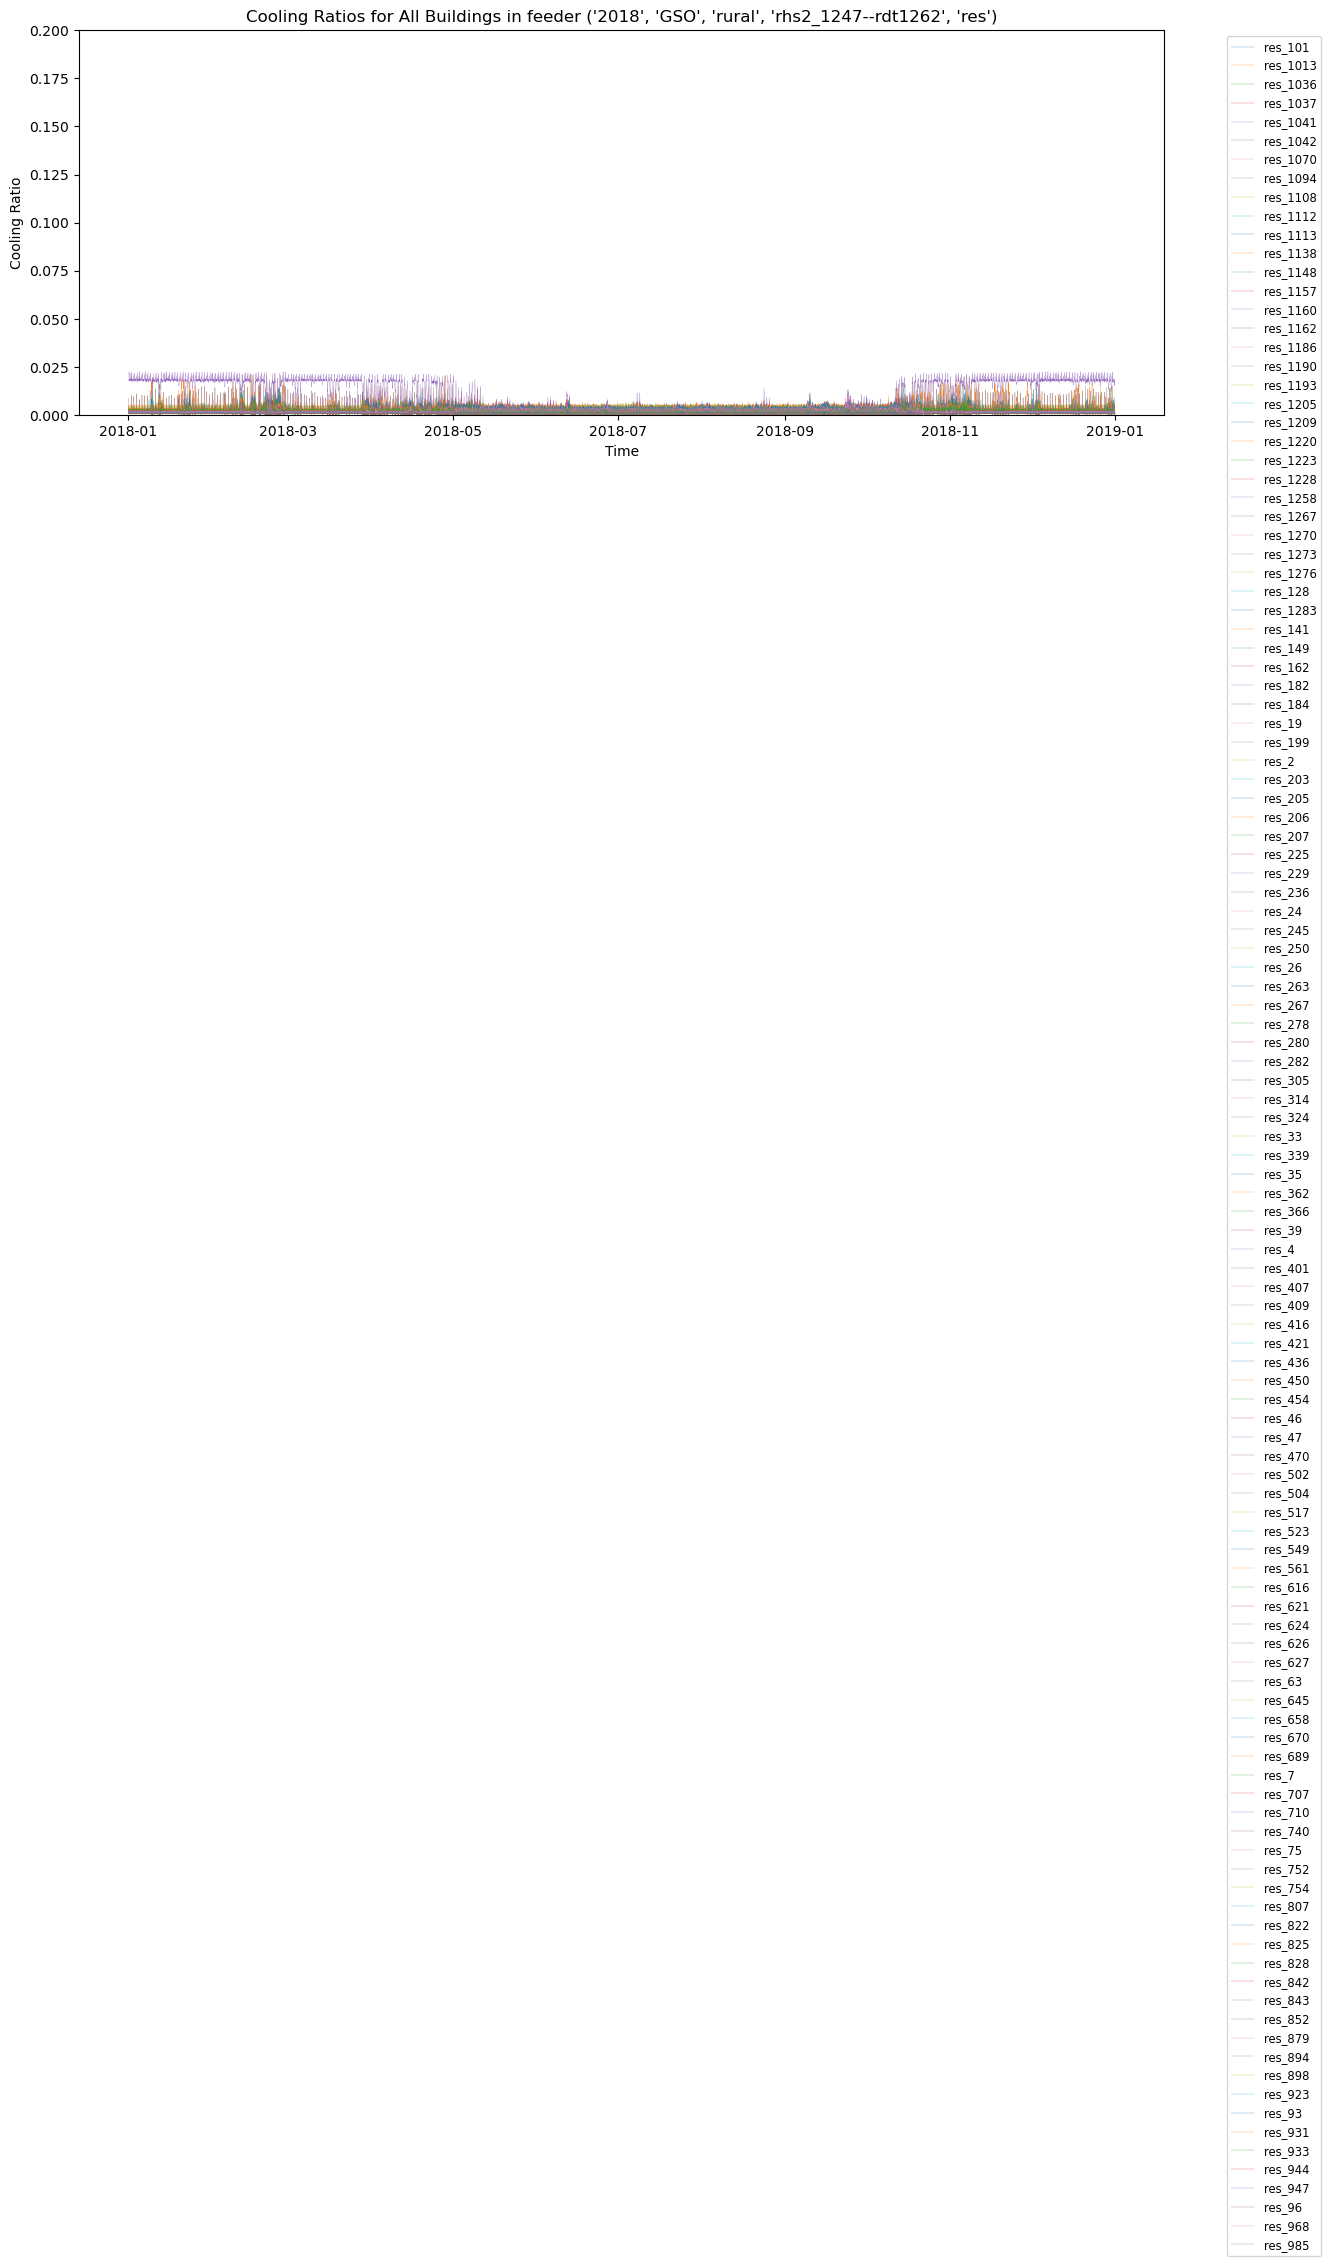

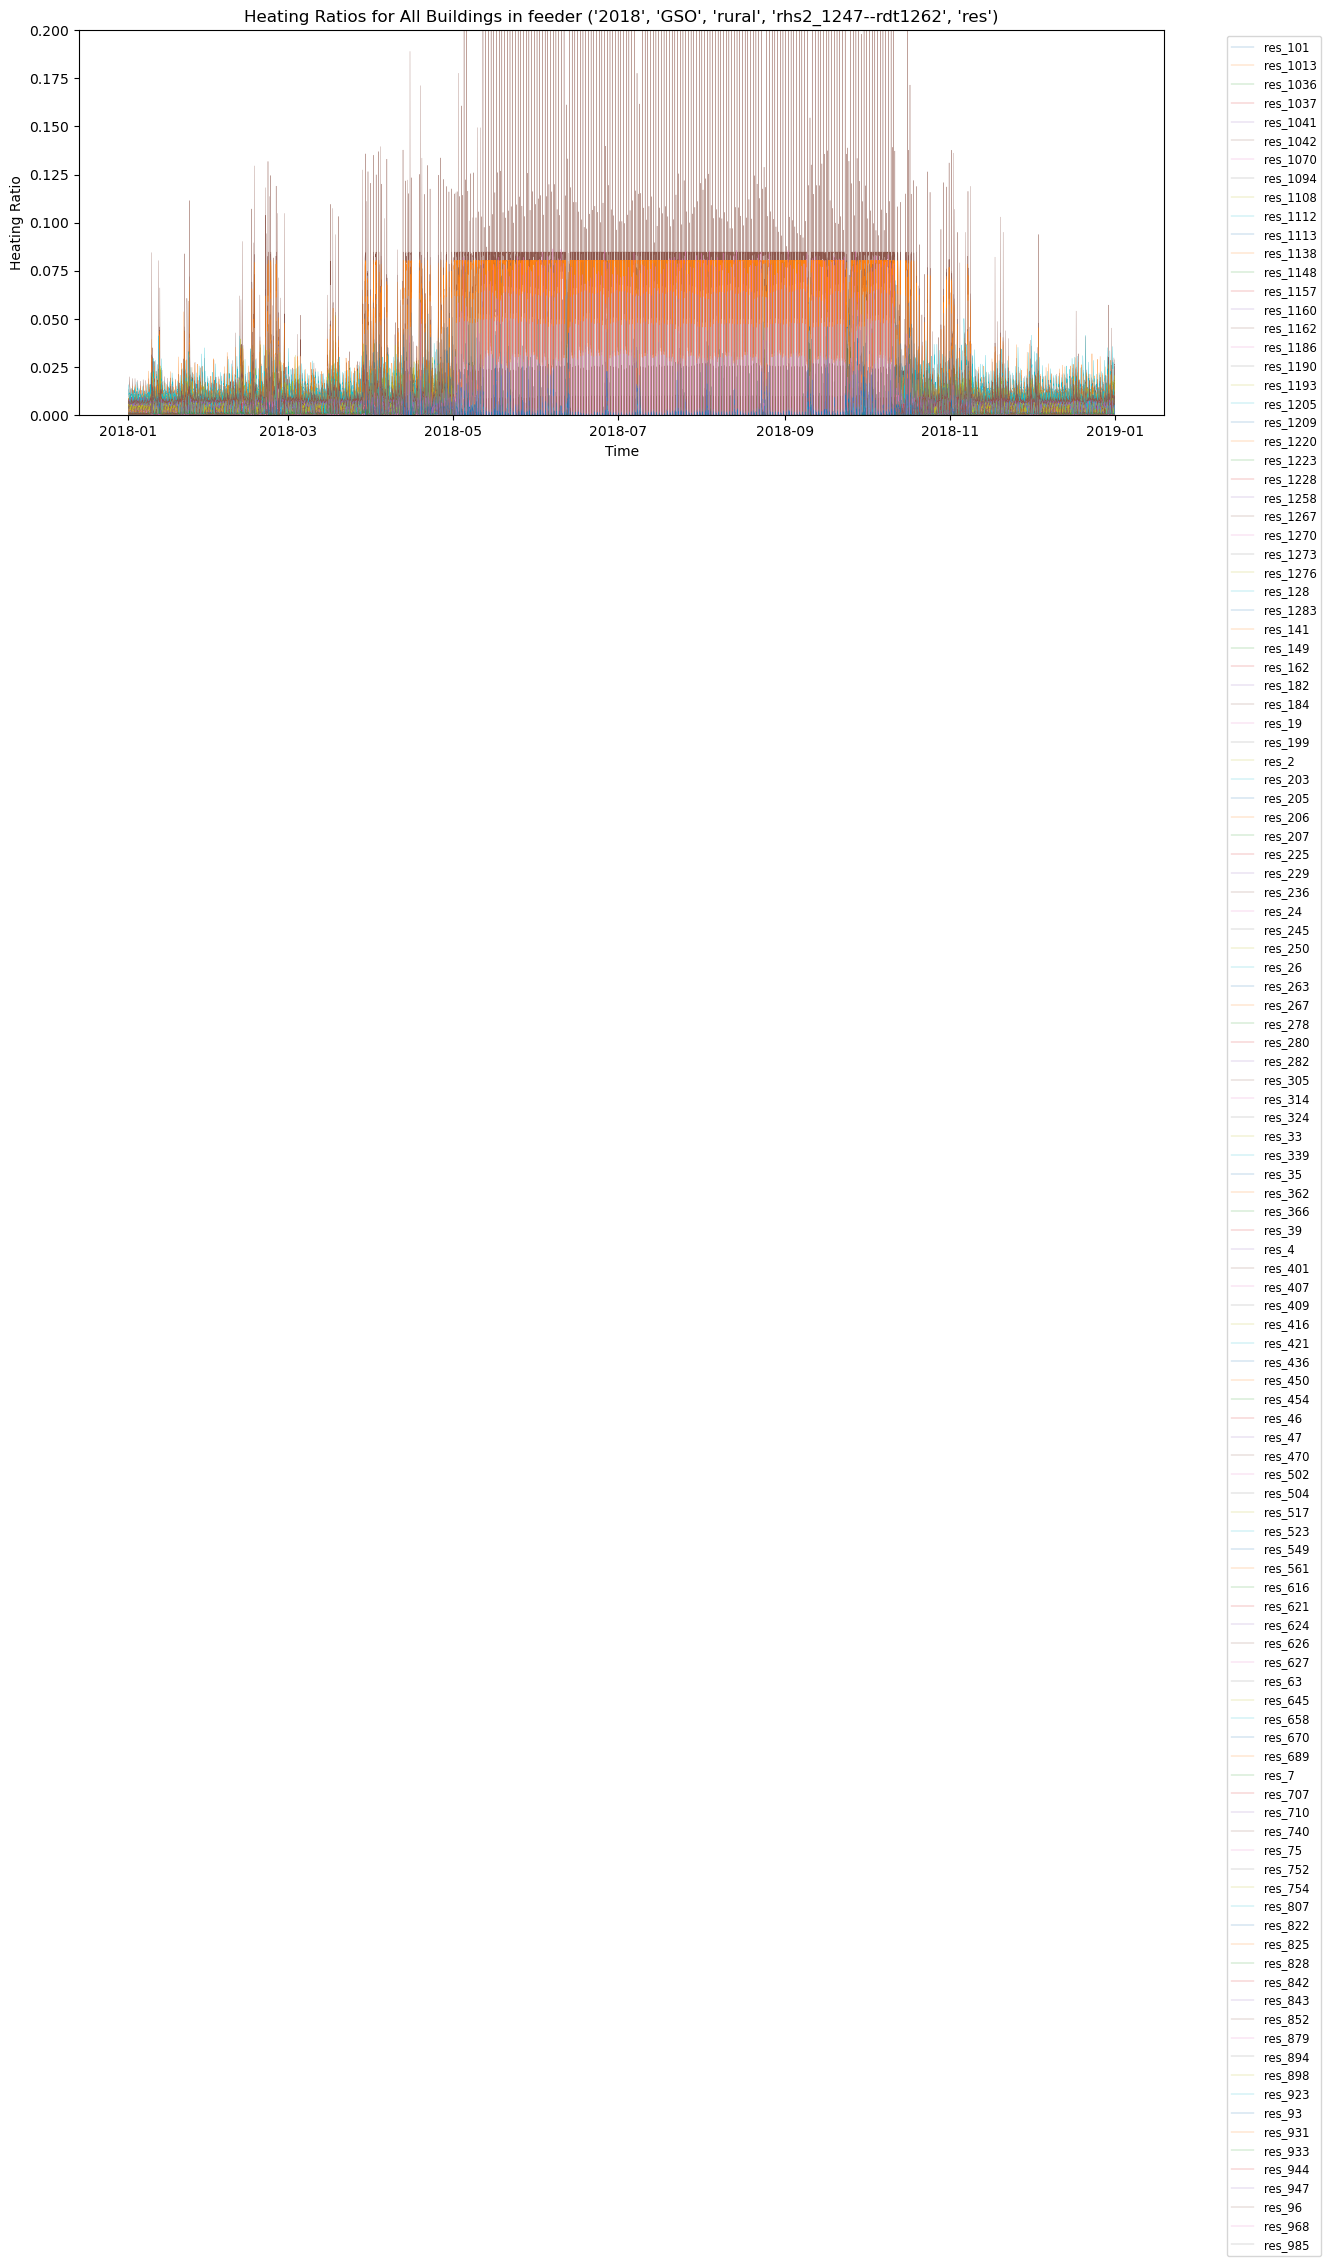

In [65]:
import matplotlib.pyplot as plt

# Set axis limits (adjust as needed)
# Set plot limits (adjust as needed)
if building_type == 'res':
    y_min, y_max = 0, 0.2  # Assuming ratios between 0 and a bit above 1
else:
    y_min, y_max = 0, 1  # Assuming ratios between 0 and a bit above 1

x_min, x_max = None, None  # You can set this if you want to limit time range (e.g., 0, 96 for a 4-day window at 15-min resolution)

line_width = 0.2  # Customize line width

# Cooling Ratio Plot
plt.figure(figsize=(14, 5))
for building_name, ratio_series in cooling_ratios.items():
    plt.plot(ratio_series, label=building_name, linewidth=line_width)
plt.title(f'Cooling Ratios for All Buildings in feeder {outer_key}')
plt.xlabel('Time')
plt.ylabel('Cooling Ratio')
plt.ylim(y_min, y_max)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()

# Heating Ratio Plot
plt.figure(figsize=(14, 5))
for building_name, ratio_series in heating_ratios.items():
    plt.plot(ratio_series, label=building_name, linewidth=line_width)
plt.title(f'Heating Ratios for All Buildings in feeder {outer_key}')
plt.xlabel('Time')
plt.ylabel('Heating Ratio')
plt.ylim(y_min, y_max)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()


##  Disaggregate feeder prediction to buildings using a *single* scaling ratio at feeder peak timestep 


#### (advantage: does not improve 2018 cooling and heating load shapes on future years. Disadvantage: smooths all cooling and heating to feeder level aggregates and looses information about building cooling and heating temporal charachtaristics, which might affect loading at the LV network level.  To use this approach, we should improve it by using monthly/weekly average/max instead of a single scaling value and maybe also use temperatures to account for how building shapes change in different weather years)

#### Select feeder

In [67]:
smart_ds_year = '2018'
city = 'GSO'
region = 'rural'
feeder = 'rhs3_1247--rdt2705'
building_type = 'com'
display(measured_buildings_cool_heat_dict[(smart_ds_year, city, region, feeder, building_type)].keys())

dict_keys(['com_12814', 'com_12841', 'com_12942', 'com_13010', 'com_13363', 'com_13515', 'com_13682', 'com_13807', 'com_13875', 'com_13880', 'com_14013', 'com_14204', 'com_14231', 'com_14348', 'com_14502', 'com_14619', 'com_14650', 'com_14665', 'com_14789', 'com_14822', 'com_14883', 'com_15017', 'com_15092', 'com_15253', 'com_15271'])

#### Select building

In [68]:
building_name = 'com_14789'
display(measured_buildings_cool_heat_dict[(smart_ds_year, city, region, feeder, building_type)][building_name].head(2))

total_site_electricity_kw  cooling_sum_kw  heating_kw  \
date_time                                                                    
2018-01-01 00:00:00                   5.269696        0.000000         0.0   
2018-01-01 01:00:00                   5.454895        0.262074         0.0   

                     non_cool_n_heat_kw  
date_time                                
2018-01-01 00:00:00            5.269696  
2018-01-01 01:00:00            5.192821

#### Disaggregate cooling and heating feeder prediction 

In [69]:
# Load feeder clustered resstock building dictionary 
# (later change to new dictionary with predictions, saved per TGW year)

TGW_weather_year = TGW_weather_years[0]

# --- For each feeder ---

# Compute measured feeder max at feeder's peak timestep 
feeder_cooling_series = measured_feeder_cool_n_heat_dict[(smart_ds_year, city, region, feeder, building_type)]['cooling_kw_sum']
feeder_heating_series = measured_feeder_cool_n_heat_dict[(smart_ds_year, city, region, feeder, building_type)]['heating_kw']

feeder_cooling_max_time = feeder_cooling_series.idxmax()
feeder_heating_max_time = feeder_heating_series.idxmax()

feeder_cooling_max = feeder_cooling_series[feeder_cooling_max_time]
feeder_heating_max = feeder_heating_series[feeder_heating_max_time]

# --- For each building ---

# Compute building max at feeder's peak timestep 
building_data = measured_buildings_cool_heat_dict[(smart_ds_year, city, region, feeder, building_type)][building_name]

building_cooling_max = building_data['cooling_sum_kw'][feeder_cooling_max_time]
building_heating_max = building_data['heating_kw'][feeder_heating_max_time]

# Compute predicted feeder total
feeder_pred_data = feeder_predict_cool_heat_dict[(TGW_weather_year, city, region, feeder, building_type)]

# Use the datetime index from measured data
datetime_index = building_data['non_cool_n_heat_kw'].index

assert len(feeder_pred_data) == len(datetime_index), "Mismatch in time series length"

# Reindex the predicted feeder data to match
feeder_pred_data_aligned = feeder_pred_data.copy()
feeder_pred_data_aligned.index = datetime_index

# Now compute the predicted building total
building_predicted_total = (
    (building_cooling_max / feeder_cooling_max) * feeder_pred_data_aligned['cooling_kw_sum_predicted'] +
    (building_heating_max / feeder_heating_max) * feeder_pred_data_aligned['heating_kw_predicted'] +
    building_data['non_cool_n_heat_kw']
)

# Final output
building_predicted_total


date_time
2018-01-01 00:00:00     9.673505
2018-01-01 01:00:00     9.684539
2018-01-01 02:00:00     9.813899
2018-01-01 03:00:00    10.640610
2018-01-01 04:00:00    11.022726
                         ...    
2018-12-31 19:00:00    13.203730
2018-12-31 20:00:00    12.520293
2018-12-31 21:00:00    11.710884
2018-12-31 22:00:00    10.732253
2018-12-31 23:00:00    10.240989
Length: 8760, dtype: float64

#### Plot heating cooling comopnents 

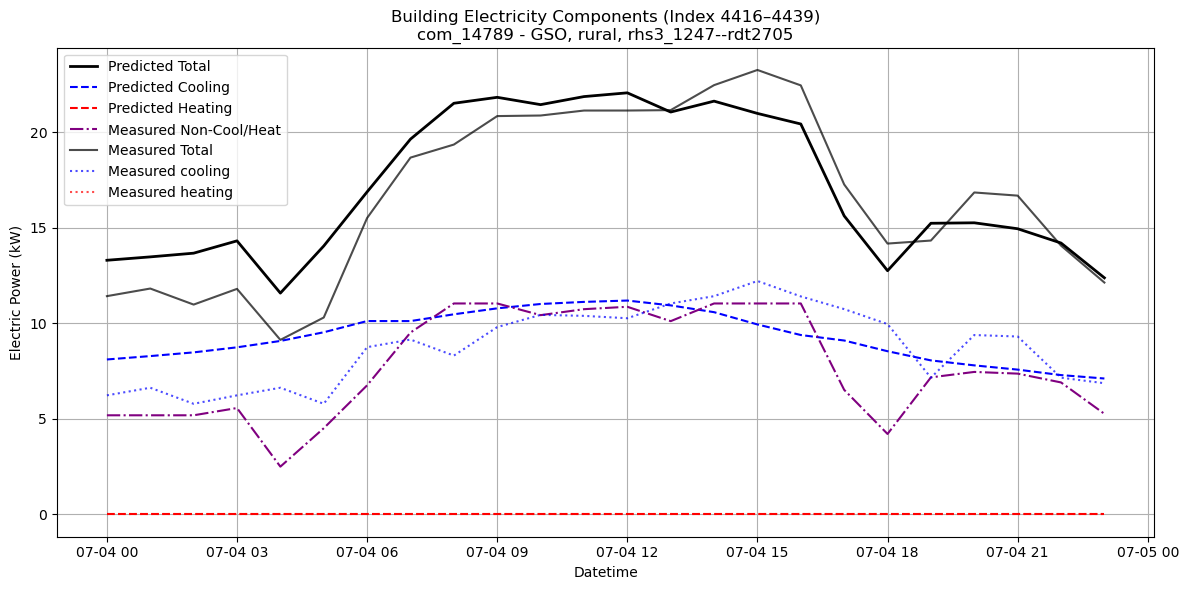

In [70]:
import matplotlib.pyplot as plt

# --- Compute components ---
cooling_component = (building_cooling_max / feeder_cooling_max) * feeder_pred_data_aligned['cooling_kw_sum_predicted']
heating_component = (building_heating_max / feeder_heating_max) * feeder_pred_data_aligned['heating_kw_predicted']
non_cn_h_component = building_data['non_cool_n_heat_kw']
measured_total = building_data['total_site_electricity_kw']
measured_cooling = building_data['cooling_sum_kw']
measured_heating = building_data['heating_kw']


# --- Compute predicted total ---
building_predicted_total = cooling_component + heating_component + non_cn_h_component

# --- Select a range of data points (e.g., 1–24) ---
start, end = 184*24, 184*24+24  # Index range (1 to 24 inclusive)
building_predicted_total = building_predicted_total.iloc[start:end]
cooling_component = cooling_component.iloc[start:end]
heating_component = heating_component.iloc[start:end]
non_cn_h_component = non_cn_h_component.iloc[start:end]
measured_total = measured_total.iloc[start:end]
measured_cooling = measured_cooling.iloc[start:end]
measured_heating = measured_heating.iloc[start:end]

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(building_predicted_total, label='Predicted Total', linewidth=2, color='black')
plt.plot(cooling_component, label='Predicted Cooling', linestyle='--', color='blue')
plt.plot(heating_component, label='Predicted Heating', linestyle='--', color='red')
plt.plot(non_cn_h_component, label='Measured Non-Cool/Heat', linestyle='-.', color='purple')
plt.plot(measured_total, label='Measured Total', alpha=0.7, color='black')
plt.plot(measured_cooling, label='Measured cooling',linestyle=':', alpha=0.7, color='blue')
plt.plot(measured_heating, label='Measured heating',linestyle=':', alpha=0.7, color='red')


plt.title(f"Building Electricity Components (Index {start}–{end-1})\n{building_name} - {city}, {region}, {feeder}")
plt.xlabel("Datetime")
plt.ylabel("Electric Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ____________________________

## Check memory usage

In [36]:
import os
import psutil

process = psutil.Process(os.getpid())
mem_info = process.memory_info()

print(f"Memory used by this process: {mem_info.rss / 1e9:.2f} GB")

Memory used by this process: 5.44 GB
